<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [57]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.2.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-08 22:32:33.566151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_1898745/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6      3.0.0   
...                         ...                               ...        ...   
6151a44f8558145da68d8737     db  051b02a953fb513b2cf4f19a60069692      2.4.6   
615ac5528f3b0514f3f423e8     db  8c9b20339e6d9035e96307783577cf91      2.4.6   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2   23.01.04   
63c506ece2456d59975e15ad     db  5c16bf00da66d39e72a08d9838b1f501   23.01.04   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276   23.01.23   

                                         export_date      len  \
_id                                                             
5ec2b8da665f7603e03b1255  2023-02-08 17:25:44.701177   5840.0   
5edbc62eda3678279fbcadf3  2023-02-08 17:25:27.868843   1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-08 17:25:24.031593    460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376   8530.0   
6285f9c04d1bfe5e5b297ddd  2023-02-01 17:26:53.153480   5550.0   
...                                              ...      ...   
6151a44f8558145da68d8737  2023-01-31 18:36:07.027314   5950.0   
615ac5528f3b0514f3f423e8  2023-01-31 18:36:07.432156    950.0   
63c506d5e2456d59975e1389  2023-01-31 21:42:26.523639   2170.0   
63c506ece2456d59975e15ad  2023-01-31 21:42:26.812111   1230.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
...                                                   ...           ...   
6151a44f8558145da68d8737 2021-09-27 14:01:29.375000+00:00           NaN   
615ac5528f3b0514f3f423e8 2021-10-04 12:12:04.973000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
63c506ece2456d59975e15ad 2023-01-16 11:26:04.804000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   

                          value_log1p  value_span currency  ... documentType  \
_id                                                         ...                
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     CONTRACT   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...     CONTRACT   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     CONTRACT   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...     CONTRACT   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      RUB  ...     CONTRACT   
...                               ...         ...      ...  ...          ...   
6151a44f8558145da68d8737          NaN         NaN      NaN  ...     CONTRACT   
615ac5528f3b0514f3f423e8          NaN         NaN      NaN  ...     CONTRACT   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...    AGREEMENT   
63c506ece2456d59975e15ad          NaN         NaN      NaN  ...    AGREEMENT   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...     CONTRACT   

                         subj_len headers  \
_id                                         
5ec2b8da665f7603e03b1255     79

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1212

In [18]:
print(len(stats))

2793


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
6380855c6a07f3e980b2c061     db  9756e819859af5192b5e44806f173d8c  22.12.7   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-08 17:25:48.484898   1990.0   
63908ca4a1bded13e629f2e4  2023-02-07 17:45:41.189147   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-08 17:25:44.958631   5210.0   
62d149464ae369b4976e31f3  2023-02-08 17:25:47.062549   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
6380855c6a07f3e980b2c061  2023-02-08 17:25:48.465413   1950.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fe4821fb770574a00555741  2023-02-08 17:25:46.982339   2030.0   
5fb3d7a178df3635f5441d6a  2023-02-08 17:25:44.965131   2030.0   
62c54895e599c73b751b7974  2023-02-08 17:25:47.056315   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
6380855c6a07f3e980b2c061 2022-12-08 16:02:19.987000+00:00  5.000000e+02   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fe4821fb770574a00555741 2020-12-24 17:44:47.597000+00:00           NaN   
5fb3d7a178df3635f5441d6a 2020-11-17 15:51:04.944000+00:00           NaN   
62c54895e599c73b751b7974 2022-07-06 11:36:30.939000+00:00  5.000000e+02   
638085976a07f3e980b2c575 2022-11-25 12:33:13.393000+00:00  1.000000e+02   

                          value_log1p  value_span currency  ... documentType  \
_id               

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
errors_file = Path(analyser.__file__).parent.parent /'trainsets' / 'errors.csv'
errors_file
errors_df = pd.read_csv(errors_file, index_col=0)
errors_df

дата редактирования  \
6152e3af8558145da68d8790  2023-02-01 14:53:58.672   
5fbbbd13a2b4551c061078bf  2023-02-08 12:00:08.079   
6152e3798558145da68d8788  2021-09-30 08:13:06.705   
615ac8b28f3b0514f3f423f2  2021-10-04 09:27:25.636   
615ac8cf8f3b0514f3f423f8  2021-10-04 09:30:37.752   
...                                           ...   
628603754d1bfe5e5b297dea  2023-02-02 10:16:56.372   
5fc63d611d0a1603c7a0c97d  2020-12-18 07:42:51.215   
6393256f1002115a6029f3f0  2023-02-04 08:05:50.469   
636cb443f67f84810526f916  2023-02-08 10:57:19.267   
615e9ee38f3b0514f3f42422  2021-10-07 09:04:40.817   

                                                                       link  \
6152e3af8558145da68d8790  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
5fbbbd13a2b4551c061078bf  https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...   
6152e3798558145da68d8788  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
615ac8b28f3b0514f3f423f2  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
615ac8cf8f3b0514f3f423f8  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
...                                                                     ...   
628603754d1bfe5e5b297dea  https://gpn-audit.nemosoft.ru/#/audit/edit/628...   
5fc63d611d0a1603c7a0c97d  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   
636cb443f67f84810526f916  https://gpn-audit.nemosoft.ru/#/audit/edit/636...   
615e9ee38f3b0514f3f42422  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   

                                                                      error  \
6152e3af8558145da68d8790     налог не указан;\nНомер не является номером;\n   
5fbbbd13a2b4551c061078bf  Псевдоним 2 очень странный;\nПсевдоним 1 очень...   
6152e3798558145da68d8788                                                NaN   
615ac8b28f3b0514f3f423f2                                                NaN   
615ac8cf8f3b0514f3f423f8                       Номер не является номером;\n   
...                                                                     ...   
628603754d1bfe5e5b297dea                                                NaN   
5fc63d611d0a1603c7a0c97d                                                NaN   
6393256f1002115a6029f3f0                                                NaN   
636cb443f67f84810526f916                                                NaN   
615e9ee38f3b0514f3f42422                                                NaN   

                                                              error missing  \
6152e3af8558145da68d8790  Наименование 2 отсутсвует;\nФорма собственност...   
5fbbbd13a2b4551c061078bf                                                NaN   
6152e3798558145da68d8788  Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...   
615ac8b28f3b0514f3f423f2  Псевдоним 2 отсутсвует;\nФорма собственности 2...   
615ac8cf8f3b0514f3f423f8  Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...   
...                                                                     ...   
628603754d1bfe5e5b297dea                                                NaN   
5fc63d611d0a1603c7a0c97d                                                NaN   
6393256f1002115a6029f3f0                                                NaN   
636cb443f67f84810526f916                                                NaN   
615e9ee38f3b0514f3f42422                                                NaN   

                          errors count  subject len  subject kind  \
6152e3af8558145da68d8790           6.0          NaN           NaN   
5fbbbd13a2b4551c061078bf           6.0          0.0           NaN   
6152e3798558145da68d8788           6.0          NaN           NaN   
615ac8b28f3b0514f3f423f2           5.0          NaN           NaN   
615ac8cf8f3b0514f3f423f8           5.0          NaN           NaN   
...                                ...          ...           ...   
628603754d1bfe5e5b297dea           0.0          NaN           N

In [21]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2793


CONTRACT                   0.641740
SUPPLEMENTARY_AGREEMENT    1.090836
AGREEMENT                  1.267423
Name: documentType, dtype: float64

In [22]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [23]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors count']


  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


16.19178838621892
0.8314972914531967
0.5003297131611714
0.12575603432204727
150.73255449984026
5.670439776154809


In [24]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [25]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


2793


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [26]:

len(stats_valid)

2793

In [27]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()





16.19178838621892
0.8314972914531967


In [28]:
print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

1.0
0.15124046177259956


sample_weight
MIN	 0.030900213196153777
MAX	 9.309197409480168
MEAN	 0.9999999999999999


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


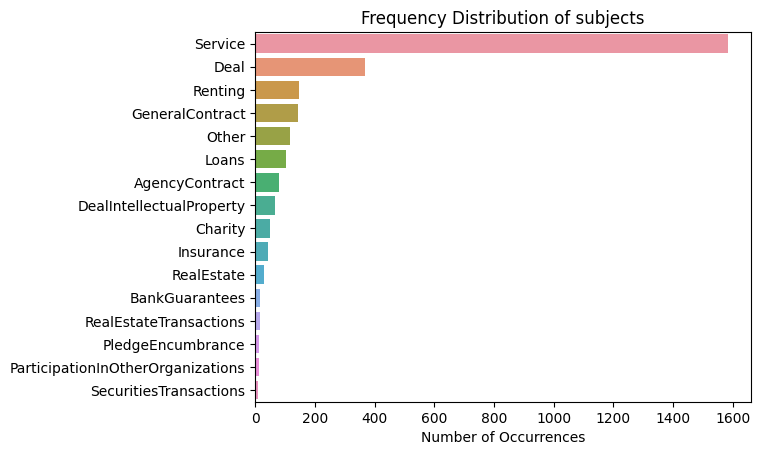


min 8
max 1583
total 2793


In [29]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [30]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Service', 'AgencyContract', 'Charity', 'Loans', 'SecuritiesTransactions', 'BankGuarantees', 'Renting', 'PledgeEncumbrance', 'Deal', 'DealIntellectualProperty', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.500328
Deal                                 0.623365
Renting                              0.737666
GeneralContract                      0.740701
Other                                0.775471
Loans                                0.793704
AgencyContract                       0.841226
DealIntellectualProperty             0.879851
Charity                              0.947185
Insurance                            0.968374
RealEstate                           1.063634
BankGuarantees                       1.275363
RealEstateTransactions               1.301093
PledgeEncumbrance                    1.437172
ParticipationInOtherOrganizations    1.437172
SecuritiesTransactions               1.677695
Name: subject, dtype: float64

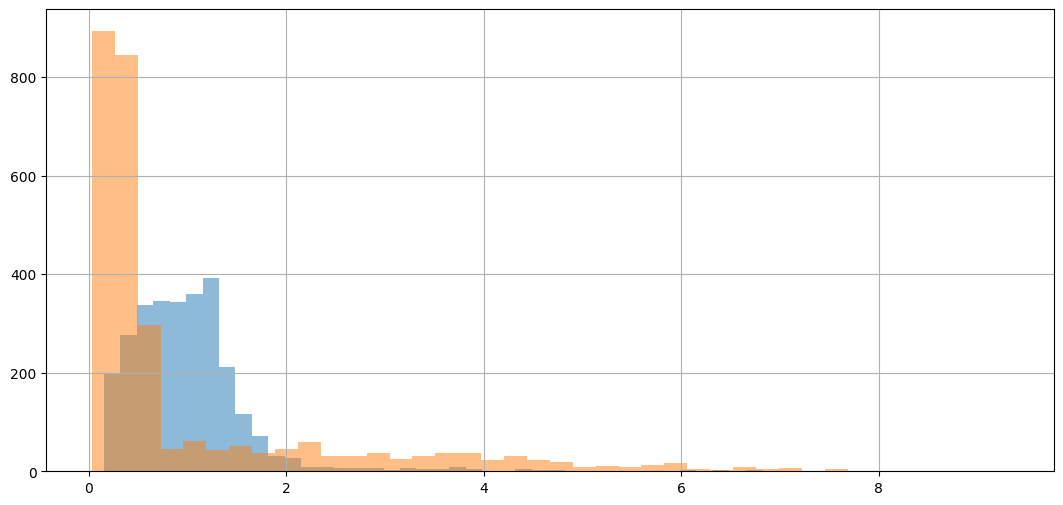

In [31]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

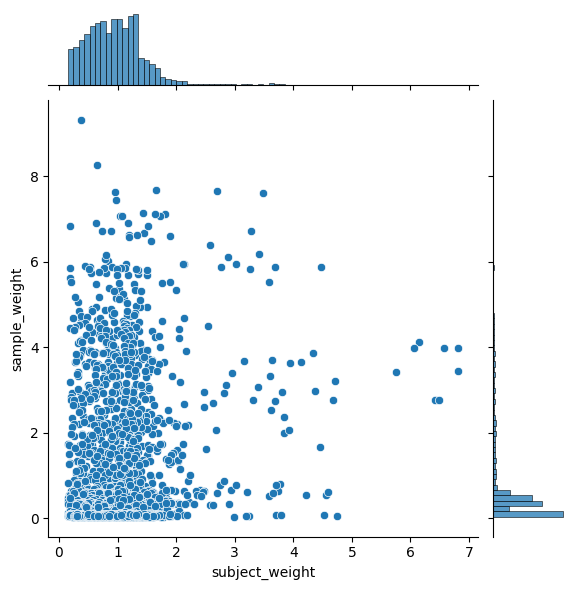

In [32]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


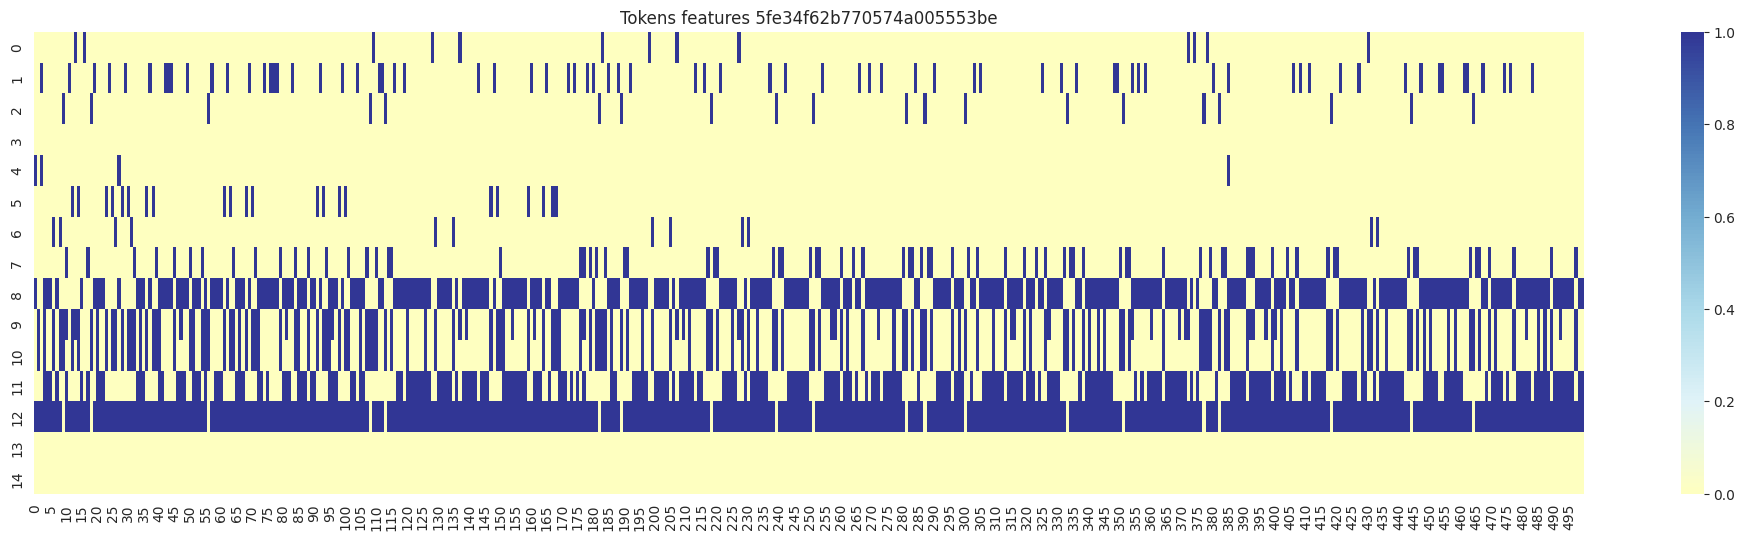

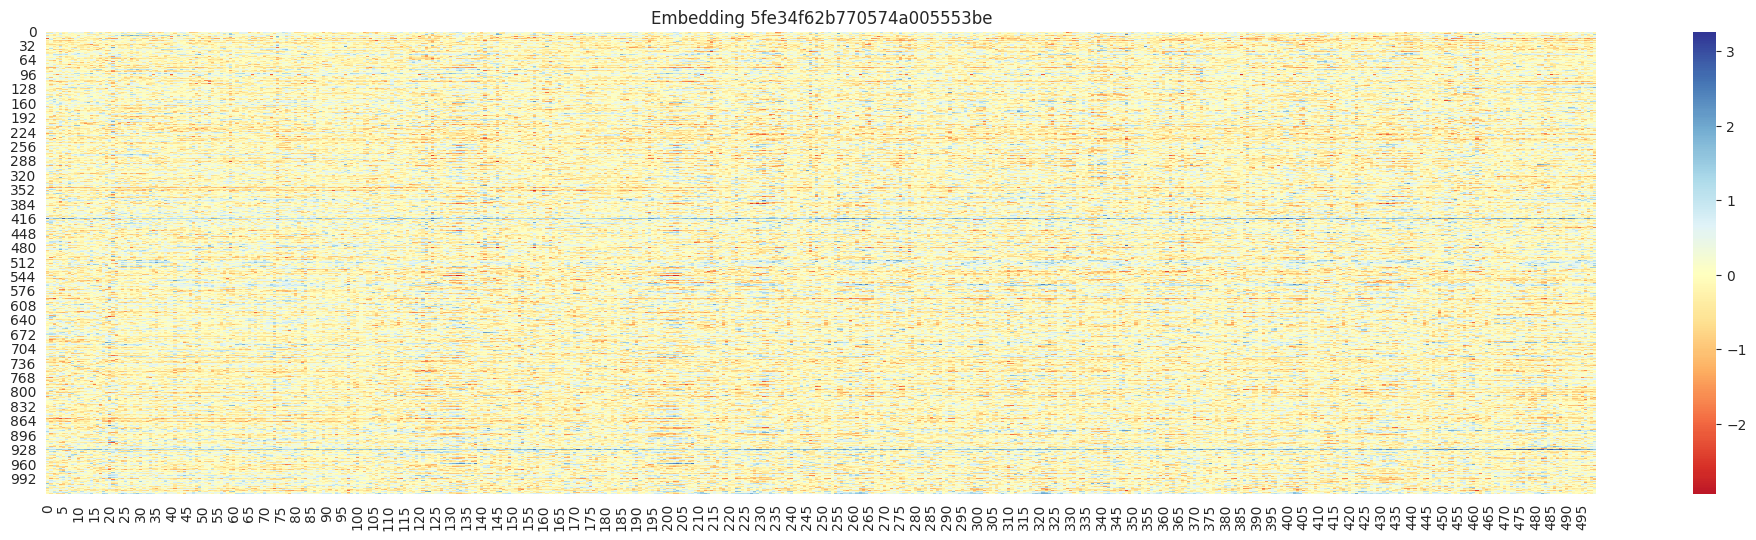

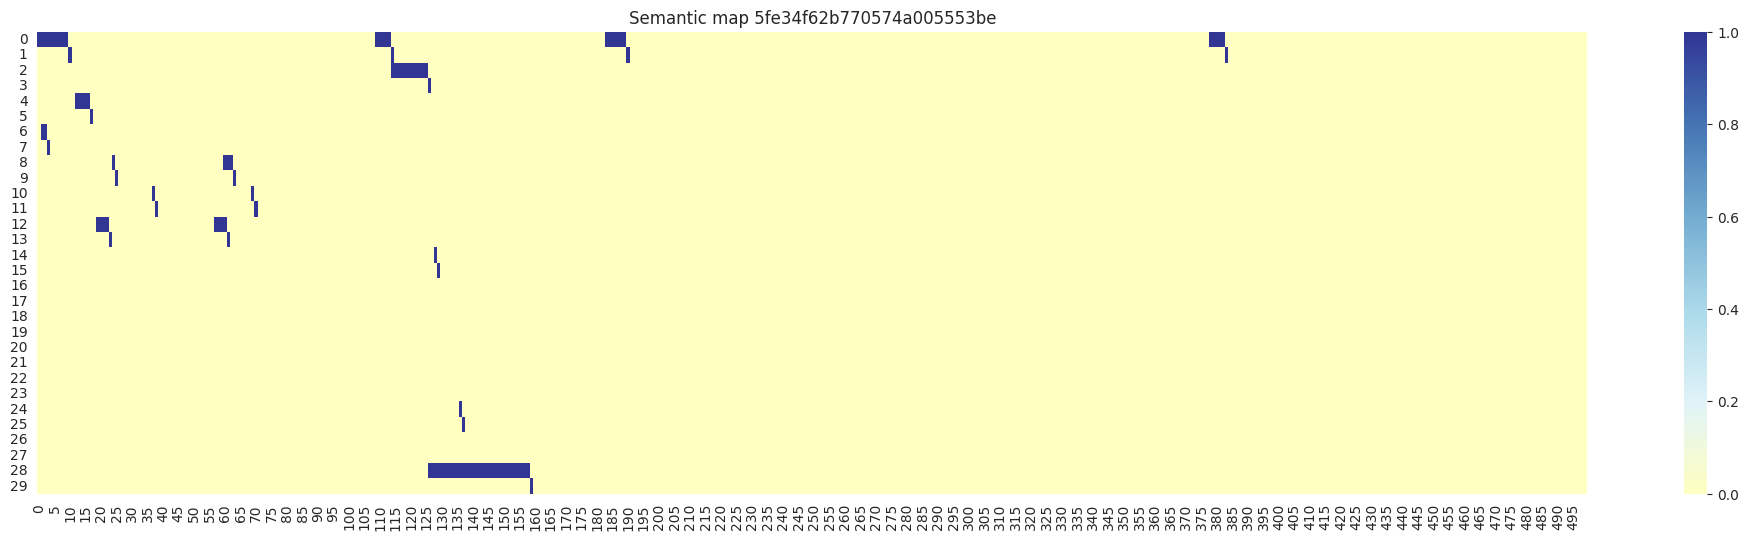

In [33]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 318, 30)


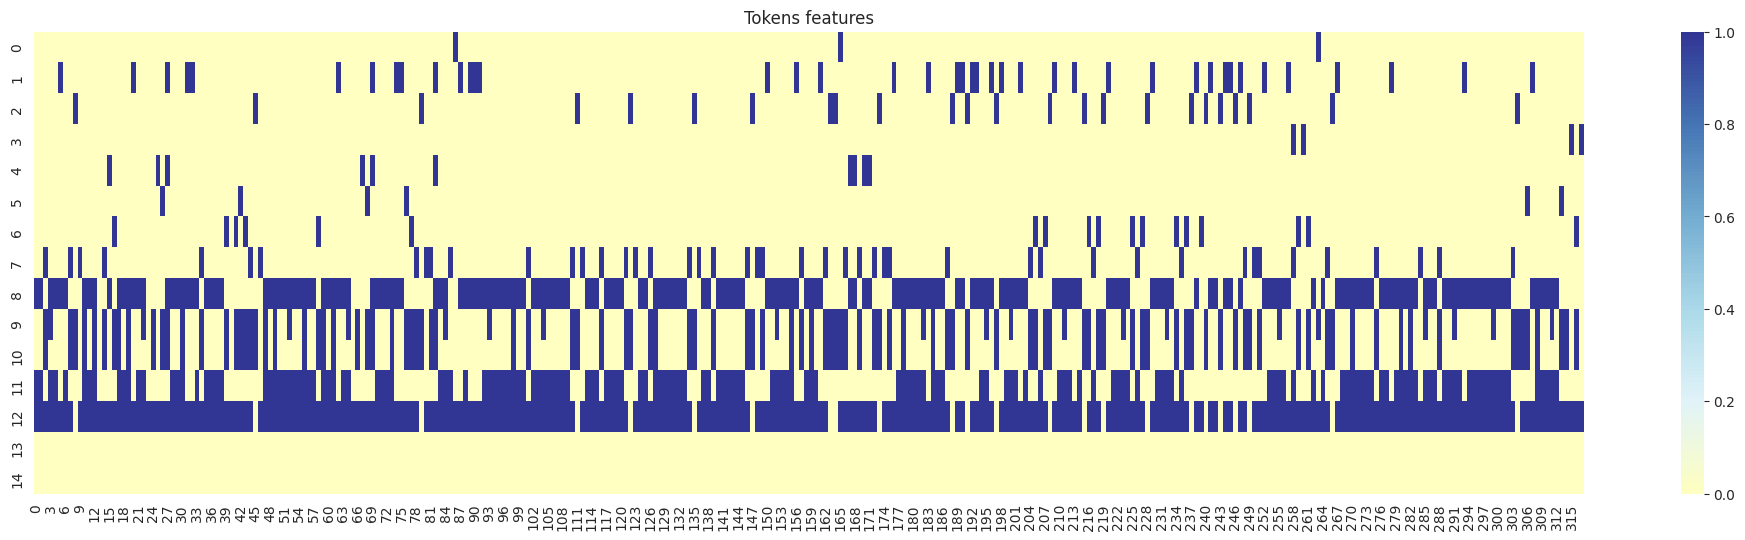

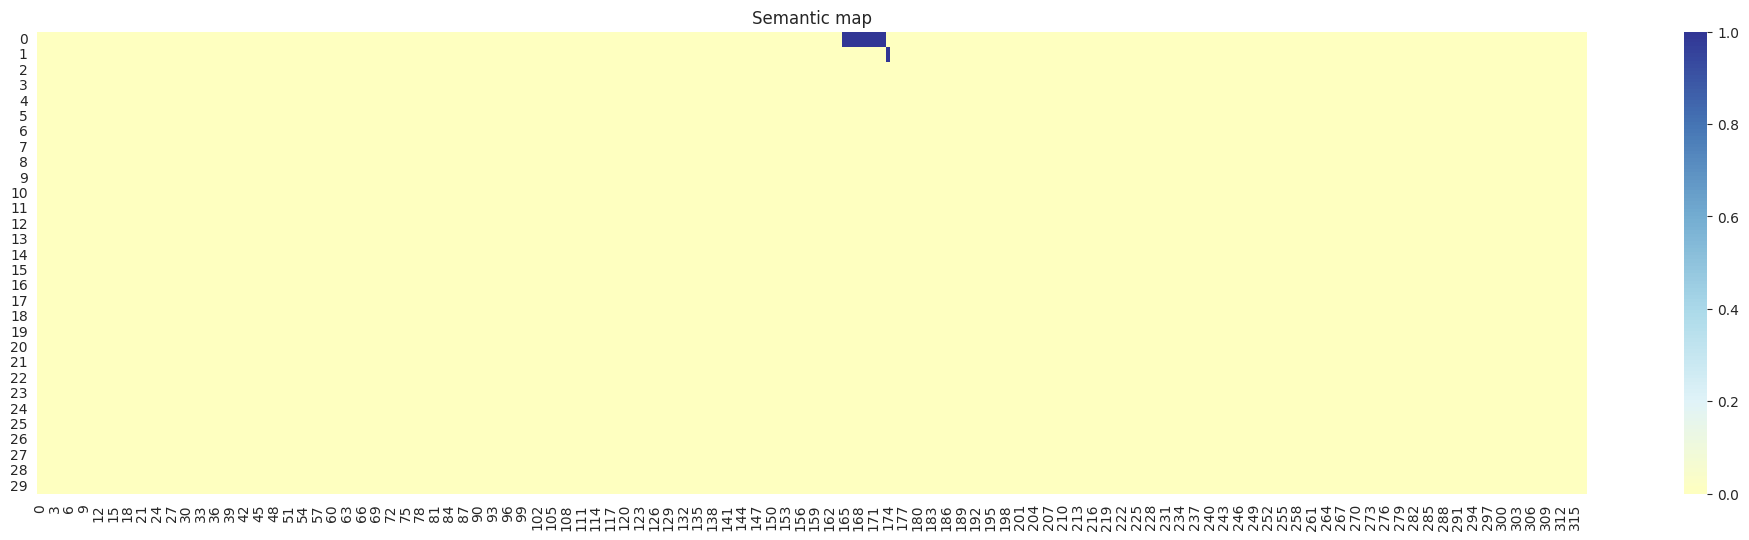

In [34]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
#   np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 1536
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']], random_state=11)

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [35]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

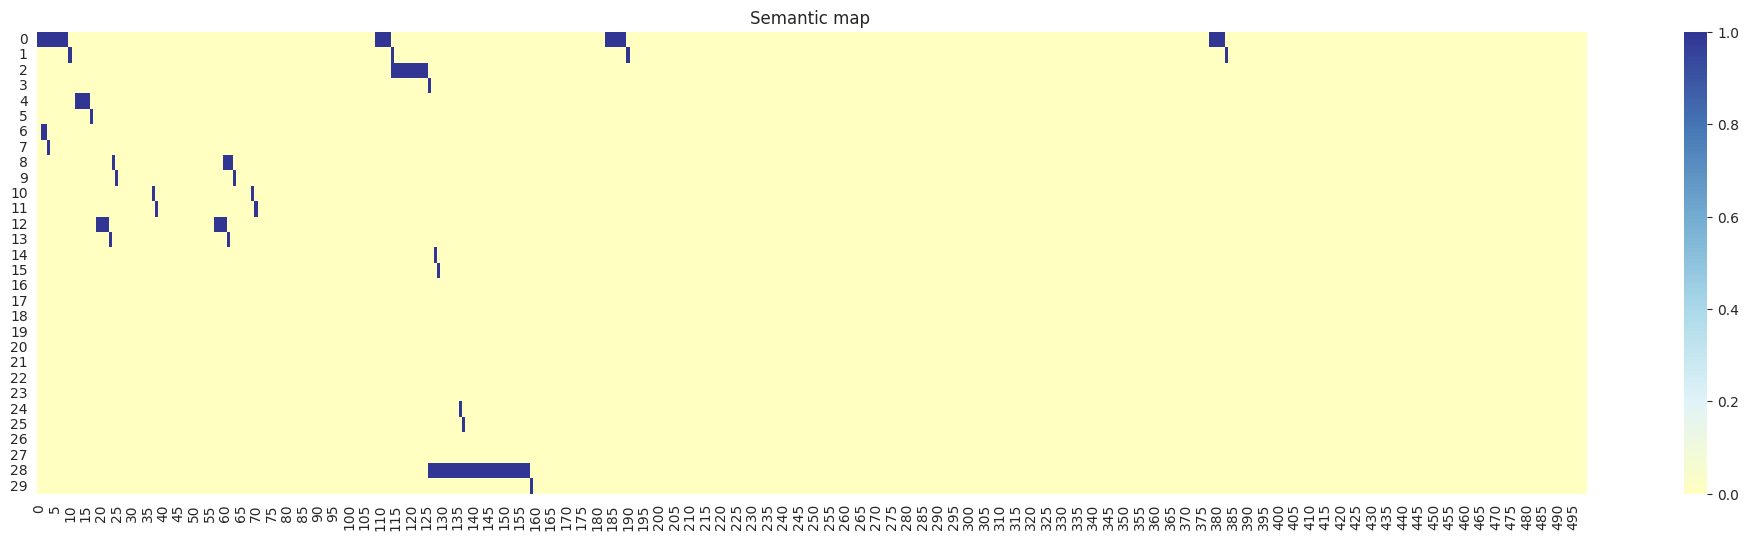

In [36]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 63c506ade2456d59975e0fb5
test_indices[0]: 60002adfb08473039387bcb0


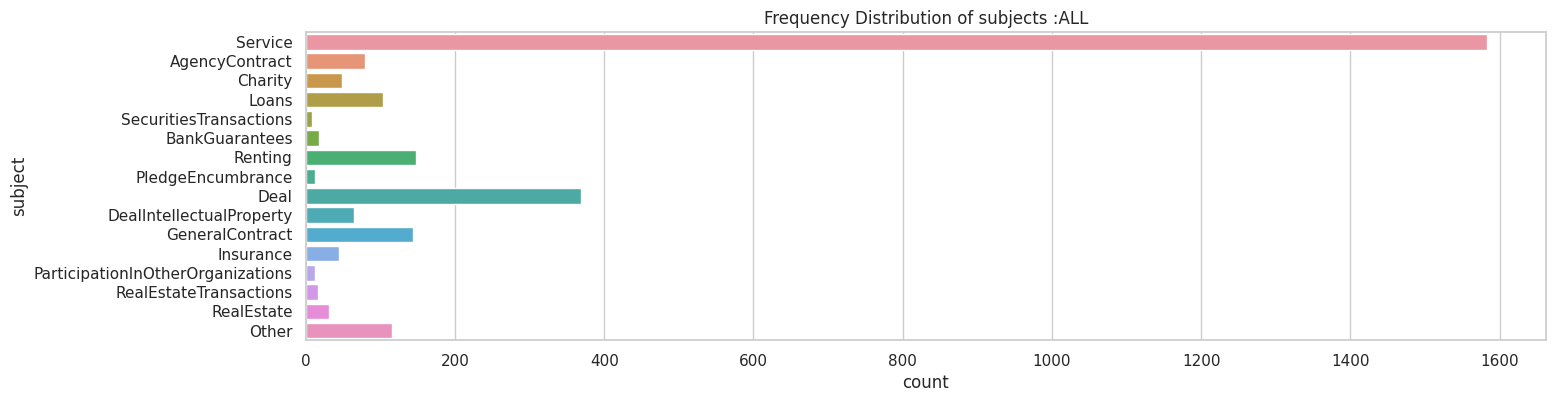

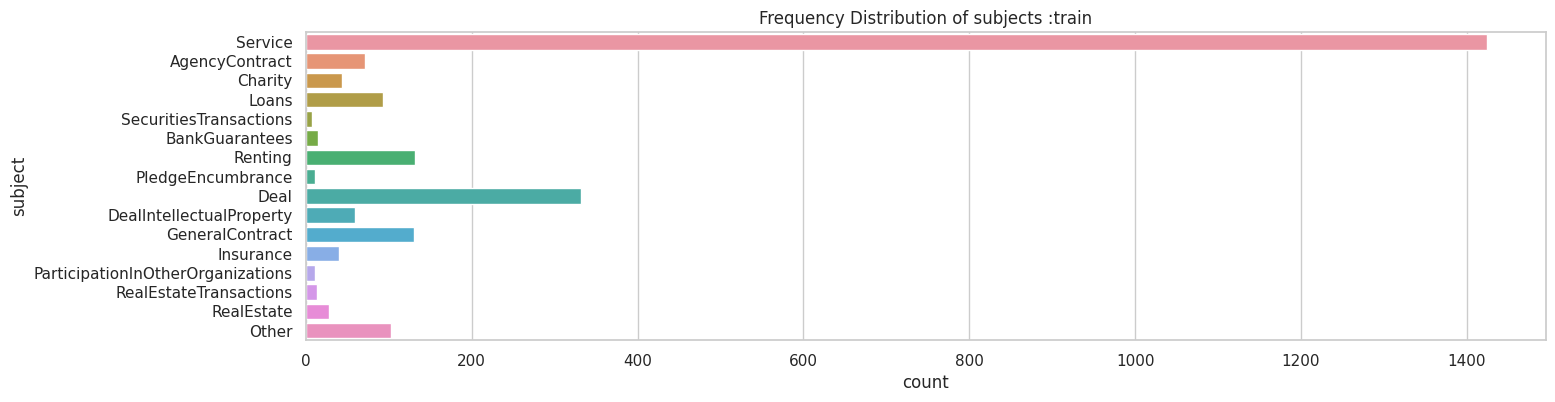

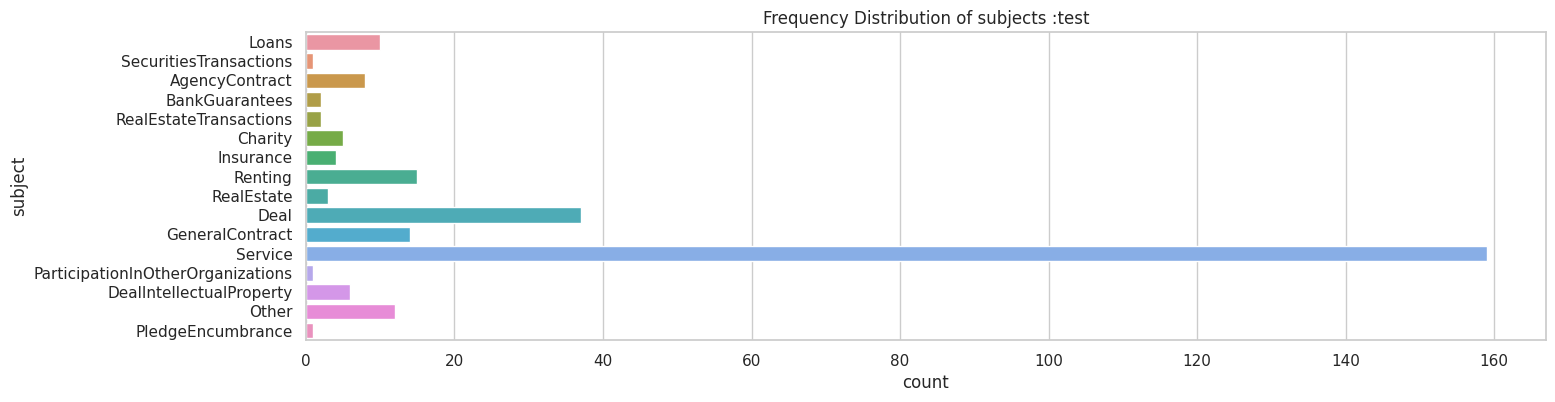

In [37]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [38]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	10052
test_samples:	280
steps_per_epoch:	104
validation_steps:	52


# Models 🦖

In [39]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [40]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [41]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [42]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [43]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [44]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [45]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-08 22:33:18.645990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-08 22:33:19.163817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 22:33:19.164472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-08 22:33:19.164487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-08 22:33:19.164520: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-08 22:33:19.164536: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [46]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [47]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [48]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [49]:
from dataclasses import dataclass

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}

class ThresholdLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
                                      trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x):
        return keras.backend.sigmoid(100*(x-self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape

def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = layers.LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
#   _out1 = layers.ReLU(name='O1_tagging')(_out)
  _out1 = ThresholdLayer(name='O1_tagging')(_out)
  

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = layers.Bidirectional(layers.LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(
    _out)
  _out = layers.BatchNormalization(name="bn_bi_2")(_out)
  _out = layers.Dropout(0.1)(_out)

  _out2 = layers.Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


umodel = make_att_model() 

model_factory_fn=make_att_model      
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__


umodel.load_weights(weights, by_name=True, skip_mismatch=True)

# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/make_att_model.h5


In [50]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

threshold = umodel.get_layer('O1_tagging').get_weights()
print('threshold=',threshold)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-08 22:33:22.854936: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-08 22:33:22.877919: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-08 22:33:25.655021: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-08 22:33:26.724865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-08 22:33:26.724908: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-08 22:33:26.808153: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-08 22:33:27.016023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/104 [..............................] - ETA: 8:14 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0085

  2/104 [..............................] - ETA: 11s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0099 

  3/104 [..............................] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0092

  4/104 [>.............................] - ETA: 1:03 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0095

  5/104 [>.............................] - ETA: 1:11 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0096

  6/104 [>.............................] - ETA: 1:24 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

  7/104 [=>............................] - ETA: 1:37 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

  8/104 [=>............................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0101

  9/104 [=>............................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 10/104 [=>............................] - ETA: 1:45 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

 11/104 [==>...........................] - ETA: 1:53 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

 12/104 [==>...........................] - ETA: 1:49 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 14/104 [===>..........................] - ETA: 1:57 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 15/104 [===>..........................] - ETA: 1:58 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 18/104 [====>.........................] - ETA: 1:48 - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 19/104 [====>.........................] - ETA: 1:45 - loss: 0.0105 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

 20/104 [====>.........................] - ETA: 1:44 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 21/104 [=====>........................] - ETA: 1:40 - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 22/104 [=====>........................] - ETA: 1:39 - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 23/104 [=====>........................] - ETA: 1:39 - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 24/104 [=====>........................] - ETA: 1:36 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 25/104 [======>.......................] - ETA: 1:35 - loss: 0.0109 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 26/104 [======>.......................] - ETA: 1:33 - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 27/104 [======>.......................] - ETA: 1:32 - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 28/104 [=======>......................] - ETA: 1:31 - loss: 0.0109 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 29/104 [=======>......................] - ETA: 1:30 - loss: 0.0109 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 30/104 [=======>......................] - ETA: 1:31 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 31/104 [=======>......................] - ETA: 1:30 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 32/104 [========>.....................] - ETA: 1:29 - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 33/104 [========>.....................] - ETA: 1:28 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 34/104 [========>.....................] - ETA: 1:26 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 35/104 [=========>....................] - ETA: 1:25 - loss: 0.0107 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 36/104 [=========>....................] - ETA: 1:23 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 37/104 [=========>....................] - ETA: 1:21 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 38/104 [=========>....................] - ETA: 1:19 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 39/104 [==========>...................] - ETA: 1:18 - loss: 0.0106 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 40/104 [==========>...................] - ETA: 1:18 - loss: 0.0106 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 41/104 [==========>...................] - ETA: 1:15 - loss: 0.0106 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 42/104 [===========>..................] - ETA: 1:14 - loss: 0.0106 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 43/104 [===========>..................] - ETA: 1:12 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 44/104 [===========>..................] - ETA: 1:11 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 45/104 [===========>..................] - ETA: 1:11 - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 46/104 [============>.................] - ETA: 1:10 - loss: 0.0106 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 47/104 [============>.................] - ETA: 1:08 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 48/104 [============>.................] - ETA: 1:07 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 49/104 [=============>................] - ETA: 1:06 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 50/104 [=============>................] - ETA: 1:05 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 51/104 [=============>................] - ETA: 1:04 - loss: 0.0105 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 52/104 [==============>...............] - ETA: 1:04 - loss: 0.0105 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 53/104 [==============>...............] - ETA: 1:03 - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 55/104 [==============>...............] - ETA: 1:02 - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 56/104 [===============>..............] - ETA: 1:00 - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 57/104 [===============>..............] - ETA: 59s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108 

 58/104 [===============>..............] - ETA: 58s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 59/104 [================>.............] - ETA: 57s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 60/104 [================>.............] - ETA: 55s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 61/104 [================>.............] - ETA: 54s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 62/104 [================>.............] - ETA: 53s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 63/104 [=================>............] - ETA: 52s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 64/104 [=================>............] - ETA: 50s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 65/104 [=================>............] - ETA: 49s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 66/104 [==================>...........] - ETA: 47s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 67/104 [==================>...........] - ETA: 46s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 68/104 [==================>...........] - ETA: 45s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 69/104 [==================>...........] - ETA: 43s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 70/104 [===================>..........] - ETA: 42s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 71/104 [===================>..........] - ETA: 41s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 72/104 [===================>..........] - ETA: 40s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 73/104 [====================>.........] - ETA: 38s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 74/104 [====================>.........] - ETA: 37s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 75/104 [====================>.........] - ETA: 36s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 76/104 [====================>.........] - ETA: 35s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 77/104 [=====================>........] - ETA: 34s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 78/104 [=====================>........] - ETA: 32s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 79/104 [=====================>........] - ETA: 31s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 80/104 [======================>.......] - ETA: 30s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 81/104 [======================>.......] - ETA: 29s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 82/104 [======================>.......] - ETA: 27s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 83/104 [======================>.......] - ETA: 26s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 84/104 [=======================>......] - ETA: 25s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 85/104 [=======================>......] - ETA: 23s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 86/104 [=======================>......] - ETA: 22s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 87/104 [========================>.....] - ETA: 21s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 88/104 [========================>.....] - ETA: 20s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 89/104 [========================>.....] - ETA: 19s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 90/104 [========================>.....] - ETA: 17s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 91/104 [=========================>....] - ETA: 16s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 92/104 [=========================>....] - ETA: 15s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 93/104 [=========================>....] - ETA: 14s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 94/104 [==========================>...] - ETA: 12s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 95/104 [==========================>...] - ETA: 11s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 96/104 [==========================>...] - ETA: 10s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 97/104 [==========================>...] - ETA: 8s - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 99/104 [===========================>..] - ETA: 6s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

100/104 [===========================>..] - ETA: 5s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

101/104 [============================>.] - ETA: 3s - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

102/104 [============================>.] - ETA: 2s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

103/104 [============================>.] - ETA: 1s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

104/104 [==============================] - ETA: 0s - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

104/104 [==============================] - 225s 2s/step - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109 - val_loss: 0.0138 - val_O1_tagging_loss: 0.0061 - val_O2_subject_loss: 0.0077 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0079 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0074



Epoch 00001: val_loss improved from inf to 0.01376, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/104 [..............................] - ETA: 33s - loss: 0.0068 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

  2/104 [..............................] - ETA: 2:16 - loss: 0.0073 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

  3/104 [..............................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  4/104 [>.............................] - ETA: 2:07 - loss: 0.0096 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

  5/104 [>.............................] - ETA: 2:03 - loss: 0.0094 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0107

  6/104 [>.............................] - ETA: 1:51 - loss: 0.0100 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

  7/104 [=>............................] - ETA: 1:55 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

  8/104 [=>............................] - ETA: 1:51 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

  9/104 [=>............................] - ETA: 1:58 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 10/104 [=>............................] - ETA: 1:58 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 11/104 [==>...........................] - ETA: 1:54 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 12/104 [==>...........................] - ETA: 2:03 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0109

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 15/104 [===>..........................] - ETA: 1:56 - loss: 0.0095 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 16/104 [===>..........................] - ETA: 1:55 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 17/104 [===>..........................] - ETA: 1:52 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 18/104 [====>.........................] - ETA: 1:50 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 19/104 [====>.........................] - ETA: 1:51 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 20/104 [====>.........................] - ETA: 1:50 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 22/104 [=====>........................] - ETA: 1:47 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 23/104 [=====>........................] - ETA: 1:45 - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 24/104 [=====>........................] - ETA: 1:42 - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 25/104 [======>.......................] - ETA: 1:43 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 26/104 [======>.......................] - ETA: 1:40 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 28/104 [=======>......................] - ETA: 1:37 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 32/104 [========>.....................] - ETA: 1:35 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 33/104 [========>.....................] - ETA: 1:36 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 34/104 [========>.....................] - ETA: 1:34 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 38/104 [=========>....................] - ETA: 1:28 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 39/104 [==========>...................] - ETA: 1:26 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 40/104 [==========>...................] - ETA: 1:25 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 43/104 [===========>..................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 44/104 [===========>..................] - ETA: 1:21 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 45/104 [===========>..................] - ETA: 1:20 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 47/104 [============>.................] - ETA: 1:17 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 48/104 [============>.................] - ETA: 1:16 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 60/104 [================>.............] - ETA: 59s - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 61/104 [================>.............] - ETA: 58s - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 62/104 [================>.............] - ETA: 57s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 63/104 [=================>............] - ETA: 56s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 64/104 [=================>............] - ETA: 54s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 65/104 [=================>............] - ETA: 52s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 66/104 [==================>...........] - ETA: 52s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 67/104 [==================>...........] - ETA: 50s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 68/104 [==================>...........] - ETA: 49s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 69/104 [==================>...........] - ETA: 47s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 70/104 [===================>..........] - ETA: 46s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 71/104 [===================>..........] - ETA: 45s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 72/104 [===================>..........] - ETA: 43s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 73/104 [====================>.........] - ETA: 42s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 74/104 [====================>.........] - ETA: 41s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 75/104 [====================>.........] - ETA: 39s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 76/104 [====================>.........] - ETA: 38s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 77/104 [=====================>........] - ETA: 36s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/104 [=====================>........] - ETA: 35s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 79/104 [=====================>........] - ETA: 34s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 80/104 [======================>.......] - ETA: 32s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 81/104 [======================>.......] - ETA: 31s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 82/104 [======================>.......] - ETA: 29s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 83/104 [======================>.......] - ETA: 28s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 84/104 [=======================>......] - ETA: 27s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 85/104 [=======================>......] - ETA: 25s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 86/104 [=======================>......] - ETA: 24s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 87/104 [========================>.....] - ETA: 23s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 88/104 [========================>.....] - ETA: 21s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 89/104 [========================>.....] - ETA: 20s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 90/104 [========================>.....] - ETA: 19s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 91/104 [=========================>....] - ETA: 17s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 92/104 [=========================>....] - ETA: 16s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 93/104 [=========================>....] - ETA: 14s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 94/104 [==========================>...] - ETA: 13s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 95/104 [==========================>...] - ETA: 12s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 96/104 [==========================>...] - ETA: 10s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 97/104 [==========================>...] - ETA: 9s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 99/104 [===========================>..] - ETA: 6s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

100/104 [===========================>..] - ETA: 5s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

101/104 [============================>.] - ETA: 4s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

102/104 [============================>.] - ETA: 2s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

103/104 [============================>.] - ETA: 1s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

104/104 [==============================] - ETA: 0s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

104/104 [==============================] - 222s 2s/step - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101 - val_loss: 0.0105 - val_O1_tagging_loss: 0.0057 - val_O2_subject_loss: 0.0048 - val_O1_tagging_mse: 9.7328e-04 - val_O1_tagging_binary_crossentropy: 0.0073 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0045



Epoch 00002: val_loss improved from 0.01376 to 0.01054, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50


  1/104 [..............................] - ETA: 26s - loss: 0.0082 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0048 - O1_tagging_mse: 8.8957e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

  2/104 [..............................] - ETA: 2:34 - loss: 0.0094 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0063 - O1_tagging_mse: 9.2606e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

  3/104 [..............................] - ETA: 2:19 - loss: 0.0112 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0117    

  4/104 [>.............................] - ETA: 2:09 - loss: 0.0108 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  5/104 [>.............................] - ETA: 2:21 - loss: 0.0100 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

  6/104 [>.............................] - ETA: 2:08 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

  7/104 [=>............................] - ETA: 2:25 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

  8/104 [=>............................] - ETA: 2:16 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

  9/104 [=>............................] - ETA: 2:13 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 10/104 [=>............................] - ETA: 2:08 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 11/104 [==>...........................] - ETA: 2:13 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 12/104 [==>...........................] - ETA: 2:08 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

 13/104 [==>...........................] - ETA: 2:04 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 14/104 [===>..........................] - ETA: 2:07 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 15/104 [===>..........................] - ETA: 2:05 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 16/104 [===>..........................] - ETA: 2:03 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 17/104 [===>..........................] - ETA: 2:03 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 18/104 [====>.........................] - ETA: 1:59 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 19/104 [====>.........................] - ETA: 1:56 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 20/104 [====>.........................] - ETA: 1:52 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 21/104 [=====>........................] - ETA: 1:52 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0110

 22/104 [=====>........................] - ETA: 1:51 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 25/104 [======>.......................] - ETA: 1:47 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 26/104 [======>.......................] - ETA: 1:46 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 28/104 [=======>......................] - ETA: 1:42 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 29/104 [=======>......................] - ETA: 1:41 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 37/104 [=========>....................] - ETA: 1:28 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 38/104 [=========>....................] - ETA: 1:26 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 39/104 [==========>...................] - ETA: 1:25 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 40/104 [==========>...................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 41/104 [==========>...................] - ETA: 1:21 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 42/104 [===========>..................] - ETA: 1:21 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 51/104 [=============>................] - ETA: 1:10 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 52/104 [==============>...............] - ETA: 1:08 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 54/104 [==============>...............] - ETA: 1:05 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 58/104 [===============>..............] - ETA: 59s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101 

 59/104 [================>.............] - ETA: 58s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 60/104 [================>.............] - ETA: 57s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 61/104 [================>.............] - ETA: 55s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 62/104 [================>.............] - ETA: 54s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 63/104 [=================>............] - ETA: 53s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 64/104 [=================>............] - ETA: 52s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 65/104 [=================>............] - ETA: 50s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 66/104 [==================>...........] - ETA: 49s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 67/104 [==================>...........] - ETA: 48s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 68/104 [==================>...........] - ETA: 46s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 69/104 [==================>...........] - ETA: 45s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 70/104 [===================>..........] - ETA: 44s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 71/104 [===================>..........] - ETA: 42s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 72/104 [===================>..........] - ETA: 41s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 73/104 [====================>.........] - ETA: 40s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 74/104 [====================>.........] - ETA: 38s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 75/104 [====================>.........] - ETA: 37s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 76/104 [====================>.........] - ETA: 36s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 77/104 [=====================>........] - ETA: 35s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 78/104 [=====================>........] - ETA: 33s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 79/104 [=====================>........] - ETA: 32s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 80/104 [======================>.......] - ETA: 31s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 81/104 [======================>.......] - ETA: 30s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 82/104 [======================>.......] - ETA: 28s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 83/104 [======================>.......] - ETA: 27s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 84/104 [=======================>......] - ETA: 26s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 85/104 [=======================>......] - ETA: 24s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 86/104 [=======================>......] - ETA: 23s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 87/104 [========================>.....] - ETA: 22s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 88/104 [========================>.....] - ETA: 20s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 89/104 [========================>.....] - ETA: 19s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 90/104 [========================>.....] - ETA: 18s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 91/104 [=========================>....] - ETA: 16s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 92/104 [=========================>....] - ETA: 15s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 93/104 [=========================>....] - ETA: 14s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 94/104 [==========================>...] - ETA: 12s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 95/104 [==========================>...] - ETA: 11s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 96/104 [==========================>...] - ETA: 10s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 97/104 [==========================>...] - ETA: 9s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 99/104 [===========================>..] - ETA: 6s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

100/104 [===========================>..] - ETA: 5s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

101/104 [============================>.] - ETA: 3s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

102/104 [============================>.] - ETA: 2s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

103/104 [============================>.] - ETA: 1s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

104/104 [==============================] - ETA: 0s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

104/104 [==============================] - 221s 2s/step - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102 - val_loss: 0.0118 - val_O1_tagging_loss: 0.0054 - val_O2_subject_loss: 0.0064 - val_O1_tagging_mse: 9.1849e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0055



Epoch 00003: val_loss did not improve from 0.01054
Epoch 4/50


  1/104 [..............................] - ETA: 37s - loss: 0.0121 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0073 - O1_tagging_mse: 8.6485e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

  2/104 [..............................] - ETA: 1:18 - loss: 0.0093 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0119   

  3/104 [..............................] - ETA: 1:59 - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 9.7048e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

  4/104 [>.............................] - ETA: 1:45 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104    

  5/104 [>.............................] - ETA: 1:54 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

  6/104 [>.............................] - ETA: 1:50 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

  7/104 [=>............................] - ETA: 1:56 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

  8/104 [=>............................] - ETA: 2:04 - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

  9/104 [=>............................] - ETA: 2:08 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0100

 10/104 [=>............................] - ETA: 2:04 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 11/104 [==>...........................] - ETA: 2:04 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 12/104 [==>...........................] - ETA: 2:00 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 13/104 [==>...........................] - ETA: 1:58 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 15/104 [===>..........................] - ETA: 2:00 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 16/104 [===>..........................] - ETA: 1:58 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 17/104 [===>..........................] - ETA: 1:54 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 18/104 [====>.........................] - ETA: 1:54 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 20/104 [====>.........................] - ETA: 1:54 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 21/104 [=====>........................] - ETA: 1:50 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 22/104 [=====>........................] - ETA: 1:50 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 23/104 [=====>........................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 24/104 [=====>........................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

 25/104 [======>.......................] - ETA: 1:45 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 26/104 [======>.......................] - ETA: 1:44 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 27/104 [======>.......................] - ETA: 1:44 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 28/104 [=======>......................] - ETA: 1:43 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 29/104 [=======>......................] - ETA: 1:40 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 34/104 [========>.....................] - ETA: 1:33 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 35/104 [=========>....................] - ETA: 1:30 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 37/104 [=========>....................] - ETA: 1:28 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 38/104 [=========>....................] - ETA: 1:27 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 40/104 [==========>...................] - ETA: 1:26 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 44/104 [===========>..................] - ETA: 1:19 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 49/104 [=============>................] - ETA: 1:13 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 51/104 [=============>................] - ETA: 1:09 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 52/104 [==============>...............] - ETA: 1:08 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 54/104 [==============>...............] - ETA: 1:05 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 55/104 [==============>...............] - ETA: 1:05 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 57/104 [===============>..............] - ETA: 1:02 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 60/104 [================>.............] - ETA: 59s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 61/104 [================>.............] - ETA: 58s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 62/104 [================>.............] - ETA: 56s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 63/104 [=================>............] - ETA: 55s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 64/104 [=================>............] - ETA: 53s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 65/104 [=================>............] - ETA: 52s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 66/104 [==================>...........] - ETA: 51s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 67/104 [==================>...........] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 68/104 [==================>...........] - ETA: 47s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/104 [==================>...........] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/104 [===================>..........] - ETA: 45s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 71/104 [===================>..........] - ETA: 44s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 72/104 [===================>..........] - ETA: 42s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/104 [====================>.........] - ETA: 41s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 74/104 [====================>.........] - ETA: 40s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 75/104 [====================>.........] - ETA: 38s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 37s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 36s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/104 [=====================>........] - ETA: 35s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/104 [=====================>........] - ETA: 33s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/104 [======================>.......] - ETA: 32s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 81/104 [======================>.......] - ETA: 30s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/104 [======================>.......] - ETA: 29s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/104 [======================>.......] - ETA: 27s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/104 [=======================>......] - ETA: 26s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 85/104 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 86/104 [=======================>......] - ETA: 24s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 87/104 [========================>.....] - ETA: 23s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/104 [========================>.....] - ETA: 21s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 89/104 [========================>.....] - ETA: 20s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/104 [========================>.....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 91/104 [=========================>....] - ETA: 17s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 92/104 [=========================>....] - ETA: 16s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/104 [=========================>....] - ETA: 14s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 94/104 [==========================>...] - ETA: 13s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 95/104 [==========================>...] - ETA: 12s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 96/104 [==========================>...] - ETA: 10s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 97/104 [==========================>...] - ETA: 9s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 99/104 [===========================>..] - ETA: 6s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

100/104 [===========================>..] - ETA: 5s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

101/104 [============================>.] - ETA: 4s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

102/104 [============================>.] - ETA: 2s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

103/104 [============================>.] - ETA: 1s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

104/104 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

104/104 [==============================] - 224s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096 - val_loss: 0.0106 - val_O1_tagging_loss: 0.0055 - val_O2_subject_loss: 0.0051 - val_O1_tagging_mse: 8.8749e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0044



Epoch 00004: val_loss did not improve from 0.01054
Epoch 5/50


  1/104 [..............................] - ETA: 44s - loss: 0.0112 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0074 - O1_tagging_mse: 9.0075e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0107

  2/104 [..............................] - ETA: 2:24 - loss: 0.0095 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091   

  3/104 [..............................] - ETA: 1:55 - loss: 0.0090 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

  4/104 [>.............................] - ETA: 2:00 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

  5/104 [>.............................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

  6/104 [>.............................] - ETA: 1:56 - loss: 0.0095 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  7/104 [=>............................] - ETA: 1:49 - loss: 0.0095 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

  8/104 [=>............................] - ETA: 1:59 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

  9/104 [=>............................] - ETA: 2:00 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 10/104 [=>............................] - ETA: 2:03 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 11/104 [==>...........................] - ETA: 2:03 - loss: 0.0090 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 12/104 [==>...........................] - ETA: 2:02 - loss: 0.0088 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 13/104 [==>...........................] - ETA: 2:04 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 14/104 [===>..........................] - ETA: 2:06 - loss: 0.0088 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 15/104 [===>..........................] - ETA: 2:03 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 2:01 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 17/104 [===>..........................] - ETA: 2:01 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 18/104 [====>.........................] - ETA: 2:01 - loss: 0.0092 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 19/104 [====>.........................] - ETA: 1:57 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 20/104 [====>.........................] - ETA: 1:54 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 21/104 [=====>........................] - ETA: 1:51 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 22/104 [=====>........................] - ETA: 1:50 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 23/104 [=====>........................] - ETA: 1:50 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 24/104 [=====>........................] - ETA: 1:47 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 25/104 [======>.......................] - ETA: 1:48 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 26/104 [======>.......................] - ETA: 1:45 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 28/104 [=======>......................] - ETA: 1:42 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 30/104 [=======>......................] - ETA: 1:38 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 31/104 [=======>......................] - ETA: 1:38 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 34/104 [========>.....................] - ETA: 1:33 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 37/104 [=========>....................] - ETA: 1:28 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 38/104 [=========>....................] - ETA: 1:27 - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 39/104 [==========>...................] - ETA: 1:26 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 40/104 [==========>...................] - ETA: 1:24 - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 41/104 [==========>...................] - ETA: 1:23 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 42/104 [===========>..................] - ETA: 1:22 - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 44/104 [===========>..................] - ETA: 1:20 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 50/104 [=============>................] - ETA: 1:10 - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 51/104 [=============>................] - ETA: 1:09 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0101 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 54/104 [==============>...............] - ETA: 1:04 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 55/104 [==============>...............] - ETA: 1:03 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 58/104 [===============>..............] - ETA: 59s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105 

 59/104 [================>.............] - ETA: 57s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 60/104 [================>.............] - ETA: 56s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 61/104 [================>.............] - ETA: 55s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 62/104 [================>.............] - ETA: 54s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 63/104 [=================>............] - ETA: 52s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 64/104 [=================>............] - ETA: 51s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 65/104 [=================>............] - ETA: 49s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 66/104 [==================>...........] - ETA: 48s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 67/104 [==================>...........] - ETA: 47s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 68/104 [==================>...........] - ETA: 46s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 69/104 [==================>...........] - ETA: 45s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 70/104 [===================>..........] - ETA: 43s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 71/104 [===================>..........] - ETA: 42s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 72/104 [===================>..........] - ETA: 41s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 73/104 [====================>.........] - ETA: 39s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 74/104 [====================>.........] - ETA: 38s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 75/104 [====================>.........] - ETA: 36s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 76/104 [====================>.........] - ETA: 35s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 77/104 [=====================>........] - ETA: 34s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 78/104 [=====================>........] - ETA: 33s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 79/104 [=====================>........] - ETA: 32s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 80/104 [======================>.......] - ETA: 30s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 81/104 [======================>.......] - ETA: 29s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

 82/104 [======================>.......] - ETA: 28s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 83/104 [======================>.......] - ETA: 27s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 84/104 [=======================>......] - ETA: 25s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

 85/104 [=======================>......] - ETA: 24s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 86/104 [=======================>......] - ETA: 23s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 87/104 [========================>.....] - ETA: 21s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 88/104 [========================>.....] - ETA: 20s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 89/104 [========================>.....] - ETA: 19s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 90/104 [========================>.....] - ETA: 18s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 91/104 [=========================>....] - ETA: 16s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 92/104 [=========================>....] - ETA: 15s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 93/104 [=========================>....] - ETA: 14s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 94/104 [==========================>...] - ETA: 12s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 95/104 [==========================>...] - ETA: 11s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 96/104 [==========================>...] - ETA: 10s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 97/104 [==========================>...] - ETA: 9s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 99/104 [===========================>..] - ETA: 6s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

100/104 [===========================>..] - ETA: 5s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

101/104 [============================>.] - ETA: 3s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

102/104 [============================>.] - ETA: 2s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

103/104 [============================>.] - ETA: 1s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

104/104 [==============================] - ETA: 0s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

104/104 [==============================] - 219s 2s/step - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105 - val_loss: 0.0136 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0059 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0100 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0053



Epoch 00005: val_loss did not improve from 0.01054
Epoch 6/50


  1/104 [..............................] - ETA: 31s - loss: 0.0115 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0093

  2/104 [..............................] - ETA: 2:19 - loss: 0.0111 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0067 - O1_tagging_mse: 9.7030e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

  3/104 [..............................] - ETA: 2:09 - loss: 0.0111 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0063 - O1_tagging_mse: 9.8350e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

  4/104 [>.............................] - ETA: 2:00 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127    

  5/104 [>.............................] - ETA: 2:07 - loss: 0.0106 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0134

  6/104 [>.............................] - ETA: 2:08 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0127

  7/104 [=>............................] - ETA: 2:07 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0126

  8/104 [=>............................] - ETA: 2:06 - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0132

  9/104 [=>............................] - ETA: 2:06 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0130

 10/104 [=>............................] - ETA: 2:03 - loss: 0.0105 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0125

 11/104 [==>...........................] - ETA: 2:01 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0122

 12/104 [==>...........................] - ETA: 1:57 - loss: 0.0103 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0121

 13/104 [==>...........................] - ETA: 1:54 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0119

 14/104 [===>..........................] - ETA: 1:54 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0117

 15/104 [===>..........................] - ETA: 1:51 - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 16/104 [===>..........................] - ETA: 1:55 - loss: 0.0104 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 17/104 [===>..........................] - ETA: 1:59 - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 18/104 [====>.........................] - ETA: 1:54 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 19/104 [====>.........................] - ETA: 1:52 - loss: 0.0104 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 20/104 [====>.........................] - ETA: 1:52 - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 21/104 [=====>........................] - ETA: 1:48 - loss: 0.0104 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 22/104 [=====>........................] - ETA: 1:47 - loss: 0.0104 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 23/104 [=====>........................] - ETA: 1:45 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 24/104 [=====>........................] - ETA: 1:44 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 25/104 [======>.......................] - ETA: 1:43 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 26/104 [======>.......................] - ETA: 1:40 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 28/104 [=======>......................] - ETA: 1:38 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 29/104 [=======>......................] - ETA: 1:37 - loss: 0.0103 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 31/104 [=======>......................] - ETA: 1:36 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 32/104 [========>.....................] - ETA: 1:33 - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 37/104 [=========>....................] - ETA: 1:27 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 39/104 [==========>...................] - ETA: 1:24 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 40/104 [==========>...................] - ETA: 1:22 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 41/104 [==========>...................] - ETA: 1:22 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 42/104 [===========>..................] - ETA: 1:22 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 43/104 [===========>..................] - ETA: 1:20 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 50/104 [=============>................] - ETA: 1:12 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 51/104 [=============>................] - ETA: 1:10 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 52/104 [==============>...............] - ETA: 1:08 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 59/104 [================>.............] - ETA: 58s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107 

 60/104 [================>.............] - ETA: 57s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 61/104 [================>.............] - ETA: 56s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 62/104 [================>.............] - ETA: 55s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 63/104 [=================>............] - ETA: 53s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 64/104 [=================>............] - ETA: 52s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 65/104 [=================>............] - ETA: 51s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 66/104 [==================>...........] - ETA: 49s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 67/104 [==================>...........] - ETA: 48s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 68/104 [==================>...........] - ETA: 46s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 69/104 [==================>...........] - ETA: 45s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 70/104 [===================>..........] - ETA: 43s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 71/104 [===================>..........] - ETA: 42s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 72/104 [===================>..........] - ETA: 41s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 73/104 [====================>.........] - ETA: 40s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 74/104 [====================>.........] - ETA: 39s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 75/104 [====================>.........] - ETA: 37s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 76/104 [====================>.........] - ETA: 36s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 77/104 [=====================>........] - ETA: 35s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 78/104 [=====================>........] - ETA: 33s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 79/104 [=====================>........] - ETA: 32s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 80/104 [======================>.......] - ETA: 31s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 81/104 [======================>.......] - ETA: 29s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 82/104 [======================>.......] - ETA: 28s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 83/104 [======================>.......] - ETA: 27s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 84/104 [=======================>......] - ETA: 25s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 85/104 [=======================>......] - ETA: 24s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 86/104 [=======================>......] - ETA: 23s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 87/104 [========================>.....] - ETA: 22s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 88/104 [========================>.....] - ETA: 20s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 89/104 [========================>.....] - ETA: 19s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 90/104 [========================>.....] - ETA: 18s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 91/104 [=========================>....] - ETA: 16s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 92/104 [=========================>....] - ETA: 15s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 93/104 [=========================>....] - ETA: 14s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 94/104 [==========================>...] - ETA: 12s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 95/104 [==========================>...] - ETA: 11s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 96/104 [==========================>...] - ETA: 10s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 97/104 [==========================>...] - ETA: 9s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 99/104 [===========================>..] - ETA: 6s - loss: 0.0104 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

100/104 [===========================>..] - ETA: 5s - loss: 0.0104 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

101/104 [============================>.] - ETA: 3s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

102/104 [============================>.] - ETA: 2s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

103/104 [============================>.] - ETA: 1s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

104/104 [==============================] - ETA: 0s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

104/104 [==============================] - 222s 2s/step - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105 - val_loss: 0.0174 - val_O1_tagging_loss: 0.0055 - val_O2_subject_loss: 0.0120 - val_O1_tagging_mse: 9.8038e-04 - val_O1_tagging_binary_crossentropy: 0.0072 - val_O2_subject_mse: 0.0031 - val_O2_subject_binary_crossentropy: 0.0130



Epoch 00006: val_loss did not improve from 0.01054
Epoch 7/50


  1/104 [..............................] - ETA: 40s - loss: 0.0119 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0125

  2/104 [..............................] - ETA: 1:46 - loss: 0.0106 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0118

  3/104 [..............................] - ETA: 2:00 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0119

  4/104 [>.............................] - ETA: 2:12 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

  5/104 [>.............................] - ETA: 2:07 - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0104

  6/104 [>.............................] - ETA: 1:58 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

  7/104 [=>............................] - ETA: 1:59 - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0105

  8/104 [=>............................] - ETA: 1:59 - loss: 0.0105 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0106

  9/104 [=>............................] - ETA: 1:55 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0110

 10/104 [=>............................] - ETA: 1:59 - loss: 0.0105 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 11/104 [==>...........................] - ETA: 2:00 - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 12/104 [==>...........................] - ETA: 1:53 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 13/104 [==>...........................] - ETA: 1:49 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

 14/104 [===>..........................] - ETA: 1:48 - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0113

 15/104 [===>..........................] - ETA: 1:52 - loss: 0.0110 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 16/104 [===>..........................] - ETA: 1:48 - loss: 0.0108 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 17/104 [===>..........................] - ETA: 1:50 - loss: 0.0107 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 18/104 [====>.........................] - ETA: 1:47 - loss: 0.0106 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 19/104 [====>.........................] - ETA: 1:46 - loss: 0.0106 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 20/104 [====>.........................] - ETA: 1:43 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 21/104 [=====>........................] - ETA: 1:44 - loss: 0.0106 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 22/104 [=====>........................] - ETA: 1:41 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 23/104 [=====>........................] - ETA: 1:40 - loss: 0.0105 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 24/104 [=====>........................] - ETA: 1:40 - loss: 0.0105 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 25/104 [======>.......................] - ETA: 1:37 - loss: 0.0104 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 26/104 [======>.......................] - ETA: 1:37 - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 27/104 [======>.......................] - ETA: 1:35 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 28/104 [=======>......................] - ETA: 1:34 - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 29/104 [=======>......................] - ETA: 1:33 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 30/104 [=======>......................] - ETA: 1:31 - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 31/104 [=======>......................] - ETA: 1:30 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 32/104 [========>.....................] - ETA: 1:30 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 33/104 [========>.....................] - ETA: 1:28 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 34/104 [========>.....................] - ETA: 1:27 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/104 [=========>....................] - ETA: 1:26 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 36/104 [=========>....................] - ETA: 1:25 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 37/104 [=========>....................] - ETA: 1:24 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 38/104 [=========>....................] - ETA: 1:22 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 39/104 [==========>...................] - ETA: 1:21 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 40/104 [==========>...................] - ETA: 1:19 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 41/104 [==========>...................] - ETA: 1:17 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 42/104 [===========>..................] - ETA: 1:16 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 43/104 [===========>..................] - ETA: 1:14 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 44/104 [===========>..................] - ETA: 1:13 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 45/104 [===========>..................] - ETA: 1:13 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 46/104 [============>.................] - ETA: 1:12 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 47/104 [============>.................] - ETA: 1:11 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 48/104 [============>.................] - ETA: 1:09 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 49/104 [=============>................] - ETA: 1:08 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 50/104 [=============>................] - ETA: 1:07 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 51/104 [=============>................] - ETA: 1:05 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 52/104 [==============>...............] - ETA: 1:04 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 53/104 [==============>...............] - ETA: 1:03 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 55/104 [==============>...............] - ETA: 1:01 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 56/104 [===============>..............] - ETA: 1:00 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 57/104 [===============>..............] - ETA: 58s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 58/104 [===============>..............] - ETA: 57s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 59/104 [================>.............] - ETA: 56s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 60/104 [================>.............] - ETA: 55s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 61/104 [================>.............] - ETA: 54s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 62/104 [================>.............] - ETA: 53s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 63/104 [=================>............] - ETA: 51s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 64/104 [=================>............] - ETA: 50s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 65/104 [=================>............] - ETA: 49s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 66/104 [==================>...........] - ETA: 47s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 67/104 [==================>...........] - ETA: 46s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 68/104 [==================>...........] - ETA: 45s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 69/104 [==================>...........] - ETA: 44s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 70/104 [===================>..........] - ETA: 43s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 71/104 [===================>..........] - ETA: 42s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 72/104 [===================>..........] - ETA: 40s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 73/104 [====================>.........] - ETA: 39s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 74/104 [====================>.........] - ETA: 37s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 75/104 [====================>.........] - ETA: 36s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 76/104 [====================>.........] - ETA: 35s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 77/104 [=====================>........] - ETA: 34s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 78/104 [=====================>........] - ETA: 32s - loss: 0.0099 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 79/104 [=====================>........] - ETA: 31s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 80/104 [======================>.......] - ETA: 30s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 81/104 [======================>.......] - ETA: 29s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 82/104 [======================>.......] - ETA: 27s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 83/104 [======================>.......] - ETA: 26s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 84/104 [=======================>......] - ETA: 25s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 85/104 [=======================>......] - ETA: 23s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 86/104 [=======================>......] - ETA: 22s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 87/104 [========================>.....] - ETA: 21s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 88/104 [========================>.....] - ETA: 20s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 89/104 [========================>.....] - ETA: 18s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 90/104 [========================>.....] - ETA: 17s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 91/104 [=========================>....] - ETA: 16s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 92/104 [=========================>....] - ETA: 15s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 93/104 [=========================>....] - ETA: 13s - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 94/104 [==========================>...] - ETA: 12s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 95/104 [==========================>...] - ETA: 11s - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 96/104 [==========================>...] - ETA: 10s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 97/104 [==========================>...] - ETA: 8s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 99/104 [===========================>..] - ETA: 6s - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

100/104 [===========================>..] - ETA: 5s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

101/104 [============================>.] - ETA: 3s - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

102/104 [============================>.] - ETA: 2s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

103/104 [============================>.] - ETA: 1s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

104/104 [==============================] - ETA: 0s - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

104/104 [==============================] - 213s 2s/step - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097 - val_loss: 0.0145 - val_O1_tagging_loss: 0.0060 - val_O2_subject_loss: 0.0084 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0074 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00007: val_loss did not improve from 0.01054
Epoch 8/50
  1/104 [..............................] - ETA: 15s - loss: 0.0119 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0149

  2/104 [..............................] - ETA: 3:01 - loss: 0.0097 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0129

  3/104 [..............................] - ETA: 2:46 - loss: 0.0097 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7138e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

  4/104 [>.............................] - ETA: 2:40 - loss: 0.0106 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.8767e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

  5/104 [>.............................] - ETA: 2:16 - loss: 0.0103 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105    

  6/104 [>.............................] - ETA: 2:16 - loss: 0.0099 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  7/104 [=>............................] - ETA: 2:09 - loss: 0.0096 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

  8/104 [=>............................] - ETA: 2:10 - loss: 0.0098 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/104 [=>............................] - ETA: 2:12 - loss: 0.0094 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 10/104 [=>............................] - ETA: 2:15 - loss: 0.0096 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 11/104 [==>...........................] - ETA: 2:10 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 12/104 [==>...........................] - ETA: 2:05 - loss: 0.0092 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 14/104 [===>..........................] - ETA: 2:02 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 15/104 [===>..........................] - ETA: 2:05 - loss: 0.0092 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 16/104 [===>..........................] - ETA: 2:01 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 17/104 [===>..........................] - ETA: 1:59 - loss: 0.0088 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 18/104 [====>.........................] - ETA: 1:55 - loss: 0.0088 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 19/104 [====>.........................] - ETA: 1:54 - loss: 0.0088 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 20/104 [====>.........................] - ETA: 1:53 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 21/104 [=====>........................] - ETA: 1:56 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 22/104 [=====>........................] - ETA: 1:55 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 23/104 [=====>........................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 24/104 [=====>........................] - ETA: 1:50 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 25/104 [======>.......................] - ETA: 1:52 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 26/104 [======>.......................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 27/104 [======>.......................] - ETA: 1:47 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 28/104 [=======>......................] - ETA: 1:44 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 29/104 [=======>......................] - ETA: 1:42 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 30/104 [=======>......................] - ETA: 1:40 - loss: 0.0092 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 31/104 [=======>......................] - ETA: 1:39 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 32/104 [========>.....................] - ETA: 1:37 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 33/104 [========>.....................] - ETA: 1:37 - loss: 0.0092 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 34/104 [========>.....................] - ETA: 1:35 - loss: 0.0091 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0090 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0090 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 38/104 [=========>....................] - ETA: 1:27 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 39/104 [==========>...................] - ETA: 1:25 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 40/104 [==========>...................] - ETA: 1:24 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 43/104 [===========>..................] - ETA: 1:22 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 44/104 [===========>..................] - ETA: 1:21 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 45/104 [===========>..................] - ETA: 1:19 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 46/104 [============>.................] - ETA: 1:18 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 47/104 [============>.................] - ETA: 1:16 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 48/104 [============>.................] - ETA: 1:16 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 50/104 [=============>................] - ETA: 1:12 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 52/104 [==============>...............] - ETA: 1:09 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 60/104 [================>.............] - ETA: 59s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 61/104 [================>.............] - ETA: 57s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 62/104 [================>.............] - ETA: 56s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 63/104 [=================>............] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 64/104 [=================>............] - ETA: 53s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 52s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 66/104 [==================>...........] - ETA: 50s - loss: 0.0087 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 67/104 [==================>...........] - ETA: 48s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 68/104 [==================>...........] - ETA: 47s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 69/104 [==================>...........] - ETA: 46s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 70/104 [===================>..........] - ETA: 44s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 71/104 [===================>..........] - ETA: 43s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 72/104 [===================>..........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 73/104 [====================>.........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 74/104 [====================>.........] - ETA: 39s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 75/104 [====================>.........] - ETA: 37s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 36s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 78/104 [=====================>........] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 79/104 [=====================>........] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 80/104 [======================>.......] - ETA: 31s - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 81/104 [======================>.......] - ETA: 30s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 82/104 [======================>.......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/104 [======================>.......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 84/104 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 85/104 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 86/104 [=======================>......] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 87/104 [========================>.....] - ETA: 22s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 88/104 [========================>.....] - ETA: 21s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 89/104 [========================>.....] - ETA: 19s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 90/104 [========================>.....] - ETA: 18s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 91/104 [=========================>....] - ETA: 17s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 92/104 [=========================>....] - ETA: 15s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 93/104 [=========================>....] - ETA: 14s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 94/104 [==========================>...] - ETA: 13s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 95/104 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 96/104 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 97/104 [==========================>...] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 99/104 [===========================>..] - ETA: 6s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

100/104 [===========================>..] - ETA: 5s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

101/104 [============================>.] - ETA: 3s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

102/104 [============================>.] - ETA: 2s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

103/104 [============================>.] - ETA: 1s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

104/104 [==============================] - ETA: 0s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

104/104 [==============================] - 222s 2s/step - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0118 - val_O1_tagging_loss: 0.0058 - val_O2_subject_loss: 0.0059 - val_O1_tagging_mse: 9.0504e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0047



Epoch 00008: val_loss did not improve from 0.01054
Epoch 9/50


  1/104 [..............................] - ETA: 43s - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 8.6502e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0106

  2/104 [..............................] - ETA: 2:32 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 8.5918e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0089

  3/104 [..............................] - ETA: 2:15 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.0181e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0091

  4/104 [>.............................] - ETA: 2:12 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.5108e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0095

  5/104 [>.............................] - ETA: 2:13 - loss: 0.0094 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0047 - O1_tagging_mse: 9.4403e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0101

  6/104 [>.............................] - ETA: 2:08 - loss: 0.0095 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0047 - O1_tagging_mse: 9.8401e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0099

  7/104 [=>............................] - ETA: 1:59 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100    

  8/104 [=>............................] - ETA: 2:00 - loss: 0.0098 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

  9/104 [=>............................] - ETA: 1:59 - loss: 0.0098 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 10/104 [=>............................] - ETA: 2:05 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 11/104 [==>...........................] - ETA: 1:59 - loss: 0.0092 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094

 12/104 [==>...........................] - ETA: 2:00 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.9523e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 14/104 [===>..........................] - ETA: 1:56 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098    

 15/104 [===>..........................] - ETA: 1:56 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0098 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 17/104 [===>..........................] - ETA: 1:55 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.9609e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 18/104 [====>.........................] - ETA: 1:55 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 9.8611e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.9687e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:50 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092    

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 22/104 [=====>........................] - ETA: 1:46 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 23/104 [=====>........................] - ETA: 1:44 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 24/104 [=====>........................] - ETA: 1:42 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 25/104 [======>.......................] - ETA: 1:40 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 26/104 [======>.......................] - ETA: 1:39 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 28/104 [=======>......................] - ETA: 1:39 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 29/104 [=======>......................] - ETA: 1:38 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 30/104 [=======>......................] - ETA: 1:37 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 32/104 [========>.....................] - ETA: 1:33 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 33/104 [========>.....................] - ETA: 1:32 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 37/104 [=========>....................] - ETA: 1:26 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 39/104 [==========>...................] - ETA: 1:23 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 40/104 [==========>...................] - ETA: 1:22 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 41/104 [==========>...................] - ETA: 1:21 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 42/104 [===========>..................] - ETA: 1:19 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 43/104 [===========>..................] - ETA: 1:18 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 44/104 [===========>..................] - ETA: 1:16 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 45/104 [===========>..................] - ETA: 1:15 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 46/104 [============>.................] - ETA: 1:14 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 48/104 [============>.................] - ETA: 1:12 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 49/104 [=============>................] - ETA: 1:10 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 50/104 [=============>................] - ETA: 1:09 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 51/104 [=============>................] - ETA: 1:07 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/104 [==============>...............] - ETA: 1:06 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 53/104 [==============>...............] - ETA: 1:05 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 54/104 [==============>...............] - ETA: 1:04 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 55/104 [==============>...............] - ETA: 1:03 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 59/104 [================>.............] - ETA: 58s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 60/104 [================>.............] - ETA: 57s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 61/104 [================>.............] - ETA: 56s - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 62/104 [================>.............] - ETA: 54s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 63/104 [=================>............] - ETA: 53s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 64/104 [=================>............] - ETA: 52s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 50s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 66/104 [==================>...........] - ETA: 49s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 67/104 [==================>...........] - ETA: 47s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 68/104 [==================>...........] - ETA: 46s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 69/104 [==================>...........] - ETA: 45s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 43s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 71/104 [===================>..........] - ETA: 42s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 72/104 [===================>..........] - ETA: 40s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 73/104 [====================>.........] - ETA: 39s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/104 [====================>.........] - ETA: 38s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 75/104 [====================>.........] - ETA: 37s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 76/104 [====================>.........] - ETA: 36s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 77/104 [=====================>........] - ETA: 34s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 78/104 [=====================>........] - ETA: 33s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 79/104 [=====================>........] - ETA: 32s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/104 [======================>.......] - ETA: 30s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 29s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 83/104 [======================>.......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/104 [=======================>......] - ETA: 25s - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 85/104 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/104 [=======================>......] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/104 [========================>.....] - ETA: 21s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 88/104 [========================>.....] - ETA: 20s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 89/104 [========================>.....] - ETA: 19s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 90/104 [========================>.....] - ETA: 18s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 91/104 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 92/104 [=========================>....] - ETA: 15s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 93/104 [=========================>....] - ETA: 14s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 94/104 [==========================>...] - ETA: 12s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 95/104 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 96/104 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 97/104 [==========================>...] - ETA: 8s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 3s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

102/104 [============================>.] - ETA: 2s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - 217s 2s/step - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0111 - val_O1_tagging_loss: 0.0052 - val_O2_subject_loss: 0.0060 - val_O1_tagging_mse: 8.4550e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0062



Epoch 00009: val_loss did not improve from 0.01054
Epoch 10/50


  1/104 [..............................] - ETA: 32s - loss: 0.0068 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

  2/104 [..............................] - ETA: 3:07 - loss: 0.0098 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

  3/104 [..............................] - ETA: 2:41 - loss: 0.0095 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  4/104 [>.............................] - ETA: 2:35 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.6833e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

  5/104 [>.............................] - ETA: 2:17 - loss: 0.0109 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0055 - O1_tagging_mse: 9.8541e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

  6/104 [>.............................] - ETA: 2:15 - loss: 0.0100 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0049 - O1_tagging_mse: 9.7241e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

  7/104 [=>............................] - ETA: 2:11 - loss: 0.0101 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0048 - O1_tagging_mse: 9.4369e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  8/104 [=>............................] - ETA: 2:01 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 9.7589e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  9/104 [=>............................] - ETA: 2:05 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 9.9916e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 10/104 [=>............................] - ETA: 2:01 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095    

 11/104 [==>...........................] - ETA: 1:57 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 12/104 [==>...........................] - ETA: 1:54 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 13/104 [==>...........................] - ETA: 1:53 - loss: 0.0094 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 14/104 [===>..........................] - ETA: 1:51 - loss: 0.0092 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 15/104 [===>..........................] - ETA: 1:50 - loss: 0.0091 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 16/104 [===>..........................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 18/104 [====>.........................] - ETA: 1:50 - loss: 0.0090 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 19/104 [====>.........................] - ETA: 1:49 - loss: 0.0092 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:46 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 21/104 [=====>........................] - ETA: 1:46 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 22/104 [=====>........................] - ETA: 1:45 - loss: 0.0092 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 23/104 [=====>........................] - ETA: 1:43 - loss: 0.0091 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 24/104 [=====>........................] - ETA: 1:41 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 25/104 [======>.......................] - ETA: 1:39 - loss: 0.0092 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 26/104 [======>.......................] - ETA: 1:37 - loss: 0.0092 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 27/104 [======>.......................] - ETA: 1:38 - loss: 0.0092 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 28/104 [=======>......................] - ETA: 1:36 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:35 - loss: 0.0092 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 30/104 [=======>......................] - ETA: 1:35 - loss: 0.0091 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 32/104 [========>.....................] - ETA: 1:32 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 33/104 [========>.....................] - ETA: 1:31 - loss: 0.0092 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0093 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 36/104 [=========>....................] - ETA: 1:27 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 37/104 [=========>....................] - ETA: 1:25 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 38/104 [=========>....................] - ETA: 1:24 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 39/104 [==========>...................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 40/104 [==========>...................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 41/104 [==========>...................] - ETA: 1:21 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 42/104 [===========>..................] - ETA: 1:20 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:17 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 46/104 [============>.................] - ETA: 1:14 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 47/104 [============>.................] - ETA: 1:13 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 48/104 [============>.................] - ETA: 1:11 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 49/104 [=============>................] - ETA: 1:10 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 50/104 [=============>................] - ETA: 1:09 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 51/104 [=============>................] - ETA: 1:07 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 54/104 [==============>...............] - ETA: 1:04 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 55/104 [==============>...............] - ETA: 1:03 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 1:00 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 58/104 [===============>..............] - ETA: 59s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 

 59/104 [================>.............] - ETA: 58s - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 60/104 [================>.............] - ETA: 56s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 61/104 [================>.............] - ETA: 55s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 62/104 [================>.............] - ETA: 54s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 63/104 [=================>............] - ETA: 53s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 64/104 [=================>............] - ETA: 52s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 65/104 [=================>............] - ETA: 50s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 66/104 [==================>...........] - ETA: 49s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 67/104 [==================>...........] - ETA: 48s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 68/104 [==================>...........] - ETA: 46s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 69/104 [==================>...........] - ETA: 45s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/104 [===================>..........] - ETA: 44s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 71/104 [===================>..........] - ETA: 42s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 72/104 [===================>..........] - ETA: 41s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 73/104 [====================>.........] - ETA: 40s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 74/104 [====================>.........] - ETA: 38s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 75/104 [====================>.........] - ETA: 37s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 76/104 [====================>.........] - ETA: 36s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 34s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/104 [=====================>........] - ETA: 33s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/104 [=====================>........] - ETA: 32s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 80/104 [======================>.......] - ETA: 30s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 81/104 [======================>.......] - ETA: 29s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 82/104 [======================>.......] - ETA: 28s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/104 [======================>.......] - ETA: 27s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 84/104 [=======================>......] - ETA: 26s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 85/104 [=======================>......] - ETA: 24s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 86/104 [=======================>......] - ETA: 23s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 87/104 [========================>.....] - ETA: 22s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 88/104 [========================>.....] - ETA: 20s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 89/104 [========================>.....] - ETA: 19s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 90/104 [========================>.....] - ETA: 18s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/104 [=========================>....] - ETA: 17s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 92/104 [=========================>....] - ETA: 15s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 93/104 [=========================>....] - ETA: 14s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 94/104 [==========================>...] - ETA: 13s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 95/104 [==========================>...] - ETA: 11s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 96/104 [==========================>...] - ETA: 10s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 97/104 [==========================>...] - ETA: 9s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 99/104 [===========================>..] - ETA: 6s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

100/104 [===========================>..] - ETA: 5s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

101/104 [============================>.] - ETA: 3s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

102/104 [============================>.] - ETA: 2s - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

103/104 [============================>.] - ETA: 1s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

104/104 [==============================] - ETA: 0s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

104/104 [==============================] - 219s 2s/step - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096 - val_loss: 0.0098 - val_O1_tagging_loss: 0.0052 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 9.0084e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00010: val_loss improved from 0.01054 to 0.00978, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 11/50


  1/104 [..............................] - ETA: 25s - loss: 0.0100 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0064 - O1_tagging_mse: 7.9883e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0097

  2/104 [..............................] - ETA: 2:28 - loss: 0.0083 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0043 - O1_tagging_mse: 8.8600e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

  3/104 [..............................] - ETA: 2:35 - loss: 0.0077 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0041 - O1_tagging_mse: 8.0379e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

  4/104 [>.............................] - ETA: 2:10 - loss: 0.0086 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0047 - O1_tagging_mse: 9.0096e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

  5/104 [>.............................] - ETA: 2:03 - loss: 0.0082 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.5455e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

  6/104 [>.............................] - ETA: 1:54 - loss: 0.0088 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.9065e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

  7/104 [=>............................] - ETA: 1:56 - loss: 0.0092 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108    

  8/104 [=>............................] - ETA: 1:56 - loss: 0.0091 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0046 - O1_tagging_mse: 9.7655e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

  9/104 [=>............................] - ETA: 1:52 - loss: 0.0089 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0046 - O1_tagging_mse: 9.9056e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 10/104 [=>............................] - ETA: 1:54 - loss: 0.0086 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.9177e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 11/104 [==>...........................] - ETA: 1:51 - loss: 0.0085 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.9846e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 12/104 [==>...........................] - ETA: 1:58 - loss: 0.0082 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.6311e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 13/104 [==>...........................] - ETA: 1:59 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.3153e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 14/104 [===>..........................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2158e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 15/104 [===>..........................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2252e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2680e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4890e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 18/104 [====>.........................] - ETA: 1:49 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.6166e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 19/104 [====>.........................] - ETA: 1:50 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5142e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:49 - loss: 0.0082 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.5129e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 21/104 [=====>........................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.3885e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 22/104 [=====>........................] - ETA: 1:47 - loss: 0.0086 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.2915e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 23/104 [=====>........................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.4780e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.5267e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 25/104 [======>.......................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.4905e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 26/104 [======>.......................] - ETA: 1:41 - loss: 0.0085 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.5129e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.5852e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 28/104 [=======>......................] - ETA: 1:38 - loss: 0.0086 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.5919e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 29/104 [=======>......................] - ETA: 1:36 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.6728e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 30/104 [=======>......................] - ETA: 1:34 - loss: 0.0087 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.7296e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7066e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 32/104 [========>.....................] - ETA: 1:34 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7874e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.7545e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.8326e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/104 [=========>....................] - ETA: 1:30 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8850e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9279e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 37/104 [=========>....................] - ETA: 1:27 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9197e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 38/104 [=========>....................] - ETA: 1:33 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8854e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 39/104 [==========>...................] - ETA: 1:30 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9629e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 40/104 [==========>...................] - ETA: 1:29 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8651e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 41/104 [==========>...................] - ETA: 1:27 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9062e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 42/104 [===========>..................] - ETA: 1:25 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8955e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 43/104 [===========>..................] - ETA: 1:23 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9824e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098    

 45/104 [===========>..................] - ETA: 1:20 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9261e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 47/104 [============>.................] - ETA: 1:18 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8880e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 48/104 [============>.................] - ETA: 1:16 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9197e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 49/104 [=============>................] - ETA: 1:15 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9957e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101    

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 55/104 [==============>...............] - ETA: 1:05 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 56/104 [===============>..............] - ETA: 1:04 - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0087 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 60/104 [================>.............] - ETA: 59s - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099 

 61/104 [================>.............] - ETA: 57s - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 62/104 [================>.............] - ETA: 56s - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 63/104 [=================>............] - ETA: 55s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 64/104 [=================>............] - ETA: 53s - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 65/104 [=================>............] - ETA: 51s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 66/104 [==================>...........] - ETA: 50s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 67/104 [==================>...........] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 68/104 [==================>...........] - ETA: 48s - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 69/104 [==================>...........] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 70/104 [===================>..........] - ETA: 45s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 71/104 [===================>..........] - ETA: 43s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 72/104 [===================>..........] - ETA: 42s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 73/104 [====================>.........] - ETA: 40s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 74/104 [====================>.........] - ETA: 39s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 75/104 [====================>.........] - ETA: 38s - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 76/104 [====================>.........] - ETA: 36s - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 77/104 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 78/104 [=====================>........] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 79/104 [=====================>........] - ETA: 33s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 80/104 [======================>.......] - ETA: 31s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 81/104 [======================>.......] - ETA: 30s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 82/104 [======================>.......] - ETA: 28s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 83/104 [======================>.......] - ETA: 27s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 84/104 [=======================>......] - ETA: 26s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 85/104 [=======================>......] - ETA: 24s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 86/104 [=======================>......] - ETA: 23s - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 87/104 [========================>.....] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 88/104 [========================>.....] - ETA: 20s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 89/104 [========================>.....] - ETA: 19s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 90/104 [========================>.....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 91/104 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 92/104 [=========================>....] - ETA: 15s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 93/104 [=========================>....] - ETA: 14s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 94/104 [==========================>...] - ETA: 12s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 95/104 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 96/104 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 97/104 [==========================>...] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 99/104 [===========================>..] - ETA: 6s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

100/104 [===========================>..] - ETA: 5s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

101/104 [============================>.] - ETA: 3s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

102/104 [============================>.] - ETA: 2s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

103/104 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

104/104 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

104/104 [==============================] - 213s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 - val_loss: 0.0119 - val_O1_tagging_loss: 0.0057 - val_O2_subject_loss: 0.0062 - val_O1_tagging_mse: 9.6063e-04 - val_O1_tagging_binary_crossentropy: 0.0070 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0053



Epoch 00011: val_loss did not improve from 0.00978
Epoch 12/50


  1/104 [..............................] - ETA: 26s - loss: 0.0110 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 7.6236e-04 - O2_subject_binary_crossentropy: 0.0052

  2/104 [..............................] - ETA: 2:32 - loss: 0.0101 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093   

  3/104 [..............................] - ETA: 2:04 - loss: 0.0107 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

  4/104 [>.............................] - ETA: 2:01 - loss: 0.0107 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  5/104 [>.............................] - ETA: 2:04 - loss: 0.0100 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

  6/104 [>.............................] - ETA: 1:57 - loss: 0.0107 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  7/104 [=>............................] - ETA: 1:53 - loss: 0.0106 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  8/104 [=>............................] - ETA: 1:58 - loss: 0.0103 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

  9/104 [=>............................] - ETA: 1:51 - loss: 0.0102 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 10/104 [=>............................] - ETA: 1:49 - loss: 0.0102 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 11/104 [==>...........................] - ETA: 1:54 - loss: 0.0101 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 12/104 [==>...........................] - ETA: 1:55 - loss: 0.0098 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 13/104 [==>...........................] - ETA: 1:50 - loss: 0.0095 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

 14/104 [===>..........................] - ETA: 1:52 - loss: 0.0094 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 15/104 [===>..........................] - ETA: 1:52 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0096

 16/104 [===>..........................] - ETA: 1:48 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0096

 17/104 [===>..........................] - ETA: 1:47 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 18/104 [====>.........................] - ETA: 1:45 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0096

 19/104 [====>.........................] - ETA: 1:46 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 20/104 [====>.........................] - ETA: 1:42 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 21/104 [=====>........................] - ETA: 1:42 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 22/104 [=====>........................] - ETA: 1:41 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 23/104 [=====>........................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 24/104 [=====>........................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 25/104 [======>.......................] - ETA: 1:39 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

 26/104 [======>.......................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 27/104 [======>.......................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 28/104 [=======>......................] - ETA: 1:34 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 29/104 [=======>......................] - ETA: 1:33 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 30/104 [=======>......................] - ETA: 1:31 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 31/104 [=======>......................] - ETA: 1:29 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:28 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 33/104 [========>.....................] - ETA: 1:27 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:25 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 35/104 [=========>....................] - ETA: 1:24 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 36/104 [=========>....................] - ETA: 1:22 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 37/104 [=========>....................] - ETA: 1:21 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

 38/104 [=========>....................] - ETA: 1:22 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 39/104 [==========>...................] - ETA: 1:20 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 40/104 [==========>...................] - ETA: 1:19 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

 41/104 [==========>...................] - ETA: 1:17 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 42/104 [===========>..................] - ETA: 1:16 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 43/104 [===========>..................] - ETA: 1:15 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:14 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 45/104 [===========>..................] - ETA: 1:13 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 46/104 [============>.................] - ETA: 1:11 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 47/104 [============>.................] - ETA: 1:10 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 48/104 [============>.................] - ETA: 1:09 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 49/104 [=============>................] - ETA: 1:08 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 50/104 [=============>................] - ETA: 1:06 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 51/104 [=============>................] - ETA: 1:05 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 52/104 [==============>...............] - ETA: 1:04 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 53/104 [==============>...............] - ETA: 1:03 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 55/104 [==============>...............] - ETA: 1:00 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 56/104 [===============>..............] - ETA: 59s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 

 57/104 [===============>..............] - ETA: 58s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 58/104 [===============>..............] - ETA: 56s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 59/104 [================>.............] - ETA: 55s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 60/104 [================>.............] - ETA: 54s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 61/104 [================>.............] - ETA: 52s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 62/104 [================>.............] - ETA: 51s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 63/104 [=================>............] - ETA: 50s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 64/104 [=================>............] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 65/104 [=================>............] - ETA: 48s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 66/104 [==================>...........] - ETA: 47s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 67/104 [==================>...........] - ETA: 45s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 68/104 [==================>...........] - ETA: 44s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 69/104 [==================>...........] - ETA: 43s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 70/104 [===================>..........] - ETA: 41s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 71/104 [===================>..........] - ETA: 40s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 72/104 [===================>..........] - ETA: 39s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 73/104 [====================>.........] - ETA: 38s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 74/104 [====================>.........] - ETA: 37s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 75/104 [====================>.........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 76/104 [====================>.........] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 77/104 [=====================>........] - ETA: 33s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 78/104 [=====================>........] - ETA: 32s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 79/104 [=====================>........] - ETA: 30s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 80/104 [======================>.......] - ETA: 29s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 81/104 [======================>.......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 82/104 [======================>.......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 83/104 [======================>.......] - ETA: 25s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 84/104 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 85/104 [=======================>......] - ETA: 23s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 86/104 [=======================>......] - ETA: 22s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 87/104 [========================>.....] - ETA: 20s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 88/104 [========================>.....] - ETA: 19s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 89/104 [========================>.....] - ETA: 18s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 90/104 [========================>.....] - ETA: 17s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 91/104 [=========================>....] - ETA: 15s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 92/104 [=========================>....] - ETA: 14s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 93/104 [=========================>....] - ETA: 13s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 94/104 [==========================>...] - ETA: 12s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 95/104 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 96/104 [==========================>...] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098 

 97/104 [==========================>...] - ETA: 8s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 98/104 [===========================>..] - ETA: 7s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 99/104 [===========================>..] - ETA: 6s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

100/104 [===========================>..] - ETA: 4s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

101/104 [============================>.] - ETA: 3s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

102/104 [============================>.] - ETA: 2s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

103/104 [============================>.] - ETA: 1s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

104/104 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

104/104 [==============================] - 207s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098 - val_loss: 0.0130 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0053 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0103 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0048



Epoch 00012: val_loss did not improve from 0.00978
Epoch 13/50


  1/104 [..............................] - ETA: 36s - loss: 0.0122 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0146

  2/104 [..............................] - ETA: 1:44 - loss: 0.0129 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0121

  3/104 [..............................] - ETA: 2:19 - loss: 0.0109 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0116

  4/104 [>.............................] - ETA: 2:15 - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

  5/104 [>.............................] - ETA: 2:18 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  6/104 [>.............................] - ETA: 2:10 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  7/104 [=>............................] - ETA: 2:04 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  8/104 [=>............................] - ETA: 2:11 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  9/104 [=>............................] - ETA: 2:14 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 10/104 [=>............................] - ETA: 2:08 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 11/104 [==>...........................] - ETA: 2:10 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 12/104 [==>...........................] - ETA: 2:04 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 13/104 [==>...........................] - ETA: 1:59 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 14/104 [===>..........................] - ETA: 1:56 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 15/104 [===>..........................] - ETA: 2:03 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 16/104 [===>..........................] - ETA: 1:58 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 17/104 [===>..........................] - ETA: 1:57 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 18/104 [====>.........................] - ETA: 1:54 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 20/104 [====>.........................] - ETA: 1:51 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 21/104 [=====>........................] - ETA: 1:48 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 22/104 [=====>........................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 23/104 [=====>........................] - ETA: 1:46 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 1:44 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 25/104 [======>.......................] - ETA: 1:45 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/104 [======>.......................] - ETA: 1:43 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 27/104 [======>.......................] - ETA: 1:41 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 28/104 [=======>......................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 29/104 [=======>......................] - ETA: 1:38 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:34 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 36/104 [=========>....................] - ETA: 1:28 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 37/104 [=========>....................] - ETA: 1:26 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 39/104 [==========>...................] - ETA: 1:22 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/104 [==========>...................] - ETA: 1:21 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 41/104 [==========>...................] - ETA: 1:20 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 42/104 [===========>..................] - ETA: 1:18 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 43/104 [===========>..................] - ETA: 1:17 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 44/104 [===========>..................] - ETA: 1:15 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 45/104 [===========>..................] - ETA: 1:14 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 46/104 [============>.................] - ETA: 1:13 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 47/104 [============>.................] - ETA: 1:11 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 48/104 [============>.................] - ETA: 1:09 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 49/104 [=============>................] - ETA: 1:09 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 50/104 [=============>................] - ETA: 1:07 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 51/104 [=============>................] - ETA: 1:06 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 52/104 [==============>...............] - ETA: 1:05 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 53/104 [==============>...............] - ETA: 1:04 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 55/104 [==============>...............] - ETA: 1:01 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 56/104 [===============>..............] - ETA: 1:00 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 58s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 58/104 [===============>..............] - ETA: 57s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 59/104 [================>.............] - ETA: 55s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 60/104 [================>.............] - ETA: 55s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 61/104 [================>.............] - ETA: 54s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 62/104 [================>.............] - ETA: 53s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 63/104 [=================>............] - ETA: 52s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 64/104 [=================>............] - ETA: 50s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 65/104 [=================>............] - ETA: 49s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 66/104 [==================>...........] - ETA: 48s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 67/104 [==================>...........] - ETA: 47s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 68/104 [==================>...........] - ETA: 45s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 69/104 [==================>...........] - ETA: 44s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 43s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 71/104 [===================>..........] - ETA: 42s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 72/104 [===================>..........] - ETA: 40s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 73/104 [====================>.........] - ETA: 39s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/104 [====================>.........] - ETA: 38s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 75/104 [====================>.........] - ETA: 36s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 76/104 [====================>.........] - ETA: 35s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 77/104 [=====================>........] - ETA: 34s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 78/104 [=====================>........] - ETA: 32s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 79/104 [=====================>........] - ETA: 31s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 80/104 [======================>.......] - ETA: 30s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/104 [======================>.......] - ETA: 29s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 82/104 [======================>.......] - ETA: 28s - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 83/104 [======================>.......] - ETA: 26s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 84/104 [=======================>......] - ETA: 25s - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 85/104 [=======================>......] - ETA: 24s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 86/104 [=======================>......] - ETA: 23s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 87/104 [========================>.....] - ETA: 21s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 20s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 19s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 17s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 16s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/104 [=========================>....] - ETA: 15s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/104 [=========================>....] - ETA: 13s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 94/104 [==========================>...] - ETA: 12s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 95/104 [==========================>...] - ETA: 11s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 96/104 [==========================>...] - ETA: 10s - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 97/104 [==========================>...] - ETA: 8s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 99/104 [===========================>..] - ETA: 6s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

100/104 [===========================>..] - ETA: 5s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

101/104 [============================>.] - ETA: 3s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

102/104 [============================>.] - ETA: 2s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

103/104 [============================>.] - ETA: 1s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - ETA: 0s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - 209s 2s/step - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0133 - val_O1_tagging_loss: 0.0059 - val_O2_subject_loss: 0.0074 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0077 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0061



Epoch 00013: val_loss did not improve from 0.00978
Epoch 14/50


  1/104 [..............................] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4701e-04 - O1_tagging_binary_crossentropy: 0.0047 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0105

  2/104 [..............................] - ETA: 2:25 - loss: 0.0076 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081   

  3/104 [..............................] - ETA: 2:33 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

  4/104 [>.............................] - ETA: 2:30 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7152e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

  5/104 [>.............................] - ETA: 2:14 - loss: 0.0085 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.5386e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  6/104 [>.............................] - ETA: 2:09 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098    

  7/104 [=>............................] - ETA: 2:07 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

  8/104 [=>............................] - ETA: 2:09 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  9/104 [=>............................] - ETA: 2:12 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 10/104 [=>............................] - ETA: 2:08 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 11/104 [==>...........................] - ETA: 2:03 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 12/104 [==>...........................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 14/104 [===>..........................] - ETA: 1:55 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 15/104 [===>..........................] - ETA: 1:55 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 1:52 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 17/104 [===>..........................] - ETA: 1:50 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 18/104 [====>.........................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 19/104 [====>.........................] - ETA: 1:52 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:51 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 21/104 [=====>........................] - ETA: 1:48 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/104 [=====>........................] - ETA: 1:46 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 23/104 [=====>........................] - ETA: 1:44 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 24/104 [=====>........................] - ETA: 1:42 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 25/104 [======>.......................] - ETA: 1:40 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 26/104 [======>.......................] - ETA: 1:39 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 28/104 [=======>......................] - ETA: 1:37 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:36 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:35 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 32/104 [========>.....................] - ETA: 1:33 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 34/104 [========>.....................] - ETA: 1:31 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 35/104 [=========>....................] - ETA: 1:30 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 36/104 [=========>....................] - ETA: 1:28 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 37/104 [=========>....................] - ETA: 1:26 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 38/104 [=========>....................] - ETA: 1:24 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 39/104 [==========>...................] - ETA: 1:23 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 40/104 [==========>...................] - ETA: 1:22 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 41/104 [==========>...................] - ETA: 1:20 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 42/104 [===========>..................] - ETA: 1:19 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 43/104 [===========>..................] - ETA: 1:17 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 44/104 [===========>..................] - ETA: 1:16 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 46/104 [============>.................] - ETA: 1:14 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 47/104 [============>.................] - ETA: 1:13 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 48/104 [============>.................] - ETA: 1:11 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 49/104 [=============>................] - ETA: 1:10 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 50/104 [=============>................] - ETA: 1:08 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 51/104 [=============>................] - ETA: 1:07 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 52/104 [==============>...............] - ETA: 1:06 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 53/104 [==============>...............] - ETA: 1:05 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 54/104 [==============>...............] - ETA: 1:04 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 55/104 [==============>...............] - ETA: 1:02 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 56/104 [===============>..............] - ETA: 1:01 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 57/104 [===============>..............] - ETA: 59s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 

 58/104 [===============>..............] - ETA: 58s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 59/104 [================>.............] - ETA: 56s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 60/104 [================>.............] - ETA: 55s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 61/104 [================>.............] - ETA: 54s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 62/104 [================>.............] - ETA: 53s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 63/104 [=================>............] - ETA: 51s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 64/104 [=================>............] - ETA: 50s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 65/104 [=================>............] - ETA: 49s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 66/104 [==================>...........] - ETA: 48s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 67/104 [==================>...........] - ETA: 46s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 68/104 [==================>...........] - ETA: 45s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 69/104 [==================>...........] - ETA: 44s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 70/104 [===================>..........] - ETA: 42s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 71/104 [===================>..........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 72/104 [===================>..........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 73/104 [====================>.........] - ETA: 39s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 74/104 [====================>.........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 75/104 [====================>.........] - ETA: 36s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 76/104 [====================>.........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 77/104 [=====================>........] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 78/104 [=====================>........] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 79/104 [=====================>........] - ETA: 31s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 80/104 [======================>.......] - ETA: 30s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 81/104 [======================>.......] - ETA: 28s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 82/104 [======================>.......] - ETA: 27s - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 83/104 [======================>.......] - ETA: 26s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 84/104 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 85/104 [=======================>......] - ETA: 23s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 86/104 [=======================>......] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 87/104 [========================>.....] - ETA: 21s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 20s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 17s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 16s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 92/104 [=========================>....] - ETA: 15s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 93/104 [=========================>....] - ETA: 13s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 94/104 [==========================>...] - ETA: 12s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 95/104 [==========================>...] - ETA: 11s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 96/104 [==========================>...] - ETA: 10s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 97/104 [==========================>...] - ETA: 8s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 3s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - 208s 2s/step - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0108 - val_O1_tagging_loss: 0.0055 - val_O2_subject_loss: 0.0053 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0075 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0054



Epoch 00014: val_loss did not improve from 0.00978
Epoch 15/50


  1/104 [..............................] - ETA: 26s - loss: 0.0064 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0059

  2/104 [..............................] - ETA: 1:36 - loss: 0.0070 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0081

  3/104 [..............................] - ETA: 2:13 - loss: 0.0066 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

  4/104 [>.............................] - ETA: 1:59 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0087

  5/104 [>.............................] - ETA: 2:06 - loss: 0.0076 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0075

  6/104 [>.............................] - ETA: 1:59 - loss: 0.0075 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0073

  7/104 [=>............................] - ETA: 1:56 - loss: 0.0072 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0073

  8/104 [=>............................] - ETA: 1:53 - loss: 0.0072 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0071

  9/104 [=>............................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0071

 10/104 [=>............................] - ETA: 1:46 - loss: 0.0077 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0068

 11/104 [==>...........................] - ETA: 1:41 - loss: 0.0083 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0078

 12/104 [==>...........................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 13/104 [==>...........................] - ETA: 1:49 - loss: 0.0086 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0083

 14/104 [===>..........................] - ETA: 2:48 - loss: 0.0086 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 15/104 [===>..........................] - ETA: 2:43 - loss: 0.0085 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0084

 16/104 [===>..........................] - ETA: 2:37 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

 17/104 [===>..........................] - ETA: 2:37 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 18/104 [====>.........................] - ETA: 2:30 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

 19/104 [====>.........................] - ETA: 2:28 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 20/104 [====>.........................] - ETA: 2:26 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 21/104 [=====>........................] - ETA: 2:24 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 22/104 [=====>........................] - ETA: 2:20 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 23/104 [=====>........................] - ETA: 2:18 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 24/104 [=====>........................] - ETA: 2:16 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 25/104 [======>.......................] - ETA: 2:12 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 26/104 [======>.......................] - ETA: 2:07 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 27/104 [======>.......................] - ETA: 2:05 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 28/104 [=======>......................] - ETA: 2:04 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 29/104 [=======>......................] - ETA: 2:03 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 30/104 [=======>......................] - ETA: 1:59 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 31/104 [=======>......................] - ETA: 1:57 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 32/104 [========>.....................] - ETA: 1:54 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 33/104 [========>.....................] - ETA: 1:52 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 34/104 [========>.....................] - ETA: 1:53 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 35/104 [=========>....................] - ETA: 1:50 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 36/104 [=========>....................] - ETA: 1:48 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 37/104 [=========>....................] - ETA: 1:46 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 38/104 [=========>....................] - ETA: 1:43 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 39/104 [==========>...................] - ETA: 1:42 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 40/104 [==========>...................] - ETA: 1:39 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 41/104 [==========>...................] - ETA: 1:38 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 42/104 [===========>..................] - ETA: 1:35 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 43/104 [===========>..................] - ETA: 1:33 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 44/104 [===========>..................] - ETA: 1:32 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 45/104 [===========>..................] - ETA: 1:30 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 46/104 [============>.................] - ETA: 1:27 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 47/104 [============>.................] - ETA: 1:26 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 48/104 [============>.................] - ETA: 1:24 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 49/104 [=============>................] - ETA: 1:22 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 50/104 [=============>................] - ETA: 1:21 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 51/104 [=============>................] - ETA: 1:18 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 52/104 [==============>...............] - ETA: 1:16 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 53/104 [==============>...............] - ETA: 1:15 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 54/104 [==============>...............] - ETA: 1:13 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 55/104 [==============>...............] - ETA: 1:12 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 56/104 [===============>..............] - ETA: 1:10 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 57/104 [===============>..............] - ETA: 1:08 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 1:07 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 59/104 [================>.............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 60/104 [================>.............] - ETA: 1:04 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 61/104 [================>.............] - ETA: 1:02 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 62/104 [================>.............] - ETA: 1:01 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 63/104 [=================>............] - ETA: 59s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087 

 64/104 [=================>............] - ETA: 58s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 56s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 66/104 [==================>...........] - ETA: 55s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 67/104 [==================>...........] - ETA: 53s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 68/104 [==================>...........] - ETA: 52s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 69/104 [==================>...........] - ETA: 50s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 49s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 71/104 [===================>..........] - ETA: 47s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 72/104 [===================>..........] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 73/104 [====================>.........] - ETA: 44s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 74/104 [====================>.........] - ETA: 43s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 75/104 [====================>.........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 38s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 78/104 [=====================>........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 79/104 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 80/104 [======================>.......] - ETA: 34s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 81/104 [======================>.......] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 82/104 [======================>.......] - ETA: 31s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 83/104 [======================>.......] - ETA: 29s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 84/104 [=======================>......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 85/104 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 86/104 [=======================>......] - ETA: 25s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 87/104 [========================>.....] - ETA: 24s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 88/104 [========================>.....] - ETA: 22s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 89/104 [========================>.....] - ETA: 21s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 90/104 [========================>.....] - ETA: 19s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 91/104 [=========================>....] - ETA: 18s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 92/104 [=========================>....] - ETA: 16s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 93/104 [=========================>....] - ETA: 15s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 94/104 [==========================>...] - ETA: 13s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 95/104 [==========================>...] - ETA: 12s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 96/104 [==========================>...] - ETA: 11s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 97/104 [==========================>...] - ETA: 9s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 99/104 [===========================>..] - ETA: 6s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

100/104 [===========================>..] - ETA: 5s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

101/104 [============================>.] - ETA: 4s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

102/104 [============================>.] - ETA: 2s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

103/104 [============================>.] - ETA: 1s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

104/104 [==============================] - ETA: 0s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

104/104 [==============================] - 224s 2s/step - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098 - val_loss: 0.0237 - val_O1_tagging_loss: 0.0069 - val_O2_subject_loss: 0.0168 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0083 - val_O2_subject_mse: 0.0039 - val_O2_subject_binary_crossentropy: 0.0167



Epoch 00015: val_loss did not improve from 0.00978
Epoch 16/50


  1/104 [..............................] - ETA: 22s - loss: 0.0098 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0133

  2/104 [..............................] - ETA: 2:23 - loss: 0.0152 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

  3/104 [..............................] - ETA: 2:53 - loss: 0.0139 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

  4/104 [>.............................] - ETA: 2:15 - loss: 0.0145 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

  5/104 [>.............................] - ETA: 2:14 - loss: 0.0136 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

  6/104 [>.............................] - ETA: 2:07 - loss: 0.0129 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

  7/104 [=>............................] - ETA: 2:19 - loss: 0.0124 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

  8/104 [=>............................] - ETA: 2:08 - loss: 0.0119 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0157

  9/104 [=>............................] - ETA: 2:23 - loss: 0.0119 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0150

 10/104 [=>............................] - ETA: 2:18 - loss: 0.0115 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 11/104 [==>...........................] - ETA: 2:11 - loss: 0.0121 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 12/104 [==>...........................] - ETA: 2:07 - loss: 0.0121 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 13/104 [==>...........................] - ETA: 2:13 - loss: 0.0117 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 14/104 [===>..........................] - ETA: 2:12 - loss: 0.0124 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 15/104 [===>..........................] - ETA: 2:08 - loss: 0.0123 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 16/104 [===>..........................] - ETA: 2:10 - loss: 0.0124 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 17/104 [===>..........................] - ETA: 2:08 - loss: 0.0123 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 18/104 [====>.........................] - ETA: 2:07 - loss: 0.0121 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 19/104 [====>.........................] - ETA: 2:05 - loss: 0.0120 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 20/104 [====>.........................] - ETA: 2:00 - loss: 0.0120 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 21/104 [=====>........................] - ETA: 1:58 - loss: 0.0119 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 22/104 [=====>........................] - ETA: 1:54 - loss: 0.0124 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 23/104 [=====>........................] - ETA: 1:55 - loss: 0.0122 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 24/104 [=====>........................] - ETA: 1:52 - loss: 0.0122 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 25/104 [======>.......................] - ETA: 1:51 - loss: 0.0120 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 26/104 [======>.......................] - ETA: 1:50 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 27/104 [======>.......................] - ETA: 1:47 - loss: 0.0119 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 28/104 [=======>......................] - ETA: 1:48 - loss: 0.0121 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 29/104 [=======>......................] - ETA: 1:45 - loss: 0.0122 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 30/104 [=======>......................] - ETA: 1:44 - loss: 0.0121 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 31/104 [=======>......................] - ETA: 1:42 - loss: 0.0120 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 32/104 [========>.....................] - ETA: 1:40 - loss: 0.0120 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 33/104 [========>.....................] - ETA: 1:39 - loss: 0.0119 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 34/104 [========>.....................] - ETA: 1:38 - loss: 0.0118 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 35/104 [=========>....................] - ETA: 1:37 - loss: 0.0117 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 36/104 [=========>....................] - ETA: 1:37 - loss: 0.0117 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 37/104 [=========>....................] - ETA: 1:35 - loss: 0.0117 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 38/104 [=========>....................] - ETA: 1:33 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 39/104 [==========>...................] - ETA: 1:32 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 40/104 [==========>...................] - ETA: 1:31 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 41/104 [==========>...................] - ETA: 1:29 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 42/104 [===========>..................] - ETA: 1:27 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 43/104 [===========>..................] - ETA: 1:25 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 44/104 [===========>..................] - ETA: 1:24 - loss: 0.0118 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 45/104 [===========>..................] - ETA: 1:22 - loss: 0.0117 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 46/104 [============>.................] - ETA: 1:21 - loss: 0.0116 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 47/104 [============>.................] - ETA: 1:20 - loss: 0.0116 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 48/104 [============>.................] - ETA: 1:18 - loss: 0.0115 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 49/104 [=============>................] - ETA: 1:16 - loss: 0.0114 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 50/104 [=============>................] - ETA: 1:15 - loss: 0.0114 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 51/104 [=============>................] - ETA: 1:14 - loss: 0.0113 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0113 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 55/104 [==============>...............] - ETA: 1:07 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 57/104 [===============>..............] - ETA: 1:04 - loss: 0.0113 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 59/104 [================>.............] - ETA: 1:02 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0111 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 61/104 [================>.............] - ETA: 59s - loss: 0.0111 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128 

 62/104 [================>.............] - ETA: 58s - loss: 0.0111 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 63/104 [=================>............] - ETA: 56s - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 64/104 [=================>............] - ETA: 55s - loss: 0.0111 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 65/104 [=================>............] - ETA: 53s - loss: 0.0111 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 66/104 [==================>...........] - ETA: 52s - loss: 0.0110 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 67/104 [==================>...........] - ETA: 51s - loss: 0.0110 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 68/104 [==================>...........] - ETA: 49s - loss: 0.0110 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 69/104 [==================>...........] - ETA: 48s - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 70/104 [===================>..........] - ETA: 46s - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 71/104 [===================>..........] - ETA: 45s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 72/104 [===================>..........] - ETA: 44s - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 73/104 [====================>.........] - ETA: 42s - loss: 0.0109 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

 74/104 [====================>.........] - ETA: 41s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 75/104 [====================>.........] - ETA: 39s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 76/104 [====================>.........] - ETA: 38s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 77/104 [=====================>........] - ETA: 37s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 78/104 [=====================>........] - ETA: 35s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 79/104 [=====================>........] - ETA: 34s - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 80/104 [======================>.......] - ETA: 32s - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 81/104 [======================>.......] - ETA: 31s - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 82/104 [======================>.......] - ETA: 30s - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 83/104 [======================>.......] - ETA: 28s - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 84/104 [=======================>......] - ETA: 27s - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 85/104 [=======================>......] - ETA: 25s - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 86/104 [=======================>......] - ETA: 24s - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 87/104 [========================>.....] - ETA: 23s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 88/104 [========================>.....] - ETA: 21s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 89/104 [========================>.....] - ETA: 20s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0123

 90/104 [========================>.....] - ETA: 19s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 91/104 [=========================>....] - ETA: 17s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 92/104 [=========================>....] - ETA: 16s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 93/104 [=========================>....] - ETA: 14s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 94/104 [==========================>...] - ETA: 13s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 95/104 [==========================>...] - ETA: 12s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 96/104 [==========================>...] - ETA: 10s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 97/104 [==========================>...] - ETA: 9s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

 99/104 [===========================>..] - ETA: 6s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

100/104 [===========================>..] - ETA: 5s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

101/104 [============================>.] - ETA: 3s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

102/104 [============================>.] - ETA: 2s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

103/104 [============================>.] - ETA: 1s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

104/104 [==============================] - ETA: 0s - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120

104/104 [==============================] - 225s 2s/step - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0120 - val_loss: 0.0153 - val_O1_tagging_loss: 0.0063 - val_O2_subject_loss: 0.0090 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0075 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0080



Epoch 00016: val_loss did not improve from 0.00978
Epoch 17/50


  1/104 [..............................] - ETA: 47s - loss: 0.0089 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

  2/104 [..............................] - ETA: 2:00 - loss: 0.0087 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

  3/104 [..............................] - ETA: 2:15 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6323e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0075

  4/104 [>.............................] - ETA: 2:11 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7980e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

  5/104 [>.............................] - ETA: 2:10 - loss: 0.0092 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085    

  6/104 [>.............................] - ETA: 2:08 - loss: 0.0089 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  7/104 [=>............................] - ETA: 2:11 - loss: 0.0098 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  8/104 [=>............................] - ETA: 2:10 - loss: 0.0103 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

  9/104 [=>............................] - ETA: 2:02 - loss: 0.0107 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 10/104 [=>............................] - ETA: 1:59 - loss: 0.0105 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 11/104 [==>...........................] - ETA: 2:04 - loss: 0.0104 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 12/104 [==>...........................] - ETA: 2:04 - loss: 0.0104 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0106 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 14/104 [===>..........................] - ETA: 1:59 - loss: 0.0105 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 15/104 [===>..........................] - ETA: 1:58 - loss: 0.0105 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 1:56 - loss: 0.0106 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 17/104 [===>..........................] - ETA: 1:56 - loss: 0.0104 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

 18/104 [====>.........................] - ETA: 1:53 - loss: 0.0103 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 19/104 [====>.........................] - ETA: 1:52 - loss: 0.0103 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 20/104 [====>.........................] - ETA: 1:53 - loss: 0.0103 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0100

 21/104 [=====>........................] - ETA: 1:50 - loss: 0.0105 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 22/104 [=====>........................] - ETA: 1:48 - loss: 0.0104 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 23/104 [=====>........................] - ETA: 1:45 - loss: 0.0104 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0105 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 25/104 [======>.......................] - ETA: 1:44 - loss: 0.0105 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 26/104 [======>.......................] - ETA: 1:42 - loss: 0.0103 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0103 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 28/104 [=======>......................] - ETA: 1:39 - loss: 0.0104 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0104 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0103 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0103 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0102 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0102 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0105

 34/104 [========>.....................] - ETA: 1:31 - loss: 0.0103 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0103 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 36/104 [=========>....................] - ETA: 1:28 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 37/104 [=========>....................] - ETA: 1:27 - loss: 0.0103 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 38/104 [=========>....................] - ETA: 1:26 - loss: 0.0103 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 39/104 [==========>...................] - ETA: 1:25 - loss: 0.0102 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 40/104 [==========>...................] - ETA: 1:23 - loss: 0.0102 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 41/104 [==========>...................] - ETA: 1:22 - loss: 0.0104 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 42/104 [===========>..................] - ETA: 1:21 - loss: 0.0105 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0104 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0104 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0104 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 46/104 [============>.................] - ETA: 1:15 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 49/104 [=============>................] - ETA: 1:11 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 50/104 [=============>................] - ETA: 1:10 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 51/104 [=============>................] - ETA: 1:08 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0102 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 54/104 [==============>...............] - ETA: 1:05 - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 55/104 [==============>...............] - ETA: 1:03 - loss: 0.0103 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0104 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 58/104 [===============>..............] - ETA: 59s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110 

 59/104 [================>.............] - ETA: 58s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0111

 60/104 [================>.............] - ETA: 57s - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

 61/104 [================>.............] - ETA: 55s - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 62/104 [================>.............] - ETA: 54s - loss: 0.0105 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 63/104 [=================>............] - ETA: 53s - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0112

 64/104 [=================>............] - ETA: 51s - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 65/104 [=================>............] - ETA: 50s - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 66/104 [==================>...........] - ETA: 49s - loss: 0.0110 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 67/104 [==================>...........] - ETA: 48s - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 68/104 [==================>...........] - ETA: 46s - loss: 0.0114 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 69/104 [==================>...........] - ETA: 45s - loss: 0.0114 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0119

 70/104 [===================>..........] - ETA: 44s - loss: 0.0115 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0120

 71/104 [===================>..........] - ETA: 43s - loss: 0.0118 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0121

 72/104 [===================>..........] - ETA: 41s - loss: 0.0120 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 73/104 [====================>.........] - ETA: 40s - loss: 0.0121 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 74/104 [====================>.........] - ETA: 39s - loss: 0.0122 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0123

 75/104 [====================>.........] - ETA: 37s - loss: 0.0123 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 76/104 [====================>.........] - ETA: 36s - loss: 0.0123 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

 77/104 [=====================>........] - ETA: 35s - loss: 0.0123 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 78/104 [=====================>........] - ETA: 33s - loss: 0.0124 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 79/104 [=====================>........] - ETA: 32s - loss: 0.0125 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 80/104 [======================>.......] - ETA: 31s - loss: 0.0125 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0130

 81/104 [======================>.......] - ETA: 29s - loss: 0.0126 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 82/104 [======================>.......] - ETA: 28s - loss: 0.0125 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 83/104 [======================>.......] - ETA: 27s - loss: 0.0126 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0130

 84/104 [=======================>......] - ETA: 25s - loss: 0.0127 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 85/104 [=======================>......] - ETA: 24s - loss: 0.0128 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 86/104 [=======================>......] - ETA: 23s - loss: 0.0128 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 87/104 [========================>.....] - ETA: 22s - loss: 0.0129 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 88/104 [========================>.....] - ETA: 20s - loss: 0.0129 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 89/104 [========================>.....] - ETA: 19s - loss: 0.0129 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 90/104 [========================>.....] - ETA: 17s - loss: 0.0130 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 91/104 [=========================>....] - ETA: 16s - loss: 0.0130 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 92/104 [=========================>....] - ETA: 15s - loss: 0.0130 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 93/104 [=========================>....] - ETA: 14s - loss: 0.0131 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 94/104 [==========================>...] - ETA: 12s - loss: 0.0131 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 95/104 [==========================>...] - ETA: 11s - loss: 0.0132 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 96/104 [==========================>...] - ETA: 10s - loss: 0.0132 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 97/104 [==========================>...] - ETA: 9s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 99/104 [===========================>..] - ETA: 6s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

100/104 [===========================>..] - ETA: 5s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

101/104 [============================>.] - ETA: 3s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

102/104 [============================>.] - ETA: 2s - loss: 0.0132 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

103/104 [============================>.] - ETA: 1s - loss: 0.0133 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

104/104 [==============================] - ETA: 0s - loss: 0.0133 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

104/104 [==============================] - 215s 2s/step - loss: 0.0133 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136 - val_loss: 0.0443 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0358 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0098 - val_O2_subject_mse: 0.0076 - val_O2_subject_binary_crossentropy: 0.0304



Epoch 00017: val_loss did not improve from 0.00978
Epoch 18/50
  1/104 [..............................] - ETA: 16s - loss: 0.0127 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0117

  2/104 [..............................] - ETA: 2:37 - loss: 0.0129 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0158

  3/104 [..............................] - ETA: 2:22 - loss: 0.0137 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0136

  4/104 [>.............................] - ETA: 2:29 - loss: 0.0129 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0127

  5/104 [>.............................] - ETA: 2:22 - loss: 0.0124 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0127

  6/104 [>.............................] - ETA: 2:22 - loss: 0.0129 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0136

  7/104 [=>............................] - ETA: 2:28 - loss: 0.0125 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0132

  8/104 [=>............................] - ETA: 2:16 - loss: 0.0128 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0129

  9/104 [=>............................] - ETA: 2:17 - loss: 0.0125 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0124

 10/104 [=>............................] - ETA: 2:13 - loss: 0.0128 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0123

 11/104 [==>...........................] - ETA: 2:09 - loss: 0.0132 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

 12/104 [==>...........................] - ETA: 2:04 - loss: 0.0134 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 13/104 [==>...........................] - ETA: 2:02 - loss: 0.0132 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 14/104 [===>..........................] - ETA: 2:04 - loss: 0.0135 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 15/104 [===>..........................] - ETA: 2:06 - loss: 0.0133 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0124

 16/104 [===>..........................] - ETA: 2:02 - loss: 0.0131 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0123

 17/104 [===>..........................] - ETA: 1:59 - loss: 0.0132 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

 18/104 [====>.........................] - ETA: 2:01 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

 19/104 [====>.........................] - ETA: 1:59 - loss: 0.0131 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0125

 20/104 [====>.........................] - ETA: 1:57 - loss: 0.0130 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0122

 21/104 [=====>........................] - ETA: 1:55 - loss: 0.0128 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0121

 22/104 [=====>........................] - ETA: 1:52 - loss: 0.0125 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0119

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0127 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0126

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0123

 25/104 [======>.......................] - ETA: 1:46 - loss: 0.0125 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0123

 26/104 [======>.......................] - ETA: 1:45 - loss: 0.0127 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0122

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0126 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0121

 28/104 [=======>......................] - ETA: 1:43 - loss: 0.0124 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0119

 29/104 [=======>......................] - ETA: 1:43 - loss: 0.0123 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0118

 30/104 [=======>......................] - ETA: 1:43 - loss: 0.0122 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0118

 31/104 [=======>......................] - ETA: 1:40 - loss: 0.0121 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 32/104 [========>.....................] - ETA: 1:40 - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 33/104 [========>.....................] - ETA: 1:37 - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 34/104 [========>.....................] - ETA: 1:36 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 35/104 [=========>....................] - ETA: 1:34 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 36/104 [=========>....................] - ETA: 1:32 - loss: 0.0122 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 37/104 [=========>....................] - ETA: 1:31 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 38/104 [=========>....................] - ETA: 1:29 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 40/104 [==========>...................] - ETA: 1:25 - loss: 0.0121 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0120 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 44/104 [===========>..................] - ETA: 1:19 - loss: 0.0120 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0119 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 47/104 [============>.................] - ETA: 1:16 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 48/104 [============>.................] - ETA: 1:15 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 49/104 [=============>................] - ETA: 1:13 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 50/104 [=============>................] - ETA: 1:12 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0120 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 56/104 [===============>..............] - ETA: 1:04 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 60/104 [================>.............] - ETA: 59s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117 

 61/104 [================>.............] - ETA: 58s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 62/104 [================>.............] - ETA: 57s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0117

 63/104 [=================>............] - ETA: 55s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 64/104 [=================>............] - ETA: 54s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 65/104 [=================>............] - ETA: 52s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 66/104 [==================>...........] - ETA: 51s - loss: 0.0118 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 67/104 [==================>...........] - ETA: 49s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 68/104 [==================>...........] - ETA: 48s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 69/104 [==================>...........] - ETA: 47s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 70/104 [===================>..........] - ETA: 45s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 71/104 [===================>..........] - ETA: 44s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 72/104 [===================>..........] - ETA: 42s - loss: 0.0117 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 73/104 [====================>.........] - ETA: 41s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 74/104 [====================>.........] - ETA: 40s - loss: 0.0119 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 75/104 [====================>.........] - ETA: 38s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 76/104 [====================>.........] - ETA: 37s - loss: 0.0118 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 77/104 [=====================>........] - ETA: 36s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0114

 78/104 [=====================>........] - ETA: 34s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 79/104 [=====================>........] - ETA: 33s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 80/104 [======================>.......] - ETA: 31s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 81/104 [======================>.......] - ETA: 30s - loss: 0.0117 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 82/104 [======================>.......] - ETA: 29s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 83/104 [======================>.......] - ETA: 28s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 84/104 [=======================>......] - ETA: 26s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 85/104 [=======================>......] - ETA: 25s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 86/104 [=======================>......] - ETA: 24s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 87/104 [========================>.....] - ETA: 22s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 88/104 [========================>.....] - ETA: 21s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 89/104 [========================>.....] - ETA: 20s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 90/104 [========================>.....] - ETA: 18s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 91/104 [=========================>....] - ETA: 17s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 92/104 [=========================>....] - ETA: 16s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 93/104 [=========================>....] - ETA: 14s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

 94/104 [==========================>...] - ETA: 13s - loss: 0.0116 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 95/104 [==========================>...] - ETA: 12s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 96/104 [==========================>...] - ETA: 10s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 97/104 [==========================>...] - ETA: 9s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

 99/104 [===========================>..] - ETA: 6s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

100/104 [===========================>..] - ETA: 5s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

101/104 [============================>.] - ETA: 3s - loss: 0.0114 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

102/104 [============================>.] - ETA: 2s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

103/104 [============================>.] - ETA: 1s - loss: 0.0115 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

104/104 [==============================] - ETA: 0s - loss: 0.0115 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115

104/104 [==============================] - 222s 2s/step - loss: 0.0115 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0115 - val_loss: 0.0124 - val_O1_tagging_loss: 0.0061 - val_O2_subject_loss: 0.0062 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0073 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0059



Epoch 00018: val_loss did not improve from 0.00978
Epoch 19/50


  1/104 [..............................] - ETA: 36s - loss: 0.0084 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 9.5342e-04 - O2_subject_binary_crossentropy: 0.0044

  2/104 [..............................] - ETA: 1:21 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0013 - O2_subject_binary_crossentropy: 0.0060   

  3/104 [..............................] - ETA: 2:05 - loss: 0.0099 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0066

  4/104 [>.............................] - ETA: 2:03 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0083

  5/104 [>.............................] - ETA: 2:01 - loss: 0.0100 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0083

  6/104 [>.............................] - ETA: 2:05 - loss: 0.0100 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0091

  7/104 [=>............................] - ETA: 1:57 - loss: 0.0099 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0088

  8/104 [=>............................] - ETA: 1:57 - loss: 0.0100 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0103

  9/104 [=>............................] - ETA: 1:57 - loss: 0.0103 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0108

 10/104 [=>............................] - ETA: 2:02 - loss: 0.0102 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0106

 11/104 [==>...........................] - ETA: 1:57 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0108

 12/104 [==>...........................] - ETA: 1:56 - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0108

 13/104 [==>...........................] - ETA: 1:56 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0104

 14/104 [===>..........................] - ETA: 1:53 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0104

 15/104 [===>..........................] - ETA: 1:52 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0103

 16/104 [===>..........................] - ETA: 1:53 - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0106

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0104

 18/104 [====>.........................] - ETA: 1:48 - loss: 0.0103 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0103

 19/104 [====>.........................] - ETA: 1:46 - loss: 0.0104 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 20/104 [====>.........................] - ETA: 1:45 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 21/104 [=====>........................] - ETA: 1:44 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 22/104 [=====>........................] - ETA: 1:43 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 23/104 [=====>........................] - ETA: 1:43 - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 24/104 [=====>........................] - ETA: 1:40 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0109

 25/104 [======>.......................] - ETA: 1:39 - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 26/104 [======>.......................] - ETA: 1:37 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0110

 27/104 [======>.......................] - ETA: 1:37 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0109

 28/104 [=======>......................] - ETA: 1:37 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 29/104 [=======>......................] - ETA: 1:37 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 31/104 [=======>......................] - ETA: 1:35 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 32/104 [========>.....................] - ETA: 1:33 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 33/104 [========>.....................] - ETA: 1:31 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 36/104 [=========>....................] - ETA: 1:27 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

 37/104 [=========>....................] - ETA: 1:26 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0104

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 39/104 [==========>...................] - ETA: 1:24 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 40/104 [==========>...................] - ETA: 1:23 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 41/104 [==========>...................] - ETA: 1:23 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 42/104 [===========>..................] - ETA: 1:21 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 43/104 [===========>..................] - ETA: 1:20 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 44/104 [===========>..................] - ETA: 1:19 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 45/104 [===========>..................] - ETA: 1:17 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0108

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 51/104 [=============>................] - ETA: 1:10 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 52/104 [==============>...............] - ETA: 1:09 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 59/104 [================>.............] - ETA: 59s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107 

 60/104 [================>.............] - ETA: 57s - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 61/104 [================>.............] - ETA: 55s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 62/104 [================>.............] - ETA: 54s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 63/104 [=================>............] - ETA: 53s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 64/104 [=================>............] - ETA: 52s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0108

 65/104 [=================>............] - ETA: 50s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 66/104 [==================>...........] - ETA: 49s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 67/104 [==================>...........] - ETA: 48s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 68/104 [==================>...........] - ETA: 47s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 69/104 [==================>...........] - ETA: 45s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 70/104 [===================>..........] - ETA: 44s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 71/104 [===================>..........] - ETA: 43s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 72/104 [===================>..........] - ETA: 41s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 73/104 [====================>.........] - ETA: 40s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 74/104 [====================>.........] - ETA: 39s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 75/104 [====================>.........] - ETA: 37s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

 76/104 [====================>.........] - ETA: 36s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 77/104 [=====================>........] - ETA: 35s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 78/104 [=====================>........] - ETA: 33s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 79/104 [=====================>........] - ETA: 32s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 80/104 [======================>.......] - ETA: 31s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 81/104 [======================>.......] - ETA: 29s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 82/104 [======================>.......] - ETA: 28s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 83/104 [======================>.......] - ETA: 27s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 84/104 [=======================>......] - ETA: 26s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 85/104 [=======================>......] - ETA: 24s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 86/104 [=======================>......] - ETA: 23s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 87/104 [========================>.....] - ETA: 22s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 88/104 [========================>.....] - ETA: 20s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 89/104 [========================>.....] - ETA: 19s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 90/104 [========================>.....] - ETA: 18s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 91/104 [=========================>....] - ETA: 16s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 92/104 [=========================>....] - ETA: 15s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 93/104 [=========================>....] - ETA: 14s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 94/104 [==========================>...] - ETA: 13s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 95/104 [==========================>...] - ETA: 11s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0105

 96/104 [==========================>...] - ETA: 10s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 97/104 [==========================>...] - ETA: 9s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

 99/104 [===========================>..] - ETA: 6s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

100/104 [===========================>..] - ETA: 5s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

101/104 [============================>.] - ETA: 3s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

102/104 [============================>.] - ETA: 2s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

103/104 [============================>.] - ETA: 1s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

104/104 [==============================] - ETA: 0s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106

104/104 [==============================] - 215s 2s/step - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0106 - val_loss: 0.0143 - val_O1_tagging_loss: 0.0058 - val_O2_subject_loss: 0.0085 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0070 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0071



Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00019: val_loss did not improve from 0.00978
Epoch 20/50


  1/104 [..............................] - ETA: 30s - loss: 0.0104 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0128

  2/104 [..............................] - ETA: 2:33 - loss: 0.0108 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

  3/104 [..............................] - ETA: 2:05 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

  4/104 [>.............................] - ETA: 2:17 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

  5/104 [>.............................] - ETA: 2:05 - loss: 0.0096 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

  6/104 [>.............................] - ETA: 1:58 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

  7/104 [=>............................] - ETA: 1:56 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

  8/104 [=>............................] - ETA: 2:00 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

  9/104 [=>............................] - ETA: 1:52 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 10/104 [=>............................] - ETA: 1:53 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 11/104 [==>...........................] - ETA: 1:50 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0126

 12/104 [==>...........................] - ETA: 1:50 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 13/104 [==>...........................] - ETA: 1:50 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 14/104 [===>..........................] - ETA: 1:45 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0125

 15/104 [===>..........................] - ETA: 1:45 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

 16/104 [===>..........................] - ETA: 1:44 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0127

 17/104 [===>..........................] - ETA: 1:42 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0123

 18/104 [====>.........................] - ETA: 1:43 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 19/104 [====>.........................] - ETA: 1:43 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0119

 20/104 [====>.........................] - ETA: 1:40 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

 21/104 [=====>........................] - ETA: 1:39 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 22/104 [=====>........................] - ETA: 1:40 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 23/104 [=====>........................] - ETA: 1:39 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0118

 24/104 [=====>........................] - ETA: 1:38 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 25/104 [======>.......................] - ETA: 1:37 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 26/104 [======>.......................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 27/104 [======>.......................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 28/104 [=======>......................] - ETA: 1:36 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 29/104 [=======>......................] - ETA: 1:33 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 30/104 [=======>......................] - ETA: 1:32 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 31/104 [=======>......................] - ETA: 1:30 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 32/104 [========>.....................] - ETA: 1:29 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 33/104 [========>.....................] - ETA: 1:27 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 34/104 [========>.....................] - ETA: 1:26 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 35/104 [=========>....................] - ETA: 1:24 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 36/104 [=========>....................] - ETA: 1:22 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 37/104 [=========>....................] - ETA: 1:21 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 38/104 [=========>....................] - ETA: 1:21 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 39/104 [==========>...................] - ETA: 1:20 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 40/104 [==========>...................] - ETA: 1:19 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 41/104 [==========>...................] - ETA: 1:18 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 42/104 [===========>..................] - ETA: 1:16 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 43/104 [===========>..................] - ETA: 1:15 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 44/104 [===========>..................] - ETA: 1:13 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 45/104 [===========>..................] - ETA: 1:12 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 46/104 [============>.................] - ETA: 1:11 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 47/104 [============>.................] - ETA: 1:10 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 48/104 [============>.................] - ETA: 1:09 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 49/104 [=============>................] - ETA: 1:07 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 50/104 [=============>................] - ETA: 1:06 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 51/104 [=============>................] - ETA: 1:05 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 52/104 [==============>...............] - ETA: 1:04 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 53/104 [==============>...............] - ETA: 1:02 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 54/104 [==============>...............] - ETA: 1:01 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 55/104 [==============>...............] - ETA: 1:00 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 56/104 [===============>..............] - ETA: 59s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107 

 57/104 [===============>..............] - ETA: 57s - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 58/104 [===============>..............] - ETA: 56s - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 59/104 [================>.............] - ETA: 55s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 60/104 [================>.............] - ETA: 53s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 61/104 [================>.............] - ETA: 52s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 62/104 [================>.............] - ETA: 51s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 63/104 [=================>............] - ETA: 49s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 64/104 [=================>............] - ETA: 48s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 65/104 [=================>............] - ETA: 47s - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 66/104 [==================>...........] - ETA: 46s - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 67/104 [==================>...........] - ETA: 45s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 68/104 [==================>...........] - ETA: 43s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 69/104 [==================>...........] - ETA: 42s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 70/104 [===================>..........] - ETA: 41s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 71/104 [===================>..........] - ETA: 40s - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 72/104 [===================>..........] - ETA: 39s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 73/104 [====================>.........] - ETA: 38s - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 74/104 [====================>.........] - ETA: 37s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 75/104 [====================>.........] - ETA: 35s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 76/104 [====================>.........] - ETA: 34s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 77/104 [=====================>........] - ETA: 35s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 78/104 [=====================>........] - ETA: 34s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 79/104 [=====================>........] - ETA: 33s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 80/104 [======================>.......] - ETA: 31s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 81/104 [======================>.......] - ETA: 30s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 82/104 [======================>.......] - ETA: 28s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 83/104 [======================>.......] - ETA: 27s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

 84/104 [=======================>......] - ETA: 26s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 85/104 [=======================>......] - ETA: 25s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 86/104 [=======================>......] - ETA: 23s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 87/104 [========================>.....] - ETA: 22s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 88/104 [========================>.....] - ETA: 21s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 89/104 [========================>.....] - ETA: 19s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 90/104 [========================>.....] - ETA: 18s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 91/104 [=========================>....] - ETA: 17s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 92/104 [=========================>....] - ETA: 16s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 93/104 [=========================>....] - ETA: 14s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 94/104 [==========================>...] - ETA: 13s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 95/104 [==========================>...] - ETA: 12s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 96/104 [==========================>...] - ETA: 10s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 97/104 [==========================>...] - ETA: 9s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 99/104 [===========================>..] - ETA: 6s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

100/104 [===========================>..] - ETA: 5s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

101/104 [============================>.] - ETA: 4s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

102/104 [============================>.] - ETA: 2s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

103/104 [============================>.] - ETA: 1s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

104/104 [==============================] - ETA: 0s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

104/104 [==============================] - 222s 2s/step - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103 - val_loss: 0.0095 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0048 - val_O1_tagging_mse: 8.2718e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0046



Epoch 00020: val_loss improved from 0.00978 to 0.00954, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 21/50


  1/104 [..............................] - ETA: 21s - loss: 0.0085 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0090

  2/104 [..............................] - ETA: 2:21 - loss: 0.0084 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

  3/104 [..............................] - ETA: 1:50 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  4/104 [>.............................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

  5/104 [>.............................] - ETA: 1:52 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  6/104 [>.............................] - ETA: 1:52 - loss: 0.0086 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

  7/104 [=>............................] - ETA: 2:01 - loss: 0.0085 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  8/104 [=>............................] - ETA: 1:57 - loss: 0.0086 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/104 [=>............................] - ETA: 2:02 - loss: 0.0087 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 10/104 [=>............................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 11/104 [==>...........................] - ETA: 1:52 - loss: 0.0090 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 12/104 [==>...........................] - ETA: 1:48 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 13/104 [==>...........................] - ETA: 2:07 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 14/104 [===>..........................] - ETA: 2:03 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 15/104 [===>..........................] - ETA: 2:01 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 16/104 [===>..........................] - ETA: 2:01 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 17/104 [===>..........................] - ETA: 2:00 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 18/104 [====>.........................] - ETA: 1:56 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 19/104 [====>.........................] - ETA: 1:59 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 20/104 [====>.........................] - ETA: 1:57 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 21/104 [=====>........................] - ETA: 1:56 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 22/104 [=====>........................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 23/104 [=====>........................] - ETA: 1:51 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 25/104 [======>.......................] - ETA: 1:48 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 26/104 [======>.......................] - ETA: 1:48 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 27/104 [======>.......................] - ETA: 1:47 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 28/104 [=======>......................] - ETA: 1:45 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 29/104 [=======>......................] - ETA: 1:42 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 30/104 [=======>......................] - ETA: 1:41 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 31/104 [=======>......................] - ETA: 1:39 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 32/104 [========>.....................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 33/104 [========>.....................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 34/104 [========>.....................] - ETA: 1:35 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 35/104 [=========>....................] - ETA: 1:34 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 37/104 [=========>....................] - ETA: 1:31 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 38/104 [=========>....................] - ETA: 1:30 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 39/104 [==========>...................] - ETA: 1:29 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 40/104 [==========>...................] - ETA: 1:26 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 41/104 [==========>...................] - ETA: 1:25 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 43/104 [===========>..................] - ETA: 1:23 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:21 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 45/104 [===========>..................] - ETA: 1:20 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 47/104 [============>.................] - ETA: 1:17 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 48/104 [============>.................] - ETA: 1:16 - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 49/104 [=============>................] - ETA: 1:15 - loss: 0.0085 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 51/104 [=============>................] - ETA: 1:12 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 55/104 [==============>...............] - ETA: 1:05 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 56/104 [===============>..............] - ETA: 1:04 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 1:02 - loss: 0.0085 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 59/104 [================>.............] - ETA: 59s - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092 

 60/104 [================>.............] - ETA: 58s - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 61/104 [================>.............] - ETA: 57s - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 62/104 [================>.............] - ETA: 55s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 63/104 [=================>............] - ETA: 55s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 64/104 [=================>............] - ETA: 53s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 65/104 [=================>............] - ETA: 52s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 66/104 [==================>...........] - ETA: 50s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 67/104 [==================>...........] - ETA: 49s - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 68/104 [==================>...........] - ETA: 47s - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 69/104 [==================>...........] - ETA: 46s - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 70/104 [===================>..........] - ETA: 45s - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 71/104 [===================>..........] - ETA: 43s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 72/104 [===================>..........] - ETA: 42s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 73/104 [====================>.........] - ETA: 40s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 74/104 [====================>.........] - ETA: 39s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 75/104 [====================>.........] - ETA: 38s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 76/104 [====================>.........] - ETA: 36s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 77/104 [=====================>........] - ETA: 35s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 78/104 [=====================>........] - ETA: 34s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 79/104 [=====================>........] - ETA: 33s - loss: 0.0086 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 80/104 [======================>.......] - ETA: 31s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 81/104 [======================>.......] - ETA: 30s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 82/104 [======================>.......] - ETA: 29s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 83/104 [======================>.......] - ETA: 27s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 84/104 [=======================>......] - ETA: 26s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 85/104 [=======================>......] - ETA: 25s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 86/104 [=======================>......] - ETA: 23s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 87/104 [========================>.....] - ETA: 22s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 88/104 [========================>.....] - ETA: 21s - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 89/104 [========================>.....] - ETA: 19s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 90/104 [========================>.....] - ETA: 18s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 91/104 [=========================>....] - ETA: 17s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 92/104 [=========================>....] - ETA: 15s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 93/104 [=========================>....] - ETA: 14s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 94/104 [==========================>...] - ETA: 13s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 95/104 [==========================>...] - ETA: 11s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 96/104 [==========================>...] - ETA: 10s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 97/104 [==========================>...] - ETA: 9s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 99/104 [===========================>..] - ETA: 6s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

100/104 [===========================>..] - ETA: 5s - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

101/104 [============================>.] - ETA: 3s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

102/104 [============================>.] - ETA: 2s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

103/104 [============================>.] - ETA: 1s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

104/104 [==============================] - ETA: 0s - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

104/104 [==============================] - 218s 2s/step - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097 - val_loss: 0.0089 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 8.5984e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00021: val_loss improved from 0.00954 to 0.00887, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 22/50


  1/104 [..............................] - ETA: 45s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

  2/104 [..............................] - ETA: 1:37 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0088

  3/104 [..............................] - ETA: 1:42 - loss: 0.0073 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0076

  4/104 [>.............................] - ETA: 1:52 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0074

  5/104 [>.............................] - ETA: 1:51 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0083

  6/104 [>.............................] - ETA: 1:52 - loss: 0.0082 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0084

  7/104 [=>............................] - ETA: 1:49 - loss: 0.0082 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0083

  8/104 [=>............................] - ETA: 1:50 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

  9/104 [=>............................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

 10/104 [=>............................] - ETA: 1:45 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 11/104 [==>...........................] - ETA: 1:53 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 12/104 [==>...........................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 14/104 [===>..........................] - ETA: 1:55 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 15/104 [===>..........................] - ETA: 1:51 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 16/104 [===>..........................] - ETA: 1:49 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 17/104 [===>..........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 18/104 [====>.........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 21/104 [=====>........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 22/104 [=====>........................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 23/104 [=====>........................] - ETA: 1:46 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 24/104 [=====>........................] - ETA: 1:46 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 25/104 [======>.......................] - ETA: 1:43 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 26/104 [======>.......................] - ETA: 1:43 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 27/104 [======>.......................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 28/104 [=======>......................] - ETA: 1:40 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 31/104 [=======>......................] - ETA: 1:36 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:35 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 33/104 [========>.....................] - ETA: 1:32 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 37/104 [=========>....................] - ETA: 1:27 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 38/104 [=========>....................] - ETA: 1:26 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 39/104 [==========>...................] - ETA: 1:24 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 40/104 [==========>...................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 41/104 [==========>...................] - ETA: 1:22 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 42/104 [===========>..................] - ETA: 1:21 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 46/104 [============>.................] - ETA: 1:15 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 48/104 [============>.................] - ETA: 1:12 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 49/104 [=============>................] - ETA: 1:11 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 50/104 [=============>................] - ETA: 1:10 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 51/104 [=============>................] - ETA: 1:09 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 54/104 [==============>...............] - ETA: 1:05 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 59/104 [================>.............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 

 60/104 [================>.............] - ETA: 57s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 61/104 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 62/104 [================>.............] - ETA: 55s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 63/104 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 64/104 [=================>............] - ETA: 52s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 65/104 [=================>............] - ETA: 51s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 66/104 [==================>...........] - ETA: 50s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 67/104 [==================>...........] - ETA: 48s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 68/104 [==================>...........] - ETA: 47s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 69/104 [==================>...........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 70/104 [===================>..........] - ETA: 45s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 71/104 [===================>..........] - ETA: 43s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 72/104 [===================>..........] - ETA: 42s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 73/104 [====================>.........] - ETA: 40s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 74/104 [====================>.........] - ETA: 39s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 75/104 [====================>.........] - ETA: 38s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 76/104 [====================>.........] - ETA: 37s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 77/104 [=====================>........] - ETA: 35s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 78/104 [=====================>........] - ETA: 34s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 79/104 [=====================>........] - ETA: 33s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 80/104 [======================>.......] - ETA: 31s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 81/104 [======================>.......] - ETA: 30s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 82/104 [======================>.......] - ETA: 28s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 83/104 [======================>.......] - ETA: 27s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 84/104 [=======================>......] - ETA: 26s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 85/104 [=======================>......] - ETA: 24s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 86/104 [=======================>......] - ETA: 23s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 87/104 [========================>.....] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 88/104 [========================>.....] - ETA: 21s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 89/104 [========================>.....] - ETA: 19s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 90/104 [========================>.....] - ETA: 18s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 91/104 [=========================>....] - ETA: 17s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 92/104 [=========================>....] - ETA: 15s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 93/104 [=========================>....] - ETA: 14s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 94/104 [==========================>...] - ETA: 13s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 95/104 [==========================>...] - ETA: 11s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 96/104 [==========================>...] - ETA: 10s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 97/104 [==========================>...] - ETA: 9s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 99/104 [===========================>..] - ETA: 6s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

100/104 [===========================>..] - ETA: 5s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

101/104 [============================>.] - ETA: 3s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

102/104 [============================>.] - ETA: 2s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

103/104 [============================>.] - ETA: 1s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

104/104 [==============================] - ETA: 0s - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

104/104 [==============================] - 217s 2s/step - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 - val_loss: 0.0088 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0043 - val_O1_tagging_mse: 8.4687e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0042



Epoch 00022: val_loss improved from 0.00887 to 0.00880, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 23/50


  1/104 [..............................] - ETA: 40s - loss: 0.0073 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.0373e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0012 - O2_subject_binary_crossentropy: 0.0048

  2/104 [..............................] - ETA: 2:30 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0086   

  3/104 [..............................] - ETA: 2:02 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7835e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

  4/104 [>.............................] - ETA: 1:59 - loss: 0.0086 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0044 - O1_tagging_mse: 9.5463e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

  5/104 [>.............................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4635e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  6/104 [>.............................] - ETA: 2:04 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4667e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

  7/104 [=>............................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3110e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

  8/104 [=>............................] - ETA: 1:57 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5054e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0079

  9/104 [=>............................] - ETA: 1:53 - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9058e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0078

 10/104 [=>............................] - ETA: 1:57 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7591e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 11/104 [==>...........................] - ETA: 1:54 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083    

 12/104 [==>...........................] - ETA: 1:59 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9015e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 13/104 [==>...........................] - ETA: 1:56 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9088e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 14/104 [===>..........................] - ETA: 1:53 - loss: 0.0085 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9660e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 15/104 [===>..........................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077    

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8744e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 17/104 [===>..........................] - ETA: 1:52 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7849e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 18/104 [====>.........................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7992e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 19/104 [====>.........................] - ETA: 1:48 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8050e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 20/104 [====>.........................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8953e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8297e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 22/104 [=====>........................] - ETA: 1:45 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6824e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 23/104 [=====>........................] - ETA: 1:43 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7311e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 24/104 [=====>........................] - ETA: 1:41 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8307e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 25/104 [======>.......................] - ETA: 1:43 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7236e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 26/104 [======>.......................] - ETA: 1:42 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6158e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5164e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 28/104 [=======>......................] - ETA: 1:38 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6296e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 29/104 [=======>......................] - ETA: 1:36 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6500e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 30/104 [=======>......................] - ETA: 1:35 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6917e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 31/104 [=======>......................] - ETA: 1:33 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7896e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 32/104 [========>.....................] - ETA: 1:34 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7146e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6299e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5810e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5964e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 36/104 [=========>....................] - ETA: 1:30 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5851e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5801e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 38/104 [=========>....................] - ETA: 1:29 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4972e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5096e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 40/104 [==========>...................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4757e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 41/104 [==========>...................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4330e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4212e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 43/104 [===========>..................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4375e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 44/104 [===========>..................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5027e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4549e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4322e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5037e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4339e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 49/104 [=============>................] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4638e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4392e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 51/104 [=============>................] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4811e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 52/104 [==============>...............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4112e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4298e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4676e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4871e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4672e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5205e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5248e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 59/104 [================>.............] - ETA: 58s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5844e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081 

 60/104 [================>.............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5316e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 61/104 [================>.............] - ETA: 56s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5691e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 62/104 [================>.............] - ETA: 55s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5691e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 63/104 [=================>............] - ETA: 53s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5673e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 64/104 [=================>............] - ETA: 52s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6093e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 65/104 [=================>............] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6730e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 66/104 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 67/104 [==================>...........] - ETA: 48s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7179e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 68/104 [==================>...........] - ETA: 46s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7205e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 69/104 [==================>...........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7355e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 70/104 [===================>..........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7537e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 71/104 [===================>..........] - ETA: 42s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8027e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 72/104 [===================>..........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7686e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 73/104 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7439e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 74/104 [====================>.........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7183e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 75/104 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7214e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 76/104 [====================>.........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7261e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 77/104 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6845e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 78/104 [=====================>........] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7101e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 79/104 [=====================>........] - ETA: 32s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7501e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 80/104 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7815e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 81/104 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8196e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 82/104 [======================>.......] - ETA: 28s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8366e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 83/104 [======================>.......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8215e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 84/104 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7812e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 85/104 [=======================>......] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7688e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 86/104 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8072e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 87/104 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8344e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 88/104 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8691e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 89/104 [========================>.....] - ETA: 19s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8842e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 18s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9166e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 91/104 [=========================>....] - ETA: 16s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9409e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 92/104 [=========================>....] - ETA: 15s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9396e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 93/104 [=========================>....] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9145e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 94/104 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9462e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 95/104 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9309e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 96/104 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9258e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 97/104 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9610e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9855e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 99/104 [===========================>..] - ETA: 6s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086    

100/104 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

101/104 [============================>.] - ETA: 3s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

102/104 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

103/104 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - 217s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0085 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0038 - val_O1_tagging_mse: 8.4872e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00023: val_loss improved from 0.00880 to 0.00848, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 24/50


  1/104 [..............................] - ETA: 37s - loss: 0.0118 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

  2/104 [..............................] - ETA: 1:58 - loss: 0.0118 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0107

  3/104 [..............................] - ETA: 2:29 - loss: 0.0101 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

  4/104 [>.............................] - ETA: 2:10 - loss: 0.0089 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  5/104 [>.............................] - ETA: 2:01 - loss: 0.0092 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  6/104 [>.............................] - ETA: 1:55 - loss: 0.0089 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

  7/104 [=>............................] - ETA: 2:05 - loss: 0.0088 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  8/104 [=>............................] - ETA: 1:59 - loss: 0.0085 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

  9/104 [=>............................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 10/104 [=>............................] - ETA: 1:59 - loss: 0.0083 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 11/104 [==>...........................] - ETA: 1:58 - loss: 0.0085 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 12/104 [==>...........................] - ETA: 1:57 - loss: 0.0084 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 14/104 [===>..........................] - ETA: 1:55 - loss: 0.0082 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 15/104 [===>..........................] - ETA: 1:53 - loss: 0.0085 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 1:55 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0095

 17/104 [===>..........................] - ETA: 1:54 - loss: 0.0085 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 18/104 [====>.........................] - ETA: 1:52 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 19/104 [====>.........................] - ETA: 1:51 - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 20/104 [====>.........................] - ETA: 1:48 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 22/104 [=====>........................] - ETA: 2:16 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 23/104 [=====>........................] - ETA: 2:11 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 2:09 - loss: 0.0082 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 25/104 [======>.......................] - ETA: 2:07 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 26/104 [======>.......................] - ETA: 2:05 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 27/104 [======>.......................] - ETA: 2:02 - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 28/104 [=======>......................] - ETA: 2:00 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:57 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:55 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:51 - loss: 0.0083 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:49 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 33/104 [========>.....................] - ETA: 1:47 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 34/104 [========>.....................] - ETA: 1:46 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:44 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 36/104 [=========>....................] - ETA: 1:42 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 37/104 [=========>....................] - ETA: 1:39 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 38/104 [=========>....................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 39/104 [==========>...................] - ETA: 1:37 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:35 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 41/104 [==========>...................] - ETA: 1:33 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 42/104 [===========>..................] - ETA: 1:31 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 43/104 [===========>..................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 44/104 [===========>..................] - ETA: 1:27 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 45/104 [===========>..................] - ETA: 1:26 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 46/104 [============>.................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 47/104 [============>.................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 48/104 [============>.................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 49/104 [=============>................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 50/104 [=============>................] - ETA: 1:18 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 51/104 [=============>................] - ETA: 1:16 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 52/104 [==============>...............] - ETA: 1:15 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:13 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 54/104 [==============>...............] - ETA: 1:12 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 55/104 [==============>...............] - ETA: 1:10 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 56/104 [===============>..............] - ETA: 1:10 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 57/104 [===============>..............] - ETA: 1:09 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 58/104 [===============>..............] - ETA: 1:07 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 59/104 [================>.............] - ETA: 1:06 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 60/104 [================>.............] - ETA: 1:04 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 61/104 [================>.............] - ETA: 1:03 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 62/104 [================>.............] - ETA: 1:01 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 63/104 [=================>............] - ETA: 59s - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 64/104 [=================>............] - ETA: 58s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 65/104 [=================>............] - ETA: 56s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 66/104 [==================>...........] - ETA: 55s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 67/104 [==================>...........] - ETA: 53s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 68/104 [==================>...........] - ETA: 52s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 69/104 [==================>...........] - ETA: 50s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 70/104 [===================>..........] - ETA: 49s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 71/104 [===================>..........] - ETA: 47s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 72/104 [===================>..........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 73/104 [====================>.........] - ETA: 44s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 74/104 [====================>.........] - ETA: 43s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 75/104 [====================>.........] - ETA: 41s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 76/104 [====================>.........] - ETA: 40s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 77/104 [=====================>........] - ETA: 38s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 78/104 [=====================>........] - ETA: 37s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 79/104 [=====================>........] - ETA: 35s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/104 [======================>.......] - ETA: 34s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 32s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 31s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 83/104 [======================>.......] - ETA: 30s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 84/104 [=======================>......] - ETA: 28s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 85/104 [=======================>......] - ETA: 27s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 86/104 [=======================>......] - ETA: 25s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 87/104 [========================>.....] - ETA: 24s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 88/104 [========================>.....] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9877e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 89/104 [========================>.....] - ETA: 21s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9812e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 90/104 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089    

 91/104 [=========================>....] - ETA: 18s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 92/104 [=========================>....] - ETA: 17s - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 93/104 [=========================>....] - ETA: 15s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 94/104 [==========================>...] - ETA: 14s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 95/104 [==========================>...] - ETA: 12s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 96/104 [==========================>...] - ETA: 11s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 97/104 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 7s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - 228s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0087 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 8.2126e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00024: val_loss did not improve from 0.00848
Epoch 25/50


  1/104 [..............................] - ETA: 26s - loss: 0.0063 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0021 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 1.2077e-04 - O2_subject_binary_crossentropy: 0.0035

  2/104 [..............................] - ETA: 3:24 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.1378e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0078

  3/104 [..............................] - ETA: 2:26 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9361e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0085

  4/104 [>.............................] - ETA: 2:24 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0095    

  5/104 [>.............................] - ETA: 3:04 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0096

  6/104 [>.............................] - ETA: 2:45 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0093

  7/104 [=>............................] - ETA: 2:44 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0096

  8/104 [=>............................] - ETA: 2:36 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0093

  9/104 [=>............................] - ETA: 2:26 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0093

 10/104 [=>............................] - ETA: 2:28 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0095

 11/104 [==>...........................] - ETA: 2:21 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 12/104 [==>...........................] - ETA: 2:33 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 13/104 [==>...........................] - ETA: 2:26 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 14/104 [===>..........................] - ETA: 2:25 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 15/104 [===>..........................] - ETA: 2:19 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 16/104 [===>..........................] - ETA: 2:19 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 17/104 [===>..........................] - ETA: 2:16 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 18/104 [====>.........................] - ETA: 2:15 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 19/104 [====>.........................] - ETA: 2:09 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 20/104 [====>.........................] - ETA: 2:05 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 21/104 [=====>........................] - ETA: 2:04 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 22/104 [=====>........................] - ETA: 2:02 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 23/104 [=====>........................] - ETA: 2:04 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 24/104 [=====>........................] - ETA: 2:01 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 25/104 [======>.......................] - ETA: 1:58 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 26/104 [======>.......................] - ETA: 1:56 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 27/104 [======>.......................] - ETA: 1:54 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 28/104 [=======>......................] - ETA: 1:52 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:50 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 30/104 [=======>......................] - ETA: 1:48 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 31/104 [=======>......................] - ETA: 1:47 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:46 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 33/104 [========>.....................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:42 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 35/104 [=========>....................] - ETA: 1:40 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 36/104 [=========>....................] - ETA: 1:39 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 37/104 [=========>....................] - ETA: 1:37 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 38/104 [=========>....................] - ETA: 1:36 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 39/104 [==========>...................] - ETA: 1:34 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:33 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 41/104 [==========>...................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 42/104 [===========>..................] - ETA: 1:29 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 43/104 [===========>..................] - ETA: 1:27 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 44/104 [===========>..................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 45/104 [===========>..................] - ETA: 1:24 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 46/104 [============>.................] - ETA: 1:23 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 47/104 [============>.................] - ETA: 1:21 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 48/104 [============>.................] - ETA: 1:20 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 49/104 [=============>................] - ETA: 1:18 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 50/104 [=============>................] - ETA: 1:16 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 51/104 [=============>................] - ETA: 1:14 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 52/104 [==============>...............] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:12 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 54/104 [==============>...............] - ETA: 1:10 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 55/104 [==============>...............] - ETA: 1:09 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 56/104 [===============>..............] - ETA: 1:07 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 57/104 [===============>..............] - ETA: 1:06 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 58/104 [===============>..............] - ETA: 1:04 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 59/104 [================>.............] - ETA: 1:03 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 60/104 [================>.............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 61/104 [================>.............] - ETA: 1:00 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 62/104 [================>.............] - ETA: 59s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092 

 63/104 [=================>............] - ETA: 57s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 64/104 [=================>............] - ETA: 56s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 65/104 [=================>............] - ETA: 54s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 66/104 [==================>...........] - ETA: 53s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 67/104 [==================>...........] - ETA: 52s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 68/104 [==================>...........] - ETA: 51s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 69/104 [==================>...........] - ETA: 49s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 48s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 71/104 [===================>..........] - ETA: 46s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 72/104 [===================>..........] - ETA: 45s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 73/104 [====================>.........] - ETA: 44s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 74/104 [====================>.........] - ETA: 42s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 75/104 [====================>.........] - ETA: 41s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 76/104 [====================>.........] - ETA: 39s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 77/104 [=====================>........] - ETA: 38s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 78/104 [=====================>........] - ETA: 36s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 79/104 [=====================>........] - ETA: 35s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 80/104 [======================>.......] - ETA: 34s - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 81/104 [======================>.......] - ETA: 32s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 82/104 [======================>.......] - ETA: 31s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 83/104 [======================>.......] - ETA: 29s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 84/104 [=======================>......] - ETA: 28s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 85/104 [=======================>......] - ETA: 26s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 86/104 [=======================>......] - ETA: 25s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 87/104 [========================>.....] - ETA: 24s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 88/104 [========================>.....] - ETA: 22s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 89/104 [========================>.....] - ETA: 21s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 90/104 [========================>.....] - ETA: 19s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 91/104 [=========================>....] - ETA: 18s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 92/104 [=========================>....] - ETA: 16s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 93/104 [=========================>....] - ETA: 15s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 94/104 [==========================>...] - ETA: 14s - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 95/104 [==========================>...] - ETA: 12s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 96/104 [==========================>...] - ETA: 11s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 97/104 [==========================>...] - ETA: 9s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 99/104 [===========================>..] - ETA: 7s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

100/104 [===========================>..] - ETA: 5s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

101/104 [============================>.] - ETA: 4s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

102/104 [============================>.] - ETA: 2s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

103/104 [============================>.] - ETA: 1s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - ETA: 0s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

104/104 [==============================] - 238s 2s/step - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 - val_loss: 0.0086 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.0443e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00025: val_loss did not improve from 0.00848
Epoch 26/50


  1/104 [..............................] - ETA: 48s - loss: 0.0109 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0057 - O1_tagging_mse: 8.5836e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0143

  2/104 [..............................] - ETA: 2:16 - loss: 0.0095 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0055 - O1_tagging_mse: 8.0693e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0134

  3/104 [..............................] - ETA: 2:06 - loss: 0.0089 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.4333e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0120

  4/104 [>.............................] - ETA: 2:20 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.5050e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0114

  5/104 [>.............................] - ETA: 2:14 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.5409e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0116

  6/104 [>.............................] - ETA: 2:06 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6244e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0116

  7/104 [=>............................] - ETA: 2:04 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7563e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0116

  8/104 [=>............................] - ETA: 2:00 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0117    

  9/104 [=>............................] - ETA: 1:57 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0111

 10/104 [=>............................] - ETA: 1:54 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0116

 11/104 [==>...........................] - ETA: 1:55 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0113

 12/104 [==>...........................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

 14/104 [===>..........................] - ETA: 2:06 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

 15/104 [===>..........................] - ETA: 2:06 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0109

 16/104 [===>..........................] - ETA: 2:06 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9117e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 17/104 [===>..........................] - ETA: 2:02 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106    

 18/104 [====>.........................] - ETA: 2:05 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7996e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 19/104 [====>.........................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9442e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

 20/104 [====>.........................] - ETA: 1:57 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102    

 21/104 [=====>........................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9491e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 22/104 [=====>........................] - ETA: 1:56 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9788e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 23/104 [=====>........................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101    

 24/104 [=====>........................] - ETA: 1:52 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 25/104 [======>.......................] - ETA: 1:49 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 26/104 [======>.......................] - ETA: 1:48 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 27/104 [======>.......................] - ETA: 1:47 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 28/104 [=======>......................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 29/104 [=======>......................] - ETA: 1:44 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 30/104 [=======>......................] - ETA: 1:43 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 31/104 [=======>......................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 32/104 [========>.....................] - ETA: 1:40 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9393e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 33/104 [========>.....................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8352e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 34/104 [========>.....................] - ETA: 1:37 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9004e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 35/104 [=========>....................] - ETA: 1:35 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8678e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 36/104 [=========>....................] - ETA: 1:34 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9002e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 37/104 [=========>....................] - ETA: 1:33 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8625e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 38/104 [=========>....................] - ETA: 1:30 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9422e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 39/104 [==========>...................] - ETA: 1:29 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8062e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8353e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 41/104 [==========>...................] - ETA: 1:27 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8237e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 42/104 [===========>..................] - ETA: 1:25 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8133e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7594e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 44/104 [===========>..................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7149e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 45/104 [===========>..................] - ETA: 1:22 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7334e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 46/104 [============>.................] - ETA: 1:20 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7629e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 47/104 [============>.................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8089e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 48/104 [============>.................] - ETA: 1:18 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7794e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 49/104 [=============>................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8306e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 50/104 [=============>................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8532e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8256e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8149e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 53/104 [==============>...............] - ETA: 1:10 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8775e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7905e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 55/104 [==============>...............] - ETA: 1:08 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8121e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8003e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 57/104 [===============>..............] - ETA: 1:05 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7941e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8352e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8818e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8845e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 61/104 [================>.............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9327e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095 

 62/104 [================>.............] - ETA: 57s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9811e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 63/104 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9620e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 64/104 [=================>............] - ETA: 55s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9652e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 65/104 [=================>............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9812e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 66/104 [==================>...........] - ETA: 52s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9701e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 67/104 [==================>...........] - ETA: 51s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9261e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 68/104 [==================>...........] - ETA: 49s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9795e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/104 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9134e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/104 [===================>..........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9326e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 71/104 [===================>..........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9416e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 72/104 [===================>..........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9061e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/104 [====================>.........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9534e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 74/104 [====================>.........] - ETA: 41s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094    

 75/104 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 38s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9887e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 37s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093    

 78/104 [=====================>........] - ETA: 36s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/104 [=====================>........] - ETA: 34s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 80/104 [======================>.......] - ETA: 33s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 81/104 [======================>.......] - ETA: 31s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 82/104 [======================>.......] - ETA: 30s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/104 [======================>.......] - ETA: 29s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 84/104 [=======================>......] - ETA: 27s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 85/104 [=======================>......] - ETA: 26s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 86/104 [=======================>......] - ETA: 25s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 87/104 [========================>.....] - ETA: 24s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 88/104 [========================>.....] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 89/104 [========================>.....] - ETA: 21s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 90/104 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/104 [=========================>....] - ETA: 18s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 92/104 [=========================>....] - ETA: 17s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 93/104 [=========================>....] - ETA: 15s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9638e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 94/104 [==========================>...] - ETA: 14s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9899e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 95/104 [==========================>...] - ETA: 12s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093    

 96/104 [==========================>...] - ETA: 11s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 97/104 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9880e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 98/104 [===========================>..] - ETA: 8s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093    

 99/104 [===========================>..] - ETA: 7s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

100/104 [===========================>..] - ETA: 5s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

101/104 [============================>.] - ETA: 4s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

102/104 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

103/104 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9919e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9885e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - 237s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9885e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0087 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 8.3309e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00026: val_loss did not improve from 0.00848
Epoch 27/50


  1/104 [..............................] - ETA: 47s - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.0076e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0083

  2/104 [..............................] - ETA: 2:27 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9532e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0077

  3/104 [..............................] - ETA: 2:08 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079    

  4/104 [>.............................] - ETA: 2:03 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0094

  5/104 [>.............................] - ETA: 2:01 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

  6/104 [>.............................] - ETA: 2:01 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0107

  7/104 [=>............................] - ETA: 1:59 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

  8/104 [=>............................] - ETA: 1:58 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0101

  9/104 [=>............................] - ETA: 1:58 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 10/104 [=>............................] - ETA: 2:05 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

 11/104 [==>...........................] - ETA: 2:01 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 12/104 [==>...........................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 15/104 [===>..........................] - ETA: 1:54 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 18/104 [====>.........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 19/104 [====>.........................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 20/104 [====>.........................] - ETA: 1:47 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 22/104 [=====>........................] - ETA: 1:46 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 23/104 [=====>........................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 25/104 [======>.......................] - ETA: 1:42 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 26/104 [======>.......................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 28/104 [=======>......................] - ETA: 1:39 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 29/104 [=======>......................] - ETA: 1:38 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 31/104 [=======>......................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 32/104 [========>.....................] - ETA: 1:47 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 33/104 [========>.....................] - ETA: 1:46 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 34/104 [========>.....................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:44 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 36/104 [=========>....................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 37/104 [=========>....................] - ETA: 1:39 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 38/104 [=========>....................] - ETA: 1:37 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 39/104 [==========>...................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 40/104 [==========>...................] - ETA: 1:33 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 41/104 [==========>...................] - ETA: 1:32 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 42/104 [===========>..................] - ETA: 1:31 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 43/104 [===========>..................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 44/104 [===========>..................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 45/104 [===========>..................] - ETA: 1:28 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 46/104 [============>.................] - ETA: 1:27 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 47/104 [============>.................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 48/104 [============>.................] - ETA: 1:23 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 49/104 [=============>................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 50/104 [=============>................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 51/104 [=============>................] - ETA: 1:18 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 52/104 [==============>...............] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 53/104 [==============>...............] - ETA: 1:15 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 54/104 [==============>...............] - ETA: 1:13 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 55/104 [==============>...............] - ETA: 1:12 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 56/104 [===============>..............] - ETA: 1:10 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 57/104 [===============>..............] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 58/104 [===============>..............] - ETA: 1:08 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 59/104 [================>.............] - ETA: 1:06 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 60/104 [================>.............] - ETA: 1:05 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 61/104 [================>.............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 62/104 [================>.............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 63/104 [=================>............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 64/104 [=================>............] - ETA: 59s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 

 65/104 [=================>............] - ETA: 57s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 66/104 [==================>...........] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 67/104 [==================>...........] - ETA: 54s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 68/104 [==================>...........] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 69/104 [==================>...........] - ETA: 51s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 70/104 [===================>..........] - ETA: 50s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 71/104 [===================>..........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 72/104 [===================>..........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 73/104 [====================>.........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 74/104 [====================>.........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 75/104 [====================>.........] - ETA: 42s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 78/104 [=====================>........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 79/104 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 80/104 [======================>.......] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 81/104 [======================>.......] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 82/104 [======================>.......] - ETA: 32s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/104 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 84/104 [=======================>......] - ETA: 29s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 85/104 [=======================>......] - ETA: 27s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 86/104 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 87/104 [========================>.....] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 88/104 [========================>.....] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 89/104 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 90/104 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 91/104 [=========================>....] - ETA: 18s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 92/104 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 93/104 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 94/104 [==========================>...] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 95/104 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 96/104 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 97/104 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 98/104 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 

 99/104 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

100/104 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

101/104 [============================>.] - ETA: 4s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

102/104 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

103/104 [============================>.] - ETA: 1s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

104/104 [==============================] - 237s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 8.0766e-04 - val_O1_tagging_binary_crossentropy: 0.0059 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00027: val_loss improved from 0.00848 to 0.00819, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 28/50
  1/104 [..............................] - ETA: 19s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  2/104 [..............................] - ETA: 2:56 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  3/104 [..............................] - ETA: 2:20 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  4/104 [>.............................] - ETA: 2:22 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  5/104 [>.............................] - ETA: 2:23 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  6/104 [>.............................] - ETA: 2:16 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  7/104 [=>............................] - ETA: 2:11 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

  8/104 [=>............................] - ETA: 2:23 - loss: 0.0069 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7707e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

  9/104 [=>............................] - ETA: 2:12 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090    

 10/104 [=>............................] - ETA: 2:10 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 11/104 [==>...........................] - ETA: 2:18 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 12/104 [==>...........................] - ETA: 2:10 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 13/104 [==>...........................] - ETA: 2:12 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 14/104 [===>..........................] - ETA: 2:07 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 15/104 [===>..........................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 16/104 [===>..........................] - ETA: 2:03 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 17/104 [===>..........................] - ETA: 2:00 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0087

 18/104 [====>.........................] - ETA: 2:03 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

 19/104 [====>.........................] - ETA: 1:59 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 20/104 [====>.........................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 21/104 [=====>........................] - ETA: 1:59 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 22/104 [=====>........................] - ETA: 1:59 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 23/104 [=====>........................] - ETA: 1:56 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 1:55 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 25/104 [======>.......................] - ETA: 1:54 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 26/104 [======>.......................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 27/104 [======>.......................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 28/104 [=======>......................] - ETA: 1:49 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 29/104 [=======>......................] - ETA: 1:47 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:45 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 31/104 [=======>......................] - ETA: 1:43 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 32/104 [========>.....................] - ETA: 1:42 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0091

 33/104 [========>.....................] - ETA: 1:40 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:38 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0094

 36/104 [=========>....................] - ETA: 1:34 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 37/104 [=========>....................] - ETA: 1:32 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 38/104 [=========>....................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 39/104 [==========>...................] - ETA: 1:28 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 41/104 [==========>...................] - ETA: 1:25 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 43/104 [===========>..................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 45/104 [===========>..................] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 47/104 [============>.................] - ETA: 1:18 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 48/104 [============>.................] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 52/104 [==============>...............] - ETA: 1:11 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 57/104 [===============>..............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 60/104 [================>.............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091 

 61/104 [================>.............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 62/104 [================>.............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 63/104 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 64/104 [=================>............] - ETA: 54s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 65/104 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 66/104 [==================>...........] - ETA: 51s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 67/104 [==================>...........] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 68/104 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 69/104 [==================>...........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 71/104 [===================>..........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 72/104 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 73/104 [====================>.........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 74/104 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 75/104 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 76/104 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 77/104 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 78/104 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 79/104 [=====================>........] - ETA: 34s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/104 [======================>.......] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9748e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 31s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9920e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089    

 83/104 [======================>.......] - ETA: 28s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 84/104 [=======================>......] - ETA: 27s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 85/104 [=======================>......] - ETA: 25s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 86/104 [=======================>......] - ETA: 24s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 87/104 [========================>.....] - ETA: 22s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 21s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 20s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 17s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 92/104 [=========================>....] - ETA: 16s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 93/104 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 94/104 [==========================>...] - ETA: 13s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 95/104 [==========================>...] - ETA: 12s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 96/104 [==========================>...] - ETA: 10s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 97/104 [==========================>...] - ETA: 9s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - 226s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0085 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.9851e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00028: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00028: val_loss did not improve from 0.00819
Epoch 29/50


  1/104 [..............................] - ETA: 24s - loss: 0.0068 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0072

  2/104 [..............................] - ETA: 2:42 - loss: 0.0067 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.6728e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0072

  3/104 [..............................] - ETA: 2:27 - loss: 0.0064 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.3349e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0070

  4/104 [>.............................] - ETA: 2:12 - loss: 0.0067 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.6173e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0074

  5/104 [>.............................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.9674e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0072

  6/104 [>.............................] - ETA: 2:06 - loss: 0.0069 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.9110e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0071

  7/104 [=>............................] - ETA: 2:04 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5455e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0072

  8/104 [=>............................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5043e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

  9/104 [=>............................] - ETA: 2:04 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9488e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0075

 10/104 [=>............................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073    

 11/104 [==>...........................] - ETA: 2:11 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7488e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0073

 12/104 [==>...........................] - ETA: 2:06 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9026e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

 13/104 [==>...........................] - ETA: 2:02 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0073    

 14/104 [===>..........................] - ETA: 2:02 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7486e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0071

 15/104 [===>..........................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069    

 16/104 [===>..........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0067

 17/104 [===>..........................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0068

 18/104 [====>.........................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0066

 19/104 [====>.........................] - ETA: 1:58 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0068

 20/104 [====>.........................] - ETA: 1:55 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0068

 21/104 [=====>........................] - ETA: 1:52 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069

 22/104 [=====>........................] - ETA: 1:51 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069

 25/104 [======>.......................] - ETA: 1:47 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0072

 26/104 [======>.......................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0072

 27/104 [======>.......................] - ETA: 1:48 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9922e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

 28/104 [=======>......................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0074    

 29/104 [=======>......................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9091e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

 30/104 [=======>......................] - ETA: 1:42 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9996e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0074

 31/104 [=======>......................] - ETA: 1:40 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073    

 32/104 [========>.....................] - ETA: 1:39 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9536e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

 33/104 [========>.....................] - ETA: 1:38 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9694e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

 34/104 [========>.....................] - ETA: 1:37 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9215e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

 35/104 [=========>....................] - ETA: 1:35 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9645e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

 36/104 [=========>....................] - ETA: 1:34 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8420e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

 37/104 [=========>....................] - ETA: 1:32 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8116e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

 38/104 [=========>....................] - ETA: 1:31 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7837e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0075

 39/104 [==========>...................] - ETA: 1:29 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7383e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0074

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7162e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

 41/104 [==========>...................] - ETA: 1:26 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7128e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7798e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6930e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6649e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0077

 45/104 [===========>..................] - ETA: 1:20 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7281e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7970e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 47/104 [============>.................] - ETA: 1:19 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8001e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 48/104 [============>.................] - ETA: 1:17 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7610e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 49/104 [=============>................] - ETA: 1:15 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7435e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 50/104 [=============>................] - ETA: 1:14 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7730e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7753e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 52/104 [==============>...............] - ETA: 1:11 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8356e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8586e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 54/104 [==============>...............] - ETA: 1:08 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8704e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8601e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8848e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 57/104 [===============>..............] - ETA: 1:04 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8524e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8565e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8119e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 60/104 [================>.............] - ETA: 59s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8068e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080 

 61/104 [================>.............] - ETA: 58s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7499e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 62/104 [================>.............] - ETA: 57s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7214e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 63/104 [=================>............] - ETA: 56s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7166e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 64/104 [=================>............] - ETA: 54s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6844e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 65/104 [=================>............] - ETA: 53s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6700e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 66/104 [==================>...........] - ETA: 52s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6533e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 67/104 [==================>...........] - ETA: 50s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6522e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 68/104 [==================>...........] - ETA: 49s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6577e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 69/104 [==================>...........] - ETA: 47s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6129e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 70/104 [===================>..........] - ETA: 46s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6450e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 71/104 [===================>..........] - ETA: 44s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6557e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 72/104 [===================>..........] - ETA: 43s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6943e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 73/104 [====================>.........] - ETA: 41s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7212e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 74/104 [====================>.........] - ETA: 40s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6506e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 75/104 [====================>.........] - ETA: 39s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6289e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 76/104 [====================>.........] - ETA: 37s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6808e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 77/104 [=====================>........] - ETA: 36s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6740e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 78/104 [=====================>........] - ETA: 35s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6555e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 79/104 [=====================>........] - ETA: 33s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6523e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 80/104 [======================>.......] - ETA: 32s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6283e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 81/104 [======================>.......] - ETA: 31s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6360e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 82/104 [======================>.......] - ETA: 29s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6482e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 83/104 [======================>.......] - ETA: 28s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6564e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 84/104 [=======================>......] - ETA: 27s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6630e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 85/104 [=======================>......] - ETA: 25s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7132e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 86/104 [=======================>......] - ETA: 24s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6732e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 87/104 [========================>.....] - ETA: 22s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6992e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 88/104 [========================>.....] - ETA: 21s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7264e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 89/104 [========================>.....] - ETA: 20s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7424e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 90/104 [========================>.....] - ETA: 18s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7729e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 91/104 [=========================>....] - ETA: 17s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7822e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 92/104 [=========================>....] - ETA: 16s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8215e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 93/104 [=========================>....] - ETA: 14s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8699e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8588e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 95/104 [==========================>...] - ETA: 12s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8922e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8910e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 97/104 [==========================>...] - ETA: 9s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8842e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9103e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 99/104 [===========================>..] - ETA: 6s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9114e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

100/104 [===========================>..] - ETA: 5s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8834e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

101/104 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8657e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

102/104 [============================>.] - ETA: 2s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8477e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8804e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

104/104 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9182e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

104/104 [==============================] - 223s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9182e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.9192e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00029: val_loss did not improve from 0.00819
Epoch 30/50
  1/104 [..............................] - ETA: 13s - loss: 0.0120 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0090

  2/104 [..............................] - ETA: 1:31 - loss: 0.0114 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

  3/104 [..............................] - ETA: 1:44 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0117

  4/104 [>.............................] - ETA: 1:42 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

  5/104 [>.............................] - ETA: 1:43 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

  6/104 [>.............................] - ETA: 1:43 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

  7/104 [=>............................] - ETA: 1:47 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0118

  8/104 [=>............................] - ETA: 1:58 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

  9/104 [=>............................] - ETA: 1:57 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 10/104 [=>............................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 11/104 [==>...........................] - ETA: 2:01 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 12/104 [==>...........................] - ETA: 2:00 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 14/104 [===>..........................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 15/104 [===>..........................] - ETA: 1:51 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 16/104 [===>..........................] - ETA: 1:51 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 17/104 [===>..........................] - ETA: 1:52 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 18/104 [====>.........................] - ETA: 1:52 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 19/104 [====>.........................] - ETA: 1:49 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 20/104 [====>.........................] - ETA: 1:50 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 21/104 [=====>........................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 22/104 [=====>........................] - ETA: 1:45 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 23/104 [=====>........................] - ETA: 1:43 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 25/104 [======>.......................] - ETA: 1:41 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 26/104 [======>.......................] - ETA: 1:40 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 27/104 [======>.......................] - ETA: 1:41 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/104 [=======>......................] - ETA: 1:38 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 30/104 [=======>......................] - ETA: 1:38 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 31/104 [=======>......................] - ETA: 1:36 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:35 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 35/104 [=========>....................] - ETA: 1:32 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 37/104 [=========>....................] - ETA: 1:29 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 38/104 [=========>....................] - ETA: 1:28 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 39/104 [==========>...................] - ETA: 1:26 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:24 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 42/104 [===========>..................] - ETA: 1:22 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9462e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 44/104 [===========>..................] - ETA: 1:20 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8864e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 45/104 [===========>..................] - ETA: 1:19 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8257e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8185e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 47/104 [============>.................] - ETA: 1:16 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8079e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8447e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 49/104 [=============>................] - ETA: 1:13 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7710e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 50/104 [=============>................] - ETA: 1:12 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7779e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7511e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 52/104 [==============>...............] - ETA: 1:09 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8081e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8121e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7905e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8455e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8504e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 57/104 [===============>..............] - ETA: 1:02 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7805e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7639e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 59/104 [================>.............] - ETA: 59s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7593e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 60/104 [================>.............] - ETA: 58s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8073e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 61/104 [================>.............] - ETA: 56s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8525e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/104 [================>.............] - ETA: 55s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8204e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 63/104 [=================>............] - ETA: 54s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8065e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 64/104 [=================>............] - ETA: 52s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8360e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 65/104 [=================>............] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9140e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 66/104 [==================>...........] - ETA: 49s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9415e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 67/104 [==================>...........] - ETA: 48s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9696e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 68/104 [==================>...........] - ETA: 47s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9940e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 69/104 [==================>...........] - ETA: 45s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088    

 70/104 [===================>..........] - ETA: 44s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 71/104 [===================>..........] - ETA: 43s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 72/104 [===================>..........] - ETA: 41s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 73/104 [====================>.........] - ETA: 40s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 74/104 [====================>.........] - ETA: 39s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 75/104 [====================>.........] - ETA: 37s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 76/104 [====================>.........] - ETA: 36s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 77/104 [=====================>........] - ETA: 35s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 78/104 [=====================>........] - ETA: 33s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 79/104 [=====================>........] - ETA: 32s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/104 [======================>.......] - ETA: 31s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 81/104 [======================>.......] - ETA: 29s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/104 [======================>.......] - ETA: 28s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 83/104 [======================>.......] - ETA: 27s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/104 [=======================>......] - ETA: 26s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 85/104 [=======================>......] - ETA: 24s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/104 [=======================>......] - ETA: 23s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/104 [========================>.....] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/104 [========================>.....] - ETA: 20s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 89/104 [========================>.....] - ETA: 19s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 90/104 [========================>.....] - ETA: 18s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 91/104 [=========================>....] - ETA: 17s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 92/104 [=========================>....] - ETA: 15s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 93/104 [=========================>....] - ETA: 14s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 94/104 [==========================>...] - ETA: 13s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 95/104 [==========================>...] - ETA: 11s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 96/104 [==========================>...] - ETA: 10s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 97/104 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 99/104 [===========================>..] - ETA: 6s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

100/104 [===========================>..] - ETA: 5s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

101/104 [============================>.] - ETA: 3s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

102/104 [============================>.] - ETA: 2s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

103/104 [============================>.] - ETA: 1s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - ETA: 0s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - 217s 2s/step - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0078 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.7667e-04 - val_O1_tagging_binary_crossentropy: 0.0058 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00030: val_loss improved from 0.00819 to 0.00783, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 31/50


  1/104 [..............................] - ETA: 21s - loss: 0.0088 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

  2/104 [..............................] - ETA: 2:08 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0092

  3/104 [..............................] - ETA: 2:01 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0117

  4/104 [>.............................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

  5/104 [>.............................] - ETA: 1:54 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

  6/104 [>.............................] - ETA: 2:23 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0116

  7/104 [=>............................] - ETA: 2:20 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9395e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107

  8/104 [=>............................] - ETA: 2:11 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9378e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0100

  9/104 [=>............................] - ETA: 2:09 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0097    

 10/104 [=>............................] - ETA: 2:03 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9968e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

 11/104 [==>...........................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5406e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 12/104 [==>...........................] - ETA: 2:02 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4157e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 13/104 [==>...........................] - ETA: 2:00 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6262e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 14/104 [===>..........................] - ETA: 1:59 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8955e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 15/104 [===>..........................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6892e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 1:56 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6784e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 17/104 [===>..........................] - ETA: 1:53 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098    

 18/104 [====>.........................] - ETA: 1:53 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8364e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6876e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 20/104 [====>.........................] - ETA: 1:51 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6056e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 21/104 [=====>........................] - ETA: 1:51 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4497e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 22/104 [=====>........................] - ETA: 1:48 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3431e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 23/104 [=====>........................] - ETA: 1:47 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2276e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1700e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 25/104 [======>.......................] - ETA: 1:42 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2423e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 26/104 [======>.......................] - ETA: 1:41 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2517e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2478e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 28/104 [=======>......................] - ETA: 1:40 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.1353e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 29/104 [=======>......................] - ETA: 1:37 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2400e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 30/104 [=======>......................] - ETA: 1:35 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4036e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 31/104 [=======>......................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4236e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 32/104 [========>.....................] - ETA: 1:32 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3629e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 33/104 [========>.....................] - ETA: 1:31 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3715e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 34/104 [========>.....................] - ETA: 1:28 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4358e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 35/104 [=========>....................] - ETA: 1:27 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4692e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 36/104 [=========>....................] - ETA: 1:26 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4496e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 37/104 [=========>....................] - ETA: 1:25 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4667e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 38/104 [=========>....................] - ETA: 1:23 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5259e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 39/104 [==========>...................] - ETA: 1:21 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5617e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:20 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6563e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 41/104 [==========>...................] - ETA: 1:20 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5857e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 42/104 [===========>..................] - ETA: 1:18 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6607e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 43/104 [===========>..................] - ETA: 1:17 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6000e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 44/104 [===========>..................] - ETA: 1:16 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5769e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 45/104 [===========>..................] - ETA: 1:14 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6118e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 46/104 [============>.................] - ETA: 1:13 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5145e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 47/104 [============>.................] - ETA: 1:12 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5185e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 48/104 [============>.................] - ETA: 1:10 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5797e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 49/104 [=============>................] - ETA: 1:09 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5547e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 50/104 [=============>................] - ETA: 1:08 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5892e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 51/104 [=============>................] - ETA: 1:06 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6609e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 52/104 [==============>...............] - ETA: 1:06 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6940e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 53/104 [==============>...............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6764e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7347e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 55/104 [==============>...............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7114e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 56/104 [===============>..............] - ETA: 1:00 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7350e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 57/104 [===============>..............] - ETA: 59s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8187e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 58/104 [===============>..............] - ETA: 58s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7966e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 59/104 [================>.............] - ETA: 57s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7187e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 60/104 [================>.............] - ETA: 56s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7385e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 61/104 [================>.............] - ETA: 54s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7453e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 62/104 [================>.............] - ETA: 53s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8030e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 63/104 [=================>............] - ETA: 52s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7394e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 64/104 [=================>............] - ETA: 51s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6958e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 49s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6697e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 66/104 [==================>...........] - ETA: 48s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7133e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/104 [==================>...........] - ETA: 47s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7101e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 68/104 [==================>...........] - ETA: 45s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6524e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 69/104 [==================>...........] - ETA: 44s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6538e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 70/104 [===================>..........] - ETA: 43s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6506e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 71/104 [===================>..........] - ETA: 41s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7019e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 72/104 [===================>..........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7564e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 73/104 [====================>.........] - ETA: 39s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7547e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 74/104 [====================>.........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7663e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 75/104 [====================>.........] - ETA: 36s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7060e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 76/104 [====================>.........] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6727e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 77/104 [=====================>........] - ETA: 34s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6600e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 78/104 [=====================>........] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6563e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 79/104 [=====================>........] - ETA: 31s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6718e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 80/104 [======================>.......] - ETA: 30s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6467e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 81/104 [======================>.......] - ETA: 29s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6347e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 82/104 [======================>.......] - ETA: 28s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6213e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 83/104 [======================>.......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5890e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 84/104 [=======================>......] - ETA: 25s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5781e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 85/104 [=======================>......] - ETA: 24s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6131e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 86/104 [=======================>......] - ETA: 23s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6074e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 87/104 [========================>.....] - ETA: 21s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5974e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 88/104 [========================>.....] - ETA: 20s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5899e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 89/104 [========================>.....] - ETA: 19s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5590e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 17s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5146e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 91/104 [=========================>....] - ETA: 16s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5321e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 92/104 [=========================>....] - ETA: 15s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5487e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 93/104 [=========================>....] - ETA: 14s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5781e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 94/104 [==========================>...] - ETA: 12s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5487e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 95/104 [==========================>...] - ETA: 11s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5772e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5786e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 97/104 [==========================>...] - ETA: 8s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5901e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6026e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 99/104 [===========================>..] - ETA: 6s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6386e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

100/104 [===========================>..] - ETA: 5s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6083e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

101/104 [============================>.] - ETA: 3s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6117e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

102/104 [============================>.] - ETA: 2s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6251e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6557e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6801e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

104/104 [==============================] - 215s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6801e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086 - val_loss: 0.0078 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0033 - val_O1_tagging_mse: 7.7884e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0033



Epoch 00031: val_loss improved from 0.00783 to 0.00775, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 32/50


  1/104 [..............................] - ETA: 43s - loss: 0.0092 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0017 - O1_tagging_mse: 9.9743e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0089

  2/104 [..............................] - ETA: 18:04 - loss: 0.0092 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9923e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  3/104 [..............................] - ETA: 9:52 - loss: 0.0081 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.6361e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097 

  4/104 [>.............................] - ETA: 7:17 - loss: 0.0077 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.6646e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

  5/104 [>.............................] - ETA: 5:59 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8735e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

  6/104 [>.............................] - ETA: 5:11 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5321e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

  7/104 [=>............................] - ETA: 4:35 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.1456e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

  8/104 [=>............................] - ETA: 4:05 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4685e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

  9/104 [=>............................] - ETA: 3:46 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8041e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 10/104 [=>............................] - ETA: 3:30 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8754e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 11/104 [==>...........................] - ETA: 3:17 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8979e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 12/104 [==>...........................] - ETA: 3:16 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9031e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 13/104 [==>...........................] - ETA: 3:10 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8635e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 14/104 [===>..........................] - ETA: 3:00 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7196e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 15/104 [===>..........................] - ETA: 2:53 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7340e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 16/104 [===>..........................] - ETA: 2:52 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6573e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 17/104 [===>..........................] - ETA: 2:48 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5773e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 18/104 [====>.........................] - ETA: 2:42 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4162e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 19/104 [====>.........................] - ETA: 2:39 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3308e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 20/104 [====>.........................] - ETA: 2:34 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2644e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 21/104 [=====>........................] - ETA: 2:36 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2290e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/104 [=====>........................] - ETA: 2:31 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2707e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 23/104 [=====>........................] - ETA: 2:27 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3321e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 24/104 [=====>........................] - ETA: 2:23 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3001e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 25/104 [======>.......................] - ETA: 2:20 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3145e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 26/104 [======>.......................] - ETA: 2:16 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4053e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 27/104 [======>.......................] - ETA: 2:13 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4141e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 28/104 [=======>......................] - ETA: 2:11 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4169e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 29/104 [=======>......................] - ETA: 2:10 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4478e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 30/104 [=======>......................] - ETA: 2:06 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4859e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 31/104 [=======>......................] - ETA: 2:03 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6124e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 32/104 [========>.....................] - ETA: 2:00 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6568e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 33/104 [========>.....................] - ETA: 1:57 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7885e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 34/104 [========>.....................] - ETA: 1:57 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 35/104 [=========>....................] - ETA: 1:54 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6303e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 36/104 [=========>....................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6335e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 37/104 [=========>....................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5287e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 38/104 [=========>....................] - ETA: 1:48 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5184e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 39/104 [==========>...................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6168e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 40/104 [==========>...................] - ETA: 1:44 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5685e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 41/104 [==========>...................] - ETA: 1:42 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4960e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 42/104 [===========>..................] - ETA: 1:40 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5007e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 43/104 [===========>..................] - ETA: 1:37 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5230e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:35 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6454e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 45/104 [===========>..................] - ETA: 1:33 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7341e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 46/104 [============>.................] - ETA: 1:31 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7641e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 47/104 [============>.................] - ETA: 1:30 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7059e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 48/104 [============>.................] - ETA: 1:28 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6250e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 49/104 [=============>................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6629e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 50/104 [=============>................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6890e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 51/104 [=============>................] - ETA: 1:22 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7252e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 52/104 [==============>...............] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7170e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 53/104 [==============>...............] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7595e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 54/104 [==============>...............] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8071e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 55/104 [==============>...............] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8350e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 56/104 [===============>..............] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8656e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 57/104 [===============>..............] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8096e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 58/104 [===============>..............] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8185e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 59/104 [================>.............] - ETA: 1:08 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7584e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 60/104 [================>.............] - ETA: 1:06 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7040e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 61/104 [================>.............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7301e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 62/104 [================>.............] - ETA: 1:02 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7366e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 63/104 [=================>............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7737e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 64/104 [=================>............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7418e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097 

 65/104 [=================>............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7284e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 66/104 [==================>...........] - ETA: 56s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8004e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 67/104 [==================>...........] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7878e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 68/104 [==================>...........] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7202e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 69/104 [==================>...........] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7704e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 70/104 [===================>..........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8101e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 71/104 [===================>..........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8029e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 72/104 [===================>..........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8173e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 73/104 [====================>.........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7989e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 74/104 [====================>.........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8242e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 75/104 [====================>.........] - ETA: 42s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8270e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 76/104 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7757e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 77/104 [=====================>........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7502e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 78/104 [=====================>........] - ETA: 38s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7195e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 79/104 [=====================>........] - ETA: 36s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7483e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/104 [======================>.......] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7824e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 81/104 [======================>.......] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8155e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/104 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8064e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/104 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8181e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/104 [=======================>......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8392e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 85/104 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8191e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 86/104 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8711e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/104 [========================>.....] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8755e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 88/104 [========================>.....] - ETA: 23s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 89/104 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8461e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 90/104 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8674e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 91/104 [=========================>....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8621e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 92/104 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8784e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/104 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8999e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 94/104 [==========================>...] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9243e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 95/104 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8790e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 96/104 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9166e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 97/104 [==========================>...] - ETA: 10s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9306e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 98/104 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9377e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094 

 99/104 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9616e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

100/104 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9786e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

101/104 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9936e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

102/104 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9927e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

103/104 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094    

104/104 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

104/104 [==============================] - 230s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.8181e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00032: val_loss did not improve from 0.00775
Epoch 33/50


  1/104 [..............................] - ETA: 44s - loss: 0.0049 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0015 - O1_tagging_mse: 7.5236e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0102

  2/104 [..............................] - ETA: 2:07 - loss: 0.0056 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0018 - O1_tagging_mse: 7.1422e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0089

  3/104 [..............................] - ETA: 3:11 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 6.9996e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0089

  4/104 [>.............................] - ETA: 2:39 - loss: 0.0067 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0026 - O1_tagging_mse: 7.5041e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0086

  5/104 [>.............................] - ETA: 2:32 - loss: 0.0063 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0022 - O1_tagging_mse: 7.6464e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0077

  6/104 [>.............................] - ETA: 2:27 - loss: 0.0066 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0026 - O1_tagging_mse: 7.7280e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0084

  7/104 [=>............................] - ETA: 2:24 - loss: 0.0067 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0026 - O1_tagging_mse: 7.8929e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0082

  8/104 [=>............................] - ETA: 2:18 - loss: 0.0067 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0028 - O1_tagging_mse: 7.6777e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

  9/104 [=>............................] - ETA: 2:13 - loss: 0.0067 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0027 - O1_tagging_mse: 7.9370e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 10/104 [=>............................] - ETA: 2:09 - loss: 0.0068 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.0590e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 11/104 [==>...........................] - ETA: 2:10 - loss: 0.0068 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.0860e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 12/104 [==>...........................] - ETA: 2:04 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.2868e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0087

 13/104 [==>...........................] - ETA: 2:04 - loss: 0.0067 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.4589e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6166e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 15/104 [===>..........................] - ETA: 1:59 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8108e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 16/104 [===>..........................] - ETA: 1:55 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9110e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 17/104 [===>..........................] - ETA: 1:55 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.7508e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 18/104 [====>.........................] - ETA: 1:51 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8486e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 19/104 [====>.........................] - ETA: 1:49 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.0406e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0090

 20/104 [====>.........................] - ETA: 1:49 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.1226e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 21/104 [=====>........................] - ETA: 1:47 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.1344e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 22/104 [=====>........................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2338e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 23/104 [=====>........................] - ETA: 1:47 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1338e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 24/104 [=====>........................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.0239e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 25/104 [======>.......................] - ETA: 1:44 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9382e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 26/104 [======>.......................] - ETA: 1:41 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0545e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/104 [======>.......................] - ETA: 1:41 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0692e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 28/104 [=======>......................] - ETA: 1:40 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0702e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1498e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0948e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1126e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1561e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2207e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 34/104 [========>.....................] - ETA: 1:33 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2957e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4097e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4597e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3883e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 38/104 [=========>....................] - ETA: 1:28 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4441e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 39/104 [==========>...................] - ETA: 1:26 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5268e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5949e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 41/104 [==========>...................] - ETA: 1:23 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6270e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 42/104 [===========>..................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6289e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 43/104 [===========>..................] - ETA: 1:20 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5801e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 44/104 [===========>..................] - ETA: 1:19 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6566e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 45/104 [===========>..................] - ETA: 1:17 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6864e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6453e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6800e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6926e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6514e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5840e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 51/104 [=============>................] - ETA: 1:09 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6103e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 52/104 [==============>...............] - ETA: 1:08 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6304e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6710e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6805e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6795e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6804e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6932e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6712e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 59/104 [================>.............] - ETA: 59s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6296e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 

 60/104 [================>.............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6125e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 61/104 [================>.............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6667e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 62/104 [================>.............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7172e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 63/104 [=================>............] - ETA: 53s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7284e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 64/104 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6727e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 65/104 [=================>............] - ETA: 51s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6889e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 66/104 [==================>...........] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6490e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 67/104 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6439e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 68/104 [==================>...........] - ETA: 47s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6268e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 69/104 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6023e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 70/104 [===================>..........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5964e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 71/104 [===================>..........] - ETA: 43s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6018e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 72/104 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5963e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/104 [====================>.........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6296e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 74/104 [====================>.........] - ETA: 39s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6760e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 75/104 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6944e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 76/104 [====================>.........] - ETA: 36s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6588e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/104 [=====================>........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6513e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/104 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6254e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 79/104 [=====================>........] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6304e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/104 [======================>.......] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6422e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 81/104 [======================>.......] - ETA: 30s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6652e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 82/104 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6406e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 83/104 [======================>.......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6250e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 84/104 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6382e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 85/104 [=======================>......] - ETA: 25s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5916e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 86/104 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5550e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 87/104 [========================>.....] - ETA: 22s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5354e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 88/104 [========================>.....] - ETA: 21s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5384e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 89/104 [========================>.....] - ETA: 19s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5247e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 90/104 [========================>.....] - ETA: 18s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5046e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4812e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 92/104 [=========================>....] - ETA: 15s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4808e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 93/104 [=========================>....] - ETA: 14s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4739e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4569e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 95/104 [==========================>...] - ETA: 11s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4236e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4178e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4293e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4240e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4292e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4465e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/104 [============================>.] - ETA: 3s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4255e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4382e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4415e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4548e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - 220s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4548e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0081 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 7.7205e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00033: val_loss did not improve from 0.00775
Epoch 34/50


  1/104 [..............................] - ETA: 35s - loss: 0.0052 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.0738e-04 - O1_tagging_binary_crossentropy: 0.0040 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0107

  2/104 [..............................] - ETA: 2:00 - loss: 0.0058 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.8783e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0071

  3/104 [..............................] - ETA: 2:23 - loss: 0.0052 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.0500e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0059

  4/104 [>.............................] - ETA: 1:58 - loss: 0.0058 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074    

  5/104 [>.............................] - ETA: 2:08 - loss: 0.0063 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.3368e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

  6/104 [>.............................] - ETA: 2:05 - loss: 0.0065 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.0454e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

  7/104 [=>............................] - ETA: 1:56 - loss: 0.0066 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.0671e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

  8/104 [=>............................] - ETA: 1:58 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.9352e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0072

  9/104 [=>............................] - ETA: 1:54 - loss: 0.0069 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.9245e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 10/104 [=>............................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.8401e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 11/104 [==>...........................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.6387e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 12/104 [==>...........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.7778e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 13/104 [==>...........................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.8571e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 14/104 [===>..........................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9757e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 15/104 [===>..........................] - ETA: 1:55 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8186e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 16/104 [===>..........................] - ETA: 1:52 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.0565e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 17/104 [===>..........................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2231e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 18/104 [====>.........................] - ETA: 1:47 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2398e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 19/104 [====>.........................] - ETA: 1:48 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3454e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 20/104 [====>.........................] - ETA: 1:44 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4942e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 21/104 [=====>........................] - ETA: 1:44 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4345e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 22/104 [=====>........................] - ETA: 1:40 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5158e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 23/104 [=====>........................] - ETA: 1:40 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5034e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 24/104 [=====>........................] - ETA: 1:38 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6392e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 25/104 [======>.......................] - ETA: 1:39 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5681e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 26/104 [======>.......................] - ETA: 1:38 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5574e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 27/104 [======>.......................] - ETA: 1:37 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5538e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 28/104 [=======>......................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6636e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 29/104 [=======>......................] - ETA: 1:35 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7333e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 30/104 [=======>......................] - ETA: 1:33 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7698e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 31/104 [=======>......................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8445e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 32/104 [========>.....................] - ETA: 1:30 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8759e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 33/104 [========>.....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9332e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 34/104 [========>.....................] - ETA: 1:27 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 35/104 [=========>....................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 36/104 [=========>....................] - ETA: 1:24 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 37/104 [=========>....................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 38/104 [=========>....................] - ETA: 1:23 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 39/104 [==========>...................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 40/104 [==========>...................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9221e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 41/104 [==========>...................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9840e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 42/104 [===========>..................] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085    

 43/104 [===========>..................] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 44/104 [===========>..................] - ETA: 1:16 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 45/104 [===========>..................] - ETA: 1:14 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 46/104 [============>.................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 47/104 [============>.................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 48/104 [============>.................] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 49/104 [=============>................] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 50/104 [=============>................] - ETA: 1:08 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 51/104 [=============>................] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/104 [==============>...............] - ETA: 1:05 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 53/104 [==============>...............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9853e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 54/104 [==============>...............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 55/104 [==============>...............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9765e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/104 [===============>..............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 57/104 [===============>..............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9883e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 59/104 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 60/104 [================>.............] - ETA: 55s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 61/104 [================>.............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/104 [================>.............] - ETA: 53s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 63/104 [=================>............] - ETA: 52s - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 64/104 [=================>............] - ETA: 50s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 65/104 [=================>............] - ETA: 49s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 66/104 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9728e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/104 [==================>...........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9724e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 68/104 [==================>...........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 69/104 [==================>...........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 70/104 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 71/104 [===================>..........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9537e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 72/104 [===================>..........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9676e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 73/104 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9668e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 74/104 [====================>.........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9774e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 75/104 [====================>.........] - ETA: 37s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087    

 76/104 [====================>.........] - ETA: 35s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 77/104 [=====================>........] - ETA: 34s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 78/104 [=====================>........] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 79/104 [=====================>........] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/104 [======================>.......] - ETA: 30s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 81/104 [======================>.......] - ETA: 29s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/104 [======================>.......] - ETA: 28s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 83/104 [======================>.......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/104 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 85/104 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/104 [=======================>......] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 87/104 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/104 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 89/104 [========================>.....] - ETA: 19s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9687e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 90/104 [========================>.....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9542e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 91/104 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9364e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 92/104 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9335e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 93/104 [=========================>....] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9389e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 94/104 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9445e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 95/104 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9096e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 96/104 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9020e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 97/104 [==========================>...] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9218e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8926e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 99/104 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8481e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

100/104 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8756e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

101/104 [============================>.] - ETA: 3s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8456e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

102/104 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8484e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

103/104 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8818e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9321e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - 216s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9321e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0080 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.9330e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00034: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00034: val_loss did not improve from 0.00775
Epoch 35/50


  1/104 [..............................] - ETA: 48s - loss: 0.0056 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0017 - O1_tagging_mse: 9.6917e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0067

  2/104 [..............................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.6966e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

  3/104 [..............................] - ETA: 1:55 - loss: 0.0067 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0020 - O1_tagging_mse: 9.1434e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0065

  4/104 [>.............................] - ETA: 1:52 - loss: 0.0066 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0020 - O1_tagging_mse: 9.3629e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0067

  5/104 [>.............................] - ETA: 1:52 - loss: 0.0072 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.5731e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0071

  6/104 [>.............................] - ETA: 1:54 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6944e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

  7/104 [=>............................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9458e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

  8/104 [=>............................] - ETA: 1:52 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7359e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

  9/104 [=>............................] - ETA: 1:50 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6604e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 10/104 [=>............................] - ETA: 1:53 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5472e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 11/104 [==>...........................] - ETA: 1:55 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3295e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 12/104 [==>...........................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5658e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

 13/104 [==>...........................] - ETA: 1:51 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4917e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 14/104 [===>..........................] - ETA: 1:47 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6804e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 15/104 [===>..........................] - ETA: 1:45 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8152e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 16/104 [===>..........................] - ETA: 1:43 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090    

 17/104 [===>..........................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 18/104 [====>.........................] - ETA: 1:46 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 19/104 [====>.........................] - ETA: 1:43 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 20/104 [====>.........................] - ETA: 1:44 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 21/104 [=====>........................] - ETA: 2:07 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 22/104 [=====>........................] - ETA: 2:05 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8548e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 23/104 [=====>........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9990e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 24/104 [=====>........................] - ETA: 1:58 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9185e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 25/104 [======>.......................] - ETA: 1:55 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9632e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 26/104 [======>.......................] - ETA: 1:55 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8288e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 27/104 [======>.......................] - ETA: 1:52 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7785e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/104 [=======>......................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9093e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 29/104 [=======>......................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7228e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6737e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 31/104 [=======>......................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6280e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 32/104 [========>.....................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5710e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 33/104 [========>.....................] - ETA: 1:45 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5962e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 34/104 [========>.....................] - ETA: 1:44 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6588e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7135e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 36/104 [=========>....................] - ETA: 1:41 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6008e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 37/104 [=========>....................] - ETA: 1:39 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5863e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 38/104 [=========>....................] - ETA: 1:37 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5951e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 39/104 [==========>...................] - ETA: 1:35 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6455e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 40/104 [==========>...................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5707e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 41/104 [==========>...................] - ETA: 1:32 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5771e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 42/104 [===========>..................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5336e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/104 [===========>..................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5122e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 44/104 [===========>..................] - ETA: 1:28 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5665e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/104 [===========>..................] - ETA: 1:26 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4843e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 46/104 [============>.................] - ETA: 1:24 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5113e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 47/104 [============>.................] - ETA: 1:23 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5389e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 48/104 [============>.................] - ETA: 1:21 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5568e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 49/104 [=============>................] - ETA: 1:20 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4924e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 50/104 [=============>................] - ETA: 1:18 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5124e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 51/104 [=============>................] - ETA: 1:17 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4864e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 52/104 [==============>...............] - ETA: 1:16 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5257e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:14 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5741e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 54/104 [==============>...............] - ETA: 1:12 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5709e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 55/104 [==============>...............] - ETA: 1:11 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5466e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 56/104 [===============>..............] - ETA: 1:09 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4563e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 57/104 [===============>..............] - ETA: 1:07 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5122e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 58/104 [===============>..............] - ETA: 1:06 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4765e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 59/104 [================>.............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4567e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 60/104 [================>.............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4395e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 61/104 [================>.............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4574e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 62/104 [================>.............] - ETA: 59s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5148e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 63/104 [=================>............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5264e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 64/104 [=================>............] - ETA: 56s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5345e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 65/104 [=================>............] - ETA: 55s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5753e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 66/104 [==================>...........] - ETA: 53s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5989e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 67/104 [==================>...........] - ETA: 52s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6256e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 68/104 [==================>...........] - ETA: 51s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6396e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 69/104 [==================>...........] - ETA: 49s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6927e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 70/104 [===================>..........] - ETA: 48s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6520e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 71/104 [===================>..........] - ETA: 46s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6881e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 72/104 [===================>..........] - ETA: 44s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7108e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 73/104 [====================>.........] - ETA: 43s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6617e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 74/104 [====================>.........] - ETA: 42s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7001e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 75/104 [====================>.........] - ETA: 40s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6745e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 76/104 [====================>.........] - ETA: 39s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6732e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 77/104 [=====================>........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6910e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 78/104 [=====================>........] - ETA: 36s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7211e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 79/104 [=====================>........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6949e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 80/104 [======================>.......] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7083e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/104 [======================>.......] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6882e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 82/104 [======================>.......] - ETA: 30s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7222e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 83/104 [======================>.......] - ETA: 29s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7437e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 84/104 [=======================>......] - ETA: 28s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7010e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 85/104 [=======================>......] - ETA: 26s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6937e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 86/104 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7540e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 87/104 [========================>.....] - ETA: 23s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7800e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 22s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8161e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 20s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7871e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 19s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8138e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 18s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8132e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/104 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7834e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/104 [=========================>....] - ETA: 15s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7408e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 94/104 [==========================>...] - ETA: 13s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7562e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 95/104 [==========================>...] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7480e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 96/104 [==========================>...] - ETA: 11s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7337e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 97/104 [==========================>...] - ETA: 9s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7748e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7750e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7892e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7911e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8002e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8049e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8254e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8345e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - 223s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8345e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.8954e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00035: val_loss did not improve from 0.00775
Epoch 36/50
  1/104 [..............................] - ETA: 10s - loss: 0.0124 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0184

  2/104 [..............................] - ETA: 2:51 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.7937e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

  3/104 [..............................] - ETA: 2:25 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4465e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0106

  4/104 [>.............................] - ETA: 2:06 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0107    

  5/104 [>.............................] - ETA: 1:56 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

  6/104 [>.............................] - ETA: 2:16 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8424e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  7/104 [=>............................] - ETA: 2:08 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8738e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

  8/104 [=>............................] - ETA: 2:12 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1221e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  9/104 [=>............................] - ETA: 2:02 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4737e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 10/104 [=>............................] - ETA: 1:58 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7424e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 11/104 [==>...........................] - ETA: 2:09 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9135e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 12/104 [==>...........................] - ETA: 2:07 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5279e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9339e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 14/104 [===>..........................] - ETA: 2:02 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096    

 15/104 [===>..........................] - ETA: 1:59 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 16/104 [===>..........................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 17/104 [===>..........................] - ETA: 1:55 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 18/104 [====>.........................] - ETA: 1:54 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 19/104 [====>.........................] - ETA: 1:52 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 20/104 [====>.........................] - ETA: 1:49 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 21/104 [=====>........................] - ETA: 1:49 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 22/104 [=====>........................] - ETA: 1:48 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 23/104 [=====>........................] - ETA: 1:48 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 25/104 [======>.......................] - ETA: 1:46 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/104 [======>.......................] - ETA: 1:45 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 28/104 [=======>......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 29/104 [=======>......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9881e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 30/104 [=======>......................] - ETA: 1:40 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090    

 31/104 [=======>......................] - ETA: 1:39 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9536e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 32/104 [========>.....................] - ETA: 1:37 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 33/104 [========>.....................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 34/104 [========>.....................] - ETA: 1:35 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9347e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 38/104 [=========>....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8952e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9590e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 40/104 [==========>...................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9955e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 41/104 [==========>...................] - ETA: 1:25 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9432e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9700e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/104 [===========>..................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9537e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 44/104 [===========>..................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8842e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 45/104 [===========>..................] - ETA: 1:19 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9444e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9175e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 47/104 [============>.................] - ETA: 1:16 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9130e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 48/104 [============>.................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8004e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8410e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8288e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 51/104 [=============>................] - ETA: 1:12 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7697e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7330e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7333e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7336e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7082e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7180e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7625e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7701e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7298e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7249e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 61/104 [================>.............] - ETA: 58s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7081e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 

 62/104 [================>.............] - ETA: 56s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7066e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 63/104 [=================>............] - ETA: 55s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6893e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 64/104 [=================>............] - ETA: 54s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6615e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 65/104 [=================>............] - ETA: 52s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7252e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 66/104 [==================>...........] - ETA: 51s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7321e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 67/104 [==================>...........] - ETA: 49s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7376e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 68/104 [==================>...........] - ETA: 48s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6968e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 69/104 [==================>...........] - ETA: 47s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6499e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 70/104 [===================>..........] - ETA: 45s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6044e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 71/104 [===================>..........] - ETA: 44s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5835e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 72/104 [===================>..........] - ETA: 42s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5801e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 73/104 [====================>.........] - ETA: 41s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5455e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 74/104 [====================>.........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5482e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 75/104 [====================>.........] - ETA: 38s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5506e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 76/104 [====================>.........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5581e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 77/104 [=====================>........] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5783e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 78/104 [=====================>........] - ETA: 34s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6031e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 79/104 [=====================>........] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5491e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 80/104 [======================>.......] - ETA: 32s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4933e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 81/104 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4493e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/104 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4381e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 83/104 [======================>.......] - ETA: 28s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4200e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/104 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3835e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 85/104 [=======================>......] - ETA: 25s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3709e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/104 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3769e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/104 [========================>.....] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3559e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/104 [========================>.....] - ETA: 21s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3350e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 89/104 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3541e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 90/104 [========================>.....] - ETA: 18s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3840e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 91/104 [=========================>....] - ETA: 17s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4048e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 92/104 [=========================>....] - ETA: 16s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3885e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 93/104 [=========================>....] - ETA: 14s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3918e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 94/104 [==========================>...] - ETA: 13s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4075e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 95/104 [==========================>...] - ETA: 12s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4231e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 96/104 [==========================>...] - ETA: 10s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4043e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 97/104 [==========================>...] - ETA: 9s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3843e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3442e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3344e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3448e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

101/104 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3774e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

102/104 [============================>.] - ETA: 2s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3856e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4102e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4131e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - 223s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4131e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0080 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0034 - val_O1_tagging_mse: 7.6087e-04 - val_O1_tagging_binary_crossentropy: 0.0059 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00036: val_loss did not improve from 0.00775
Epoch 37/50


  1/104 [..............................] - ETA: 48s - loss: 0.0063 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

  2/104 [..............................] - ETA: 1:49 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  3/104 [..............................] - ETA: 2:15 - loss: 0.0074 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

  4/104 [>.............................] - ETA: 2:06 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

  5/104 [>.............................] - ETA: 2:11 - loss: 0.0066 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7675e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

  6/104 [>.............................] - ETA: 2:10 - loss: 0.0065 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075    

  7/104 [=>............................] - ETA: 2:09 - loss: 0.0064 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

  8/104 [=>............................] - ETA: 2:06 - loss: 0.0063 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

  9/104 [=>............................] - ETA: 2:03 - loss: 0.0063 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

 10/104 [=>............................] - ETA: 2:01 - loss: 0.0064 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 11/104 [==>...........................] - ETA: 1:59 - loss: 0.0066 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 12/104 [==>...........................] - ETA: 1:56 - loss: 0.0065 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0065 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 14/104 [===>..........................] - ETA: 1:59 - loss: 0.0065 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 15/104 [===>..........................] - ETA: 2:01 - loss: 0.0064 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 16/104 [===>..........................] - ETA: 1:59 - loss: 0.0065 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 17/104 [===>..........................] - ETA: 1:58 - loss: 0.0066 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 18/104 [====>.........................] - ETA: 1:55 - loss: 0.0068 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0067 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 20/104 [====>.........................] - ETA: 1:54 - loss: 0.0066 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

 21/104 [=====>........................] - ETA: 1:52 - loss: 0.0066 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 22/104 [=====>........................] - ETA: 1:51 - loss: 0.0065 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0078

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0065 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0065 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 25/104 [======>.......................] - ETA: 1:47 - loss: 0.0066 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.9321e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 26/104 [======>.......................] - ETA: 1:44 - loss: 0.0067 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.9810e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0068 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082    

 28/104 [=======>......................] - ETA: 1:42 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 29/104 [=======>......................] - ETA: 1:42 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 30/104 [=======>......................] - ETA: 1:40 - loss: 0.0068 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 31/104 [=======>......................] - ETA: 1:38 - loss: 0.0069 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 32/104 [========>.....................] - ETA: 1:38 - loss: 0.0069 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 33/104 [========>.....................] - ETA: 1:36 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 34/104 [========>.....................] - ETA: 1:35 - loss: 0.0070 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0069 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.9134e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 36/104 [=========>....................] - ETA: 1:32 - loss: 0.0069 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.8045e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 37/104 [=========>....................] - ETA: 1:31 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7948e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 38/104 [=========>....................] - ETA: 1:29 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8061e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 39/104 [==========>...................] - ETA: 1:28 - loss: 0.0068 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7215e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0068 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.6143e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 41/104 [==========>...................] - ETA: 1:26 - loss: 0.0068 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5414e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5888e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 43/104 [===========>..................] - ETA: 1:23 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5251e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5779e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084

 45/104 [===========>..................] - ETA: 1:21 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6035e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 46/104 [============>.................] - ETA: 1:20 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6317e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 47/104 [============>.................] - ETA: 1:18 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6813e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 48/104 [============>.................] - ETA: 1:17 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6535e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 49/104 [=============>................] - ETA: 1:15 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6638e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6668e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 51/104 [=============>................] - ETA: 1:12 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6669e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6569e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 53/104 [==============>...............] - ETA: 1:09 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6690e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 54/104 [==============>...............] - ETA: 1:08 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6435e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6638e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 56/104 [===============>..............] - ETA: 1:05 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6854e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7246e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7132e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6795e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 60/104 [================>.............] - ETA: 59s - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6784e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086 

 61/104 [================>.............] - ETA: 57s - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7008e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/104 [================>.............] - ETA: 56s - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7589e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 63/104 [=================>............] - ETA: 55s - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7438e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 64/104 [=================>............] - ETA: 53s - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7241e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 52s - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7727e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 66/104 [==================>...........] - ETA: 50s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8041e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 67/104 [==================>...........] - ETA: 49s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8361e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 68/104 [==================>...........] - ETA: 48s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7875e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 69/104 [==================>...........] - ETA: 47s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8126e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 70/104 [===================>..........] - ETA: 45s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7465e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 71/104 [===================>..........] - ETA: 44s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7394e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 72/104 [===================>..........] - ETA: 42s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7496e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 73/104 [====================>.........] - ETA: 41s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7287e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 74/104 [====================>.........] - ETA: 40s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6970e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 75/104 [====================>.........] - ETA: 38s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7295e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 76/104 [====================>.........] - ETA: 37s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7589e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 77/104 [=====================>........] - ETA: 36s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7049e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 78/104 [=====================>........] - ETA: 34s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7318e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 79/104 [=====================>........] - ETA: 33s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7570e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/104 [======================>.......] - ETA: 32s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7352e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 81/104 [======================>.......] - ETA: 31s - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7079e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 29s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7447e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 83/104 [======================>.......] - ETA: 28s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7263e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 84/104 [=======================>......] - ETA: 26s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7318e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 85/104 [=======================>......] - ETA: 25s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7251e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 86/104 [=======================>......] - ETA: 24s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7700e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 87/104 [========================>.....] - ETA: 22s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7714e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 88/104 [========================>.....] - ETA: 21s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7995e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 89/104 [========================>.....] - ETA: 20s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7761e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 90/104 [========================>.....] - ETA: 18s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7670e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 91/104 [=========================>....] - ETA: 17s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7530e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 92/104 [=========================>....] - ETA: 16s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7315e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 93/104 [=========================>....] - ETA: 14s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7540e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 94/104 [==========================>...] - ETA: 13s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7789e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 95/104 [==========================>...] - ETA: 12s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8117e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 96/104 [==========================>...] - ETA: 10s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8242e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8370e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7998e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 6s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8313e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8576e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8451e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8098e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7955e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7853e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - 225s 2s/step - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7853e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 8.0447e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00037: val_loss did not improve from 0.00775
Epoch 38/50


  1/104 [..............................] - ETA: 56s - loss: 0.0094 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0023 - O1_tagging_mse: 8.1344e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

  2/104 [..............................] - ETA: 1:16 - loss: 0.0092 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4067e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

  3/104 [..............................] - ETA: 2:08 - loss: 0.0082 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.1968e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  4/104 [>.............................] - ETA: 2:06 - loss: 0.0075 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.2009e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

  5/104 [>.............................] - ETA: 2:13 - loss: 0.0076 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0025 - O1_tagging_mse: 8.9861e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  6/104 [>.............................] - ETA: 2:19 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.7895e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

  7/104 [=>............................] - ETA: 2:06 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2160e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

  8/104 [=>............................] - ETA: 2:05 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4130e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/104 [=>............................] - ETA: 2:10 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2490e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 10/104 [=>............................] - ETA: 2:07 - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6566e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 11/104 [==>...........................] - ETA: 2:12 - loss: 0.0079 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5036e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 12/104 [==>...........................] - ETA: 2:11 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3746e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 13/104 [==>...........................] - ETA: 2:13 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3620e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 14/104 [===>..........................] - ETA: 2:10 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4659e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 15/104 [===>..........................] - ETA: 2:05 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7551e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 16/104 [===>..........................] - ETA: 2:04 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7135e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 17/104 [===>..........................] - ETA: 1:59 - loss: 0.0080 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8655e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 18/104 [====>.........................] - ETA: 1:56 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9501e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 19/104 [====>.........................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8785e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 20/104 [====>.........................] - ETA: 1:56 - loss: 0.0079 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9364e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 21/104 [=====>........................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9669e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 22/104 [=====>........................] - ETA: 1:52 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9777e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 23/104 [=====>........................] - ETA: 1:52 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9318e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 24/104 [=====>........................] - ETA: 1:48 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094    

 25/104 [======>.......................] - ETA: 1:49 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9228e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 26/104 [======>.......................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9970e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 27/104 [======>.......................] - ETA: 1:43 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9866e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 28/104 [=======>......................] - ETA: 1:43 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8453e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7508e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 30/104 [=======>......................] - ETA: 1:39 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8284e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:38 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7329e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6604e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 33/104 [========>.....................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7256e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 34/104 [========>.....................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6884e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5932e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 36/104 [=========>....................] - ETA: 1:32 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5548e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 37/104 [=========>....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4937e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 38/104 [=========>....................] - ETA: 1:31 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5488e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 39/104 [==========>...................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5056e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 40/104 [==========>...................] - ETA: 1:28 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6075e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 41/104 [==========>...................] - ETA: 1:26 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6961e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 42/104 [===========>..................] - ETA: 1:25 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7795e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 43/104 [===========>..................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7831e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 44/104 [===========>..................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7138e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 45/104 [===========>..................] - ETA: 1:23 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7954e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 46/104 [============>.................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8001e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 47/104 [============>.................] - ETA: 1:19 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8250e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 48/104 [============>.................] - ETA: 1:18 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8074e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/104 [=============>................] - ETA: 1:16 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7967e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 50/104 [=============>................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8012e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8730e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9120e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9188e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9208e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 55/104 [==============>...............] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9824e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9299e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 57/104 [===============>..............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8886e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9349e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 59/104 [================>.............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9234e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9529e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 61/104 [================>.............] - ETA: 59s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9018e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 62/104 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8297e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 63/104 [=================>............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8400e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 64/104 [=================>............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9100e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 65/104 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8709e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 66/104 [==================>...........] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8112e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 67/104 [==================>...........] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8484e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 68/104 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7874e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 69/104 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7706e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 70/104 [===================>..........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8291e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 71/104 [===================>..........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7996e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 72/104 [===================>..........] - ETA: 44s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7859e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 73/104 [====================>.........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7324e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 74/104 [====================>.........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7666e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 75/104 [====================>.........] - ETA: 40s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7385e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 76/104 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7762e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 77/104 [=====================>........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7452e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 78/104 [=====================>........] - ETA: 36s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7493e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 79/104 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7927e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/104 [======================>.......] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7699e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 81/104 [======================>.......] - ETA: 31s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7422e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/104 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7177e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 83/104 [======================>.......] - ETA: 28s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7671e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 84/104 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7748e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 85/104 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7276e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 86/104 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7818e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/104 [========================>.....] - ETA: 23s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7580e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/104 [========================>.....] - ETA: 22s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8055e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 89/104 [========================>.....] - ETA: 20s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8254e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 90/104 [========================>.....] - ETA: 19s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7988e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 91/104 [=========================>....] - ETA: 18s - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8147e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 92/104 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7771e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 93/104 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7786e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 94/104 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7474e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 95/104 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7413e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 96/104 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7150e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 97/104 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7260e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7416e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 99/104 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7265e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

100/104 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7661e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

101/104 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8135e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

102/104 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8536e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

103/104 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8756e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

104/104 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9173e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - 227s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9173e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0075 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0033 - val_O1_tagging_mse: 7.7267e-04 - val_O1_tagging_binary_crossentropy: 0.0057 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00038: val_loss improved from 0.00775 to 0.00753, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 39/50


  1/104 [..............................] - ETA: 28s - loss: 0.0078 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.0352e-04 - O1_tagging_binary_crossentropy: 0.0047 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0067

  2/104 [..............................] - ETA: 8:18 - loss: 0.0070 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0059   

  3/104 [..............................] - ETA: 5:08 - loss: 0.0063 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0017 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0063

  4/104 [>.............................] - ETA: 4:03 - loss: 0.0066 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0021 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

  5/104 [>.............................] - ETA: 3:35 - loss: 0.0064 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.4919e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

  6/104 [>.............................] - ETA: 3:07 - loss: 0.0065 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.3894e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

  7/104 [=>............................] - ETA: 2:59 - loss: 0.0064 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4928e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

  8/104 [=>............................] - ETA: 2:52 - loss: 0.0064 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.5238e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  9/104 [=>............................] - ETA: 2:47 - loss: 0.0065 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.2573e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 10/104 [=>............................] - ETA: 2:37 - loss: 0.0065 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.3708e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 11/104 [==>...........................] - ETA: 2:35 - loss: 0.0068 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2200e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 12/104 [==>...........................] - ETA: 2:30 - loss: 0.0067 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1359e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 13/104 [==>...........................] - ETA: 2:28 - loss: 0.0067 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9631e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 14/104 [===>..........................] - ETA: 2:23 - loss: 0.0067 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.0922e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 15/104 [===>..........................] - ETA: 2:19 - loss: 0.0068 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.1516e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 16/104 [===>..........................] - ETA: 2:14 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3211e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 17/104 [===>..........................] - ETA: 2:14 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1980e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 18/104 [====>.........................] - ETA: 2:10 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2395e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 19/104 [====>.........................] - ETA: 2:11 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1186e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 20/104 [====>.........................] - ETA: 2:07 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.1806e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 21/104 [=====>........................] - ETA: 2:05 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1314e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 22/104 [=====>........................] - ETA: 2:02 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2001e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 23/104 [=====>........................] - ETA: 1:59 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3295e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 24/104 [=====>........................] - ETA: 1:56 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4284e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 25/104 [======>.......................] - ETA: 1:55 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3760e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 26/104 [======>.......................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3767e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 27/104 [======>.......................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2853e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 28/104 [=======>......................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3663e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 29/104 [=======>......................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3418e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 30/104 [=======>......................] - ETA: 1:45 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4576e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 31/104 [=======>......................] - ETA: 1:45 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4501e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 32/104 [========>.....................] - ETA: 1:43 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3845e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/104 [========>.....................] - ETA: 1:41 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4741e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 34/104 [========>.....................] - ETA: 1:38 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5595e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 35/104 [=========>....................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6830e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 36/104 [=========>....................] - ETA: 1:35 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7249e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 37/104 [=========>....................] - ETA: 1:34 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7630e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 38/104 [=========>....................] - ETA: 1:32 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8453e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 39/104 [==========>...................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8912e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 40/104 [==========>...................] - ETA: 1:35 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9088e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 41/104 [==========>...................] - ETA: 1:32 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 42/104 [===========>..................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 43/104 [===========>..................] - ETA: 1:28 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 44/104 [===========>..................] - ETA: 1:27 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 45/104 [===========>..................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 46/104 [============>.................] - ETA: 1:24 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 47/104 [============>.................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 48/104 [============>.................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/104 [=============>................] - ETA: 1:19 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 50/104 [=============>................] - ETA: 1:18 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 51/104 [=============>................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 52/104 [==============>...............] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 53/104 [==============>...............] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 55/104 [==============>...............] - ETA: 1:11 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 56/104 [===============>..............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 57/104 [===============>..............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 58/104 [===============>..............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 59/104 [================>.............] - ETA: 1:05 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8999e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 60/104 [================>.............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9348e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 61/104 [================>.............] - ETA: 1:02 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9441e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 62/104 [================>.............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9216e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 63/104 [=================>............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8996e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 64/104 [=================>............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8017e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 65/104 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8231e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 66/104 [==================>...........] - ETA: 55s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8667e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 67/104 [==================>...........] - ETA: 53s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8247e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 68/104 [==================>...........] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8696e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 69/104 [==================>...........] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8449e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 70/104 [===================>..........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8771e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 71/104 [===================>..........] - ETA: 47s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8965e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 72/104 [===================>..........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8420e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 73/104 [====================>.........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8160e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 74/104 [====================>.........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7715e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 75/104 [====================>.........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7894e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 76/104 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7388e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 77/104 [=====================>........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8079e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 78/104 [=====================>........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8104e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 79/104 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8157e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 80/104 [======================>.......] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7973e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7421e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7407e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 83/104 [======================>.......] - ETA: 30s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7841e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/104 [=======================>......] - ETA: 28s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7683e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 85/104 [=======================>......] - ETA: 27s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7613e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 86/104 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7371e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 87/104 [========================>.....] - ETA: 24s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7117e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 88/104 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7533e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 89/104 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7483e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 90/104 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7523e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 91/104 [=========================>....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6804e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 92/104 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6788e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 93/104 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7066e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 94/104 [==========================>...] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7058e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 95/104 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6956e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 96/104 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7054e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 97/104 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7225e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7318e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 99/104 [===========================>..] - ETA: 7s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7104e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7366e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7649e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

102/104 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7741e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

103/104 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8092e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7695e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - 231s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7695e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0034 - val_O1_tagging_mse: 7.8880e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0033



Epoch 00039: val_loss did not improve from 0.00753
Epoch 40/50
  1/104 [..............................] - ETA: 15s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0121

  2/104 [..............................] - ETA: 1:47 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0129

  3/104 [..............................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

  4/104 [>.............................] - ETA: 2:03 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

  5/104 [>.............................] - ETA: 2:05 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

  6/104 [>.............................] - ETA: 2:03 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

  7/104 [=>............................] - ETA: 2:29 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  8/104 [=>............................] - ETA: 2:24 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  9/104 [=>............................] - ETA: 2:16 - loss: 0.0082 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 10/104 [=>............................] - ETA: 2:15 - loss: 0.0079 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 11/104 [==>...........................] - ETA: 2:07 - loss: 0.0082 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 12/104 [==>...........................] - ETA: 2:04 - loss: 0.0081 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 13/104 [==>...........................] - ETA: 2:02 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 14/104 [===>..........................] - ETA: 2:00 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 15/104 [===>..........................] - ETA: 2:01 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 16/104 [===>..........................] - ETA: 1:59 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 17/104 [===>..........................] - ETA: 1:57 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 18/104 [====>.........................] - ETA: 1:57 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 19/104 [====>.........................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 20/104 [====>.........................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 21/104 [=====>........................] - ETA: 1:55 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

 22/104 [=====>........................] - ETA: 1:53 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 23/104 [=====>........................] - ETA: 1:51 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 24/104 [=====>........................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 25/104 [======>.......................] - ETA: 1:50 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 26/104 [======>.......................] - ETA: 1:48 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 27/104 [======>.......................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 28/104 [=======>......................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 1:44 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 30/104 [=======>......................] - ETA: 1:42 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 32/104 [========>.....................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 33/104 [========>.....................] - ETA: 1:38 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 34/104 [========>.....................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 35/104 [=========>....................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 36/104 [=========>....................] - ETA: 1:32 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 38/104 [=========>....................] - ETA: 1:30 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 39/104 [==========>...................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 40/104 [==========>...................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 41/104 [==========>...................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 45/104 [===========>..................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 47/104 [============>.................] - ETA: 1:19 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 48/104 [============>.................] - ETA: 1:18 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 49/104 [=============>................] - ETA: 1:16 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 50/104 [=============>................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 54/104 [==============>...............] - ETA: 1:10 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 55/104 [==============>...............] - ETA: 1:08 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 57/104 [===============>..............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 59/104 [================>.............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 60/104 [================>.............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 61/104 [================>.............] - ETA: 59s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 

 62/104 [================>.............] - ETA: 58s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 63/104 [=================>............] - ETA: 57s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 64/104 [=================>............] - ETA: 56s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 65/104 [=================>............] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 66/104 [==================>...........] - ETA: 52s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 67/104 [==================>...........] - ETA: 51s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 68/104 [==================>...........] - ETA: 50s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 69/104 [==================>...........] - ETA: 48s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 70/104 [===================>..........] - ETA: 47s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 71/104 [===================>..........] - ETA: 46s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 72/104 [===================>..........] - ETA: 44s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 73/104 [====================>.........] - ETA: 43s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 74/104 [====================>.........] - ETA: 41s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 75/104 [====================>.........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 76/104 [====================>.........] - ETA: 38s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 77/104 [=====================>........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 78/104 [=====================>........] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 79/104 [=====================>........] - ETA: 34s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 80/104 [======================>.......] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 81/104 [======================>.......] - ETA: 31s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9954e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 82/104 [======================>.......] - ETA: 30s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9848e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 83/104 [======================>.......] - ETA: 28s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 84/104 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9942e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 85/104 [=======================>......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085    

 86/104 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 87/104 [========================>.....] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 88/104 [========================>.....] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 89/104 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9554e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 19s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9230e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9079e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 92/104 [=========================>....] - ETA: 16s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8524e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 93/104 [=========================>....] - ETA: 15s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8100e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7736e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 95/104 [==========================>...] - ETA: 12s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7944e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7966e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8126e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8111e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8071e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8347e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/104 [============================>.] - ETA: 4s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8235e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8294e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

103/104 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8432e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8426e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - 227s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8426e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0034 - val_O1_tagging_mse: 7.6991e-04 - val_O1_tagging_binary_crossentropy: 0.0058 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00040: val_loss did not improve from 0.00753
Epoch 41/50
  1/104 [..............................] - ETA: 13s - loss: 0.0124 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0125

  2/104 [..............................] - ETA: 2:28 - loss: 0.0095 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

  3/104 [..............................] - ETA: 2:46 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

  4/104 [>.............................] - ETA: 2:40 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2442e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

  5/104 [>.............................] - ETA: 2:21 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6468e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  6/104 [>.............................] - ETA: 2:17 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8724e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  7/104 [=>............................] - ETA: 2:24 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3326e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

  8/104 [=>............................] - ETA: 2:24 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2105e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

  9/104 [=>............................] - ETA: 2:19 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3277e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 10/104 [=>............................] - ETA: 2:12 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7917e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 11/104 [==>...........................] - ETA: 2:11 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6163e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 12/104 [==>...........................] - ETA: 2:06 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8041e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 13/104 [==>...........................] - ETA: 2:06 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8057e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 14/104 [===>..........................] - ETA: 2:03 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9322e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 15/104 [===>..........................] - ETA: 2:02 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7322e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 16/104 [===>..........................] - ETA: 2:01 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6123e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 17/104 [===>..........................] - ETA: 2:00 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4503e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/104 [====>.........................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4243e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 19/104 [====>.........................] - ETA: 1:57 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4182e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 20/104 [====>.........................] - ETA: 1:56 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4442e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 21/104 [=====>........................] - ETA: 1:54 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3954e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 22/104 [=====>........................] - ETA: 1:56 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2788e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 23/104 [=====>........................] - ETA: 1:53 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3451e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 24/104 [=====>........................] - ETA: 1:51 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4560e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 25/104 [======>.......................] - ETA: 1:50 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4575e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 26/104 [======>.......................] - ETA: 1:48 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3116e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 27/104 [======>.......................] - ETA: 1:46 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4011e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 28/104 [=======>......................] - ETA: 1:44 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4511e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 29/104 [=======>......................] - ETA: 1:43 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4235e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 30/104 [=======>......................] - ETA: 1:42 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4195e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 31/104 [=======>......................] - ETA: 1:40 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4770e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 32/104 [========>.....................] - ETA: 1:38 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5584e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 33/104 [========>.....................] - ETA: 1:38 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5088e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 34/104 [========>.....................] - ETA: 1:36 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5464e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 35/104 [=========>....................] - ETA: 1:36 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5073e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 36/104 [=========>....................] - ETA: 1:35 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4499e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 37/104 [=========>....................] - ETA: 1:33 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4500e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 38/104 [=========>....................] - ETA: 1:31 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3812e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 39/104 [==========>...................] - ETA: 1:30 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3832e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 40/104 [==========>...................] - ETA: 1:28 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3837e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 41/104 [==========>...................] - ETA: 1:27 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4834e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 42/104 [===========>..................] - ETA: 1:26 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4121e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5020e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 44/104 [===========>..................] - ETA: 1:23 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4679e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 45/104 [===========>..................] - ETA: 1:22 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4799e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 46/104 [============>.................] - ETA: 1:21 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4262e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 47/104 [============>.................] - ETA: 1:20 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4262e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 48/104 [============>.................] - ETA: 1:18 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4441e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 49/104 [=============>................] - ETA: 1:16 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4932e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 50/104 [=============>................] - ETA: 1:14 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5641e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 51/104 [=============>................] - ETA: 1:14 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5260e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5443e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5323e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5774e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 55/104 [==============>...............] - ETA: 1:08 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5231e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 56/104 [===============>..............] - ETA: 1:07 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5486e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 57/104 [===============>..............] - ETA: 1:06 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4937e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 58/104 [===============>..............] - ETA: 1:04 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5460e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 59/104 [================>.............] - ETA: 1:03 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5798e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 60/104 [================>.............] - ETA: 1:01 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6038e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 61/104 [================>.............] - ETA: 59s - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6403e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 

 62/104 [================>.............] - ETA: 59s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6189e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 63/104 [=================>............] - ETA: 57s - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5604e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 64/104 [=================>............] - ETA: 56s - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5583e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 65/104 [=================>............] - ETA: 54s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5748e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 66/104 [==================>...........] - ETA: 53s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5088e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 67/104 [==================>...........] - ETA: 52s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5017e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 68/104 [==================>...........] - ETA: 50s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5461e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 69/104 [==================>...........] - ETA: 49s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5135e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 70/104 [===================>..........] - ETA: 48s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5141e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 71/104 [===================>..........] - ETA: 46s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4957e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 72/104 [===================>..........] - ETA: 45s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4766e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 73/104 [====================>.........] - ETA: 43s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4898e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 74/104 [====================>.........] - ETA: 42s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4552e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 75/104 [====================>.........] - ETA: 40s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4892e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 76/104 [====================>.........] - ETA: 39s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4673e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 77/104 [=====================>........] - ETA: 37s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5084e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 78/104 [=====================>........] - ETA: 36s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5161e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 79/104 [=====================>........] - ETA: 34s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5376e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 80/104 [======================>.......] - ETA: 33s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5497e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 81/104 [======================>.......] - ETA: 32s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4998e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 82/104 [======================>.......] - ETA: 30s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5165e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 83/104 [======================>.......] - ETA: 29s - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4977e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 84/104 [=======================>......] - ETA: 27s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5338e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 85/104 [=======================>......] - ETA: 26s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5233e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 86/104 [=======================>......] - ETA: 24s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5229e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 87/104 [========================>.....] - ETA: 23s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5260e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 88/104 [========================>.....] - ETA: 22s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5648e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 89/104 [========================>.....] - ETA: 20s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5906e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 19s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6231e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 91/104 [=========================>....] - ETA: 17s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5954e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 92/104 [=========================>....] - ETA: 16s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6336e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 93/104 [=========================>....] - ETA: 15s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6856e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6881e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 95/104 [==========================>...] - ETA: 12s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7028e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 96/104 [==========================>...] - ETA: 11s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6827e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7121e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6685e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6585e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6399e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

101/104 [============================>.] - ETA: 4s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6452e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

102/104 [============================>.] - ETA: 2s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6521e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6062e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6100e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - 229s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6100e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.9213e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00041: val_loss did not improve from 0.00753
Epoch 42/50


  1/104 [..............................] - ETA: 45s - loss: 0.0072 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.3740e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

  2/104 [..............................] - ETA: 1:43 - loss: 0.0081 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0047 - O1_tagging_mse: 8.6628e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0124

  3/104 [..............................] - ETA: 2:08 - loss: 0.0075 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.4742e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0112

  4/104 [>.............................] - ETA: 4:36 - loss: 0.0076 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.0646e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0113

  5/104 [>.............................] - ETA: 3:58 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.8123e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0105

  6/104 [>.............................] - ETA: 3:35 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.9798e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

  7/104 [=>............................] - ETA: 3:28 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.7086e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

  8/104 [=>............................] - ETA: 3:24 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.8965e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

  9/104 [=>............................] - ETA: 3:09 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1866e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 10/104 [=>............................] - ETA: 3:00 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2496e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 11/104 [==>...........................] - ETA: 2:57 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6716e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 12/104 [==>...........................] - ETA: 2:51 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7492e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 13/104 [==>...........................] - ETA: 2:43 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6803e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 14/104 [===>..........................] - ETA: 2:43 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6284e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 15/104 [===>..........................] - ETA: 2:37 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6681e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 16/104 [===>..........................] - ETA: 2:34 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7161e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 17/104 [===>..........................] - ETA: 2:31 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8415e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 18/104 [====>.........................] - ETA: 2:28 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5242e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 19/104 [====>.........................] - ETA: 2:26 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5215e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 20/104 [====>.........................] - ETA: 2:22 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7555e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 21/104 [=====>........................] - ETA: 2:18 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9073e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 22/104 [=====>........................] - ETA: 2:20 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7768e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 23/104 [=====>........................] - ETA: 2:17 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6995e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 24/104 [=====>........................] - ETA: 2:13 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8621e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 25/104 [======>.......................] - ETA: 2:10 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8266e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 26/104 [======>.......................] - ETA: 2:07 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9865e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 27/104 [======>.......................] - ETA: 2:04 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 28/104 [=======>......................] - ETA: 2:01 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 29/104 [=======>......................] - ETA: 2:01 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 30/104 [=======>......................] - ETA: 1:57 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 31/104 [=======>......................] - ETA: 1:56 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 32/104 [========>.....................] - ETA: 1:54 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 33/104 [========>.....................] - ETA: 1:52 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 34/104 [========>.....................] - ETA: 1:51 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 35/104 [=========>....................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 36/104 [=========>....................] - ETA: 1:46 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 37/104 [=========>....................] - ETA: 1:43 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 38/104 [=========>....................] - ETA: 1:42 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 39/104 [==========>...................] - ETA: 1:40 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 40/104 [==========>...................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 41/104 [==========>...................] - ETA: 1:37 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 42/104 [===========>..................] - ETA: 1:35 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 43/104 [===========>..................] - ETA: 1:33 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 44/104 [===========>..................] - ETA: 1:32 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 45/104 [===========>..................] - ETA: 1:29 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 46/104 [============>.................] - ETA: 1:28 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 47/104 [============>.................] - ETA: 1:26 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 48/104 [============>.................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 49/104 [=============>................] - ETA: 1:23 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 50/104 [=============>................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 51/104 [=============>................] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 52/104 [==============>...............] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 53/104 [==============>...............] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 54/104 [==============>...............] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 55/104 [==============>...............] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9649e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 56/104 [===============>..............] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9763e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 57/104 [===============>..............] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094    

 58/104 [===============>..............] - ETA: 1:08 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 59/104 [================>.............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 60/104 [================>.............] - ETA: 1:05 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9924e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 61/104 [================>.............] - ETA: 1:03 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097    

 62/104 [================>.............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9651e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 63/104 [=================>............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9489e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 64/104 [=================>............] - ETA: 58s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9239e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095 

 65/104 [=================>............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9040e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 66/104 [==================>...........] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8928e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 67/104 [==================>...........] - ETA: 54s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8952e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 68/104 [==================>...........] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9214e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 69/104 [==================>...........] - ETA: 51s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8752e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 70/104 [===================>..........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9111e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 71/104 [===================>..........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8344e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 72/104 [===================>..........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8544e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 73/104 [====================>.........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8676e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 74/104 [====================>.........] - ETA: 43s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8641e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 75/104 [====================>.........] - ETA: 42s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8775e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 76/104 [====================>.........] - ETA: 40s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8322e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 77/104 [=====================>........] - ETA: 39s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8548e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 78/104 [=====================>........] - ETA: 38s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8711e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 79/104 [=====================>........] - ETA: 36s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8490e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 80/104 [======================>.......] - ETA: 35s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8262e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/104 [======================>.......] - ETA: 33s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7610e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 82/104 [======================>.......] - ETA: 32s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7414e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 83/104 [======================>.......] - ETA: 30s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7560e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 84/104 [=======================>......] - ETA: 29s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7470e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 85/104 [=======================>......] - ETA: 27s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7506e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 86/104 [=======================>......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7767e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 87/104 [========================>.....] - ETA: 24s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7838e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 23s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7705e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 21s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7466e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 20s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7355e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 18s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7053e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/104 [=========================>....] - ETA: 17s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7109e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 93/104 [=========================>....] - ETA: 15s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7314e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 94/104 [==========================>...] - ETA: 14s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7247e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 95/104 [==========================>...] - ETA: 13s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7031e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 96/104 [==========================>...] - ETA: 11s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7114e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 97/104 [==========================>...] - ETA: 10s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7153e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 98/104 [===========================>..] - ETA: 8s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7003e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090 

 99/104 [===========================>..] - ETA: 7s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7379e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

100/104 [===========================>..] - ETA: 5s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7056e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7250e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

102/104 [============================>.] - ETA: 2s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7080e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7232e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - ETA: 0s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7242e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - 232s 2s/step - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7242e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0073 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0030 - val_O1_tagging_mse: 7.6774e-04 - val_O1_tagging_binary_crossentropy: 0.0059 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0032



Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00042: val_loss improved from 0.00753 to 0.00731, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 43/50


  1/104 [..............................] - ETA: 27s - loss: 0.0062 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

  2/104 [..............................] - ETA: 1:30 - loss: 0.0066 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0126

  3/104 [..............................] - ETA: 2:00 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

  4/104 [>.............................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

  5/104 [>.............................] - ETA: 2:00 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

  6/104 [>.............................] - ETA: 2:12 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

  7/104 [=>............................] - ETA: 2:09 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7131e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

  8/104 [=>............................] - ETA: 2:06 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2961e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  9/104 [=>............................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5240e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 10/104 [=>............................] - ETA: 1:58 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6740e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 11/104 [==>...........................] - ETA: 1:59 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4640e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 12/104 [==>...........................] - ETA: 1:57 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.6720e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7711e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 14/104 [===>..........................] - ETA: 1:57 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.6024e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 15/104 [===>..........................] - ETA: 1:58 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3475e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 16/104 [===>..........................] - ETA: 1:54 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5516e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 17/104 [===>..........................] - ETA: 1:51 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8239e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 18/104 [====>.........................] - ETA: 1:55 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7947e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 19/104 [====>.........................] - ETA: 1:53 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8914e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 20/104 [====>.........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093    

 21/104 [=====>........................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 22/104 [=====>........................] - ETA: 1:49 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9787e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 24/104 [=====>........................] - ETA: 1:46 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093    

 25/104 [======>.......................] - ETA: 1:45 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9601e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 26/104 [======>.......................] - ETA: 1:43 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9356e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 27/104 [======>.......................] - ETA: 1:41 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095    

 28/104 [=======>......................] - ETA: 1:39 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 29/104 [=======>......................] - ETA: 1:37 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 30/104 [=======>......................] - ETA: 1:35 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 32/104 [========>.....................] - ETA: 1:32 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 33/104 [========>.....................] - ETA: 1:31 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 35/104 [=========>....................] - ETA: 1:29 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 36/104 [=========>....................] - ETA: 1:27 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 37/104 [=========>....................] - ETA: 1:26 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 39/104 [==========>...................] - ETA: 1:24 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 40/104 [==========>...................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 41/104 [==========>...................] - ETA: 1:21 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 42/104 [===========>..................] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 45/104 [===========>..................] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 46/104 [============>.................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 50/104 [=============>................] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 51/104 [=============>................] - ETA: 1:08 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 55/104 [==============>...............] - ETA: 1:03 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 59/104 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 60/104 [================>.............] - ETA: 57s - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 61/104 [================>.............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 62/104 [================>.............] - ETA: 54s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 63/104 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 64/104 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 65/104 [=================>............] - ETA: 51s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 66/104 [==================>...........] - ETA: 50s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 67/104 [==================>...........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 68/104 [==================>...........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 69/104 [==================>...........] - ETA: 46s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 70/104 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 71/104 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 72/104 [===================>..........] - ETA: 42s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 73/104 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 74/104 [====================>.........] - ETA: 39s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 75/104 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 76/104 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 77/104 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 78/104 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 79/104 [=====================>........] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 80/104 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 81/104 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 82/104 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 83/104 [======================>.......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 84/104 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 85/104 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 86/104 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 87/104 [========================>.....] - ETA: 22s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 88/104 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 89/104 [========================>.....] - ETA: 19s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 90/104 [========================>.....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 91/104 [=========================>....] - ETA: 17s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 92/104 [=========================>....] - ETA: 15s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 93/104 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 94/104 [==========================>...] - ETA: 13s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 95/104 [==========================>...] - ETA: 11s - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 96/104 [==========================>...] - ETA: 10s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 97/104 [==========================>...] - ETA: 9s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 99/104 [===========================>..] - ETA: 6s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

100/104 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/104 [============================>.] - ETA: 3s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

102/104 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

103/104 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

104/104 [==============================] - 222s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 7.8882e-04 - val_O1_tagging_binary_crossentropy: 0.0058 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00043: val_loss did not improve from 0.00731
Epoch 44/50
  1/104 [..............................] - ETA: 13s - loss: 0.0084 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0076

  2/104 [..............................] - ETA: 3:11 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8645e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

  3/104 [..............................] - ETA: 2:42 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105    

  4/104 [>.............................] - ETA: 2:28 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

  5/104 [>.............................] - ETA: 2:27 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

  6/104 [>.............................] - ETA: 2:29 - loss: 0.0070 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.9901e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

  7/104 [=>............................] - ETA: 2:33 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5169e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

  8/104 [=>............................] - ETA: 2:23 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6933e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

  9/104 [=>............................] - ETA: 2:17 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0084    

 10/104 [=>............................] - ETA: 2:20 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

 11/104 [==>...........................] - ETA: 2:12 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 12/104 [==>...........................] - ETA: 2:09 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 13/104 [==>...........................] - ETA: 2:07 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 14/104 [===>..........................] - ETA: 2:05 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 15/104 [===>..........................] - ETA: 2:01 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 16/104 [===>..........................] - ETA: 2:00 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 17/104 [===>..........................] - ETA: 2:03 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

 18/104 [====>.........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

 19/104 [====>.........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 20/104 [====>.........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 21/104 [=====>........................] - ETA: 1:51 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 22/104 [=====>........................] - ETA: 1:51 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 23/104 [=====>........................] - ETA: 1:49 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 24/104 [=====>........................] - ETA: 1:47 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 25/104 [======>.......................] - ETA: 1:46 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 26/104 [======>.......................] - ETA: 1:44 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 27/104 [======>.......................] - ETA: 1:44 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 28/104 [=======>......................] - ETA: 1:43 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 29/104 [=======>......................] - ETA: 1:40 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

 30/104 [=======>......................] - ETA: 1:40 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 31/104 [=======>......................] - ETA: 1:37 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 32/104 [========>.....................] - ETA: 1:45 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 33/104 [========>.....................] - ETA: 1:44 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 34/104 [========>.....................] - ETA: 1:42 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 35/104 [=========>....................] - ETA: 1:41 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 36/104 [=========>....................] - ETA: 1:39 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 37/104 [=========>....................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 38/104 [=========>....................] - ETA: 1:35 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 39/104 [==========>...................] - ETA: 1:34 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9814e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 40/104 [==========>...................] - ETA: 1:32 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9459e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 41/104 [==========>...................] - ETA: 1:31 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8888e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 42/104 [===========>..................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9754e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 43/104 [===========>..................] - ETA: 1:27 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088    

 44/104 [===========>..................] - ETA: 1:25 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 45/104 [===========>..................] - ETA: 1:24 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 46/104 [============>.................] - ETA: 1:22 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 47/104 [============>.................] - ETA: 1:21 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 48/104 [============>.................] - ETA: 1:19 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/104 [=============>................] - ETA: 1:18 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 50/104 [=============>................] - ETA: 1:16 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 51/104 [=============>................] - ETA: 1:15 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9662e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088    

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 55/104 [==============>...............] - ETA: 1:08 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9903e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 57/104 [===============>..............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 59/104 [================>.............] - ETA: 1:02 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 60/104 [================>.............] - ETA: 1:01 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 61/104 [================>.............] - ETA: 59s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 62/104 [================>.............] - ETA: 57s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 63/104 [=================>............] - ETA: 56s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 64/104 [=================>............] - ETA: 55s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 65/104 [=================>............] - ETA: 53s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 66/104 [==================>...........] - ETA: 52s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/104 [==================>...........] - ETA: 50s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 68/104 [==================>...........] - ETA: 49s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 69/104 [==================>...........] - ETA: 47s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 70/104 [===================>..........] - ETA: 46s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 71/104 [===================>..........] - ETA: 45s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 72/104 [===================>..........] - ETA: 43s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 73/104 [====================>.........] - ETA: 42s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9995e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 74/104 [====================>.........] - ETA: 41s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 75/104 [====================>.........] - ETA: 39s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9987e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 76/104 [====================>.........] - ETA: 38s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9981e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 77/104 [=====================>........] - ETA: 37s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 78/104 [=====================>........] - ETA: 36s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9320e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 79/104 [=====================>........] - ETA: 34s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9643e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/104 [======================>.......] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9536e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 31s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8992e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 30s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9459e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 83/104 [======================>.......] - ETA: 29s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9224e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 84/104 [=======================>......] - ETA: 27s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9510e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 85/104 [=======================>......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9369e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/104 [=======================>......] - ETA: 24s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9148e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/104 [========================>.....] - ETA: 23s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9143e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 88/104 [========================>.....] - ETA: 22s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8809e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 89/104 [========================>.....] - ETA: 20s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9254e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 90/104 [========================>.....] - ETA: 19s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9920e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 92/104 [=========================>....] - ETA: 16s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9800e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 93/104 [=========================>....] - ETA: 15s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9680e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9967e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 95/104 [==========================>...] - ETA: 12s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9947e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 96/104 [==========================>...] - ETA: 11s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9991e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 97/104 [==========================>...] - ETA: 9s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9627e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9680e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 99/104 [===========================>..] - ETA: 6s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9869e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

100/104 [===========================>..] - ETA: 5s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9491e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

101/104 [============================>.] - ETA: 4s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9241e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

102/104 [============================>.] - ETA: 2s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9315e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

103/104 [============================>.] - ETA: 1s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9203e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - ETA: 0s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9416e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - 225s 2s/step - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9416e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.6896e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00044: val_loss did not improve from 0.00731
Epoch 45/50


  1/104 [..............................] - ETA: 45s - loss: 0.0039 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0015 - O1_tagging_mse: 8.6382e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0056

  2/104 [..............................] - ETA: 1:43 - loss: 0.0061 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0066   

  3/104 [..............................] - ETA: 2:10 - loss: 0.0061 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0018 - O1_tagging_mse: 8.8807e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0071

  4/104 [>.............................] - ETA: 2:19 - loss: 0.0065 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0020 - O1_tagging_mse: 8.5757e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0066

  5/104 [>.............................] - ETA: 2:09 - loss: 0.0069 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0021 - O1_tagging_mse: 9.2172e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0067

  6/104 [>.............................] - ETA: 2:11 - loss: 0.0066 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0020 - O1_tagging_mse: 9.2838e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0067

  7/104 [=>............................] - ETA: 2:10 - loss: 0.0065 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0019 - O1_tagging_mse: 9.1424e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0063

  8/104 [=>............................] - ETA: 2:07 - loss: 0.0066 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0021 - O1_tagging_mse: 9.0674e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0068

  9/104 [=>............................] - ETA: 2:07 - loss: 0.0065 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0020 - O1_tagging_mse: 9.2917e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0069

 10/104 [=>............................] - ETA: 2:07 - loss: 0.0069 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.2742e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074

 11/104 [==>...........................] - ETA: 2:07 - loss: 0.0072 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.1571e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074

 12/104 [==>...........................] - ETA: 2:01 - loss: 0.0071 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.2499e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0075

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0070 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.1741e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.3675e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

 15/104 [===>..........................] - ETA: 1:59 - loss: 0.0069 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.2138e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 16/104 [===>..........................] - ETA: 1:57 - loss: 0.0069 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.2033e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 17/104 [===>..........................] - ETA: 1:55 - loss: 0.0069 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.3484e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

 18/104 [====>.........................] - ETA: 1:52 - loss: 0.0069 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4924e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 19/104 [====>.........................] - ETA: 1:52 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4051e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 20/104 [====>.........................] - ETA: 1:50 - loss: 0.0071 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.4547e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 21/104 [=====>........................] - ETA: 1:48 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4897e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 22/104 [=====>........................] - ETA: 1:46 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4620e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 23/104 [=====>........................] - ETA: 1:44 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.4964e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 24/104 [=====>........................] - ETA: 1:42 - loss: 0.0071 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.6190e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 25/104 [======>.......................] - ETA: 1:43 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5919e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 26/104 [======>.......................] - ETA: 1:42 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5316e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5513e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 28/104 [=======>......................] - ETA: 1:39 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.4871e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 29/104 [=======>......................] - ETA: 1:39 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3123e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4152e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 31/104 [=======>......................] - ETA: 1:35 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4033e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 32/104 [========>.....................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3327e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 33/104 [========>.....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2327e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 34/104 [========>.....................] - ETA: 1:32 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2130e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 35/104 [=========>....................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.1596e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2380e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 37/104 [=========>....................] - ETA: 1:29 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1931e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 38/104 [=========>....................] - ETA: 1:27 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1476e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 39/104 [==========>...................] - ETA: 1:25 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.1897e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 40/104 [==========>...................] - ETA: 1:24 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2299e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 41/104 [==========>...................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2624e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/104 [===========>..................] - ETA: 1:21 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3277e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/104 [===========>..................] - ETA: 1:20 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2535e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2432e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 45/104 [===========>..................] - ETA: 1:16 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3045e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 46/104 [============>.................] - ETA: 1:15 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3535e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3952e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3915e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3712e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 50/104 [=============>................] - ETA: 1:10 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4783e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 51/104 [=============>................] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5162e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/104 [==============>...............] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5299e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 53/104 [==============>...............] - ETA: 1:06 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5886e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 54/104 [==============>...............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5386e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5415e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/104 [===============>..............] - ETA: 1:02 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5373e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 57/104 [===============>..............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5038e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 58/104 [===============>..............] - ETA: 59s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5764e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085 

 59/104 [================>.............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5688e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 60/104 [================>.............] - ETA: 57s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5063e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 61/104 [================>.............] - ETA: 56s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5524e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 62/104 [================>.............] - ETA: 55s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5203e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 63/104 [=================>............] - ETA: 54s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4766e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 64/104 [=================>............] - ETA: 53s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4585e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 65/104 [=================>............] - ETA: 51s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4617e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 66/104 [==================>...........] - ETA: 49s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4913e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 67/104 [==================>...........] - ETA: 48s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5333e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 68/104 [==================>...........] - ETA: 47s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5098e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 69/104 [==================>...........] - ETA: 46s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5038e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 70/104 [===================>..........] - ETA: 45s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4819e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 71/104 [===================>..........] - ETA: 43s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5151e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 72/104 [===================>..........] - ETA: 42s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5020e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 73/104 [====================>.........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5129e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 74/104 [====================>.........] - ETA: 39s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5423e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 75/104 [====================>.........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5731e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 76/104 [====================>.........] - ETA: 36s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5711e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 77/104 [=====================>........] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5992e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 78/104 [=====================>........] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6276e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 79/104 [=====================>........] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5782e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 80/104 [======================>.......] - ETA: 31s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5571e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 81/104 [======================>.......] - ETA: 30s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5851e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 82/104 [======================>.......] - ETA: 29s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5787e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 83/104 [======================>.......] - ETA: 27s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5603e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 84/104 [=======================>......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5418e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 85/104 [=======================>......] - ETA: 25s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5212e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 86/104 [=======================>......] - ETA: 23s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4844e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 87/104 [========================>.....] - ETA: 22s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5036e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 88/104 [========================>.....] - ETA: 21s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5293e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 89/104 [========================>.....] - ETA: 19s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5724e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 90/104 [========================>.....] - ETA: 18s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5770e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5611e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 92/104 [=========================>....] - ETA: 15s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5246e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 93/104 [=========================>....] - ETA: 14s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5419e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5627e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 95/104 [==========================>...] - ETA: 11s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5570e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5842e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5736e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084 

 98/104 [===========================>..] - ETA: 7s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5868e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5770e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5952e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/104 [============================>.] - ETA: 3s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6380e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6533e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

103/104 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6591e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

104/104 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6291e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

104/104 [==============================] - 222s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6291e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084 - val_loss: 0.0077 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0033 - val_O1_tagging_mse: 7.6821e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0033



Epoch 00045: val_loss did not improve from 0.00731
Epoch 46/50


  1/104 [..............................] - ETA: 48s - loss: 0.0050 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0024 - O1_tagging_mse: 7.5822e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0068

  2/104 [..............................] - ETA: 1:56 - loss: 0.0049 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0020 - O1_tagging_mse: 7.6886e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0061

  3/104 [..............................] - ETA: 1:34 - loss: 0.0058 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.0739e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

  4/104 [>.............................] - ETA: 1:37 - loss: 0.0063 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.3531e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

  5/104 [>.............................] - ETA: 1:41 - loss: 0.0072 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093    

  6/104 [>.............................] - ETA: 1:48 - loss: 0.0070 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7834e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

  7/104 [=>............................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.4412e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  8/104 [=>............................] - ETA: 1:55 - loss: 0.0075 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4554e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  9/104 [=>............................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.1254e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 10/104 [=>............................] - ETA: 2:05 - loss: 0.0071 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1296e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 11/104 [==>...........................] - ETA: 2:01 - loss: 0.0073 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5265e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 12/104 [==>...........................] - ETA: 2:11 - loss: 0.0072 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4554e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 13/104 [==>...........................] - ETA: 2:10 - loss: 0.0078 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2658e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 14/104 [===>..........................] - ETA: 2:09 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2573e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 15/104 [===>..........................] - ETA: 2:11 - loss: 0.0077 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.2103e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 16/104 [===>..........................] - ETA: 2:07 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2742e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 17/104 [===>..........................] - ETA: 2:03 - loss: 0.0077 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.2662e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 18/104 [====>.........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4446e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 19/104 [====>.........................] - ETA: 2:04 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2181e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 20/104 [====>.........................] - ETA: 2:05 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.0360e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 21/104 [=====>........................] - ETA: 2:04 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.9742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 22/104 [=====>........................] - ETA: 2:02 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.9520e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 23/104 [=====>........................] - ETA: 2:00 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 8.9400e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 24/104 [=====>........................] - ETA: 1:59 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.8268e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 25/104 [======>.......................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.8386e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 26/104 [======>.......................] - ETA: 1:54 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0587e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 27/104 [======>.......................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0840e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 28/104 [=======>......................] - ETA: 1:51 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1590e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 29/104 [=======>......................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1449e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 30/104 [=======>......................] - ETA: 1:47 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1525e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 31/104 [=======>......................] - ETA: 1:45 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.1627e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 32/104 [========>.....................] - ETA: 1:43 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1769e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 33/104 [========>.....................] - ETA: 1:40 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2354e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 34/104 [========>.....................] - ETA: 1:40 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1887e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 35/104 [=========>....................] - ETA: 1:38 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2255e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 36/104 [=========>....................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2797e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 37/104 [=========>....................] - ETA: 1:35 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2993e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 38/104 [=========>....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3434e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 39/104 [==========>...................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3662e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 40/104 [==========>...................] - ETA: 1:29 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3552e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 41/104 [==========>...................] - ETA: 1:27 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4499e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 42/104 [===========>..................] - ETA: 1:26 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4238e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4021e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 44/104 [===========>..................] - ETA: 1:23 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4198e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 45/104 [===========>..................] - ETA: 1:21 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4124e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 46/104 [============>.................] - ETA: 1:20 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3613e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 47/104 [============>.................] - ETA: 1:18 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3402e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 48/104 [============>.................] - ETA: 1:17 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4012e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 49/104 [=============>................] - ETA: 1:15 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4258e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4856e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4812e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 52/104 [==============>...............] - ETA: 1:11 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5136e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 53/104 [==============>...............] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4638e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 54/104 [==============>...............] - ETA: 1:08 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4918e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 55/104 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4199e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 56/104 [===============>..............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4267e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 57/104 [===============>..............] - ETA: 1:04 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4597e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4374e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 59/104 [================>.............] - ETA: 1:01 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4941e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5225e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 61/104 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5596e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 

 62/104 [================>.............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5663e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 63/104 [=================>............] - ETA: 56s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5487e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 64/104 [=================>............] - ETA: 54s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5895e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 65/104 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6058e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 66/104 [==================>...........] - ETA: 51s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6280e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 67/104 [==================>...........] - ETA: 50s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6058e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 68/104 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6326e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 69/104 [==================>...........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6739e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 70/104 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7048e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 71/104 [===================>..........] - ETA: 44s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6657e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 72/104 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6223e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 73/104 [====================>.........] - ETA: 41s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6317e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 74/104 [====================>.........] - ETA: 40s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6211e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 75/104 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6211e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 76/104 [====================>.........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5545e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 77/104 [=====================>........] - ETA: 36s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5362e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 78/104 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5615e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 79/104 [=====================>........] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5913e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 80/104 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5376e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 81/104 [======================>.......] - ETA: 31s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5646e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 82/104 [======================>.......] - ETA: 29s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5363e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 83/104 [======================>.......] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5021e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 84/104 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4631e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 85/104 [=======================>......] - ETA: 25s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4756e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 86/104 [=======================>......] - ETA: 24s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4961e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 87/104 [========================>.....] - ETA: 23s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5004e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 88/104 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4764e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 89/104 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5215e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 90/104 [========================>.....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5181e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 91/104 [=========================>....] - ETA: 17s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5444e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 92/104 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5747e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 93/104 [=========================>....] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5907e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 94/104 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5985e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 95/104 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6016e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 96/104 [==========================>...] - ETA: 10s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5806e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 97/104 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5953e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6274e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 99/104 [===========================>..] - ETA: 6s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5811e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

100/104 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5810e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

101/104 [============================>.] - ETA: 4s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5687e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

102/104 [============================>.] - ETA: 2s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5744e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

103/104 [============================>.] - ETA: 1s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5607e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

104/104 [==============================] - ETA: 0s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5666e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

104/104 [==============================] - 225s 2s/step - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5666e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 - val_loss: 0.0078 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0033 - val_O1_tagging_mse: 7.8019e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0032



Epoch 00046: val_loss did not improve from 0.00731
Epoch 47/50


  1/104 [..............................] - ETA: 22s - loss: 0.0073 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0065

  2/104 [..............................] - ETA: 2:43 - loss: 0.0067 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0036 - O1_tagging_mse: 8.1827e-04 - O1_tagging_binary_crossentropy: 0.0047 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0066

  3/104 [..............................] - ETA: 2:43 - loss: 0.0073 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0036 - O1_tagging_mse: 8.4332e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0085

  4/104 [>.............................] - ETA: 2:29 - loss: 0.0069 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0035 - O1_tagging_mse: 7.9430e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0083

  5/104 [>.............................] - ETA: 2:20 - loss: 0.0067 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0032 - O1_tagging_mse: 7.9696e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0077

  6/104 [>.............................] - ETA: 2:07 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.7165e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

  7/104 [=>............................] - ETA: 2:06 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.0034e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

  8/104 [=>............................] - ETA: 2:08 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.0377e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

  9/104 [=>............................] - ETA: 2:03 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2259e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 10/104 [=>............................] - ETA: 2:07 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.7587e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 11/104 [==>...........................] - ETA: 2:04 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.6725e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 12/104 [==>...........................] - ETA: 2:03 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6035e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 13/104 [==>...........................] - ETA: 2:01 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6622e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 14/104 [===>..........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.7143e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 15/104 [===>..........................] - ETA: 1:57 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6247e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 16/104 [===>..........................] - ETA: 1:57 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8923e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 17/104 [===>..........................] - ETA: 1:55 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.7176e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 18/104 [====>.........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6627e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 19/104 [====>.........................] - ETA: 1:50 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8243e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 20/104 [====>.........................] - ETA: 1:49 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.8374e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 21/104 [=====>........................] - ETA: 1:49 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8156e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 22/104 [=====>........................] - ETA: 1:48 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8358e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 23/104 [=====>........................] - ETA: 1:48 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.8958e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 24/104 [=====>........................] - ETA: 1:46 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.9562e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 25/104 [======>.......................] - ETA: 1:44 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.0472e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 26/104 [======>.......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2059e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 27/104 [======>.......................] - ETA: 1:40 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2174e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 28/104 [=======>......................] - ETA: 1:40 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.1769e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 29/104 [=======>......................] - ETA: 1:37 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2747e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3650e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 31/104 [=======>......................] - ETA: 1:38 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2971e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 32/104 [========>.....................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2696e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 33/104 [========>.....................] - ETA: 1:35 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2920e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 34/104 [========>.....................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.3510e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 35/104 [=========>....................] - ETA: 1:32 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.2499e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 36/104 [=========>....................] - ETA: 1:30 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.2915e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 37/104 [=========>....................] - ETA: 1:29 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2624e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 38/104 [=========>....................] - ETA: 1:28 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.1607e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.1217e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 40/104 [==========>...................] - ETA: 1:26 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2353e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 41/104 [==========>...................] - ETA: 1:24 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2627e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 42/104 [===========>..................] - ETA: 1:22 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3195e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2573e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/104 [===========>..................] - ETA: 1:20 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2886e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 45/104 [===========>..................] - ETA: 1:18 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2802e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2653e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 47/104 [============>.................] - ETA: 1:15 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2919e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.2786e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 49/104 [=============>................] - ETA: 1:13 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3323e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 50/104 [=============>................] - ETA: 1:11 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3434e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 51/104 [=============>................] - ETA: 1:10 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3056e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 52/104 [==============>...............] - ETA: 1:08 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2972e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2178e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 54/104 [==============>...............] - ETA: 1:06 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3000e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 55/104 [==============>...............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2898e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/104 [===============>..............] - ETA: 1:03 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3579e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 57/104 [===============>..............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3992e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/104 [===============>..............] - ETA: 1:00 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4000e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 59/104 [================>.............] - ETA: 59s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3757e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 60/104 [================>.............] - ETA: 58s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3582e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 61/104 [================>.............] - ETA: 56s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3895e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/104 [================>.............] - ETA: 55s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4068e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 63/104 [=================>............] - ETA: 54s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4152e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 64/104 [=================>............] - ETA: 53s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4056e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 65/104 [=================>............] - ETA: 52s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4111e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 66/104 [==================>...........] - ETA: 50s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4041e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/104 [==================>...........] - ETA: 49s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3924e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 68/104 [==================>...........] - ETA: 48s - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3796e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 69/104 [==================>...........] - ETA: 46s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4211e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 70/104 [===================>..........] - ETA: 45s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3869e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 71/104 [===================>..........] - ETA: 44s - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3678e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 72/104 [===================>..........] - ETA: 42s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4078e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 73/104 [====================>.........] - ETA: 41s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3775e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 74/104 [====================>.........] - ETA: 39s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4067e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 75/104 [====================>.........] - ETA: 38s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4309e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 76/104 [====================>.........] - ETA: 37s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4763e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 77/104 [=====================>........] - ETA: 36s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4370e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 78/104 [=====================>........] - ETA: 34s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4534e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 79/104 [=====================>........] - ETA: 33s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4949e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 80/104 [======================>.......] - ETA: 32s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5260e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 81/104 [======================>.......] - ETA: 30s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4944e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 82/104 [======================>.......] - ETA: 29s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5193e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 83/104 [======================>.......] - ETA: 27s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5437e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 84/104 [=======================>......] - ETA: 26s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5667e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 85/104 [=======================>......] - ETA: 25s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5498e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 86/104 [=======================>......] - ETA: 24s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5203e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 87/104 [========================>.....] - ETA: 22s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5291e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/104 [========================>.....] - ETA: 21s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5464e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 89/104 [========================>.....] - ETA: 20s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5336e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/104 [========================>.....] - ETA: 18s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5411e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5349e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/104 [=========================>....] - ETA: 16s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5626e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/104 [=========================>....] - ETA: 14s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5489e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6030e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 95/104 [==========================>...] - ETA: 12s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5721e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5787e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6164e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6350e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5916e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

100/104 [===========================>..] - ETA: 5s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5762e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

101/104 [============================>.] - ETA: 4s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5738e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

102/104 [============================>.] - ETA: 2s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5793e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

103/104 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6110e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6053e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

104/104 [==============================] - 223s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6053e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0081 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.5778e-04 - val_O1_tagging_binary_crossentropy: 0.0057 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00047: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00047: val_loss did not improve from 0.00731
Epoch 48/50


  1/104 [..............................] - ETA: 35s - loss: 0.0070 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0020 - O1_tagging_mse: 9.9404e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0064

  2/104 [..............................] - ETA: 2:54 - loss: 0.0067 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.1380e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0068

  3/104 [..............................] - ETA: 2:21 - loss: 0.0066 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0024 - O1_tagging_mse: 8.9247e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0078

  4/104 [>.............................] - ETA: 2:21 - loss: 0.0074 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.7851e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0074

  5/104 [>.............................] - ETA: 2:10 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9285e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

  6/104 [>.............................] - ETA: 2:31 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.4581e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

  7/104 [=>............................] - ETA: 2:29 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.3498e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

  8/104 [=>............................] - ETA: 2:18 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.6653e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

  9/104 [=>............................] - ETA: 2:22 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9383e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

 10/104 [=>............................] - ETA: 2:13 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.0464e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 11/104 [==>...........................] - ETA: 2:10 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.0309e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0081

 12/104 [==>...........................] - ETA: 2:09 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 8.8173e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0080

 13/104 [==>...........................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.0789e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0080

 14/104 [===>..........................] - ETA: 2:08 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.9458e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0079

 15/104 [===>..........................] - ETA: 2:05 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1215e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 16/104 [===>..........................] - ETA: 2:04 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.1868e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 17/104 [===>..........................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3332e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 18/104 [====>.........................] - ETA: 1:58 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3825e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 19/104 [====>.........................] - ETA: 1:59 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2277e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 20/104 [====>.........................] - ETA: 1:56 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3086e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 21/104 [=====>........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3201e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 22/104 [=====>........................] - ETA: 1:55 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2821e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 23/104 [=====>........................] - ETA: 1:53 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3053e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 24/104 [=====>........................] - ETA: 1:53 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1807e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 25/104 [======>.......................] - ETA: 1:50 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2496e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 26/104 [======>.......................] - ETA: 1:50 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2188e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 27/104 [======>.......................] - ETA: 1:48 - loss: 0.0069 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.1387e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

 28/104 [=======>......................] - ETA: 1:45 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.2026e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

 29/104 [=======>......................] - ETA: 1:43 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2969e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 30/104 [=======>......................] - ETA: 1:42 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.2759e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 31/104 [=======>......................] - ETA: 1:39 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3384e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 32/104 [========>.....................] - ETA: 1:38 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3311e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 33/104 [========>.....................] - ETA: 1:36 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4283e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 34/104 [========>.....................] - ETA: 1:34 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4540e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 35/104 [=========>....................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.4827e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 36/104 [=========>....................] - ETA: 1:31 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5306e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 37/104 [=========>....................] - ETA: 1:30 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6031e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 38/104 [=========>....................] - ETA: 1:29 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5230e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 39/104 [==========>...................] - ETA: 1:27 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4959e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4880e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 41/104 [==========>...................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4709e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 42/104 [===========>..................] - ETA: 1:23 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5346e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 43/104 [===========>..................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5962e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 44/104 [===========>..................] - ETA: 1:20 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.5354e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 45/104 [===========>..................] - ETA: 1:19 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4899e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 46/104 [============>.................] - ETA: 1:17 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4573e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 47/104 [============>.................] - ETA: 1:16 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.4639e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 48/104 [============>.................] - ETA: 1:14 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5284e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5067e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4798e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 51/104 [=============>................] - ETA: 1:11 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4932e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4343e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4424e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4321e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 55/104 [==============>...............] - ETA: 1:05 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4138e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 56/104 [===============>..............] - ETA: 1:04 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4498e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5061e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 58/104 [===============>..............] - ETA: 1:02 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4675e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4887e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 60/104 [================>.............] - ETA: 59s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4143e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 

 61/104 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3895e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 62/104 [================>.............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4232e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 63/104 [=================>............] - ETA: 55s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4082e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 64/104 [=================>............] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4149e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 65/104 [=================>............] - ETA: 52s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3842e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 66/104 [==================>...........] - ETA: 51s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4314e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 67/104 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4452e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 68/104 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4449e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 69/104 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4551e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 70/104 [===================>..........] - ETA: 45s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4485e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 71/104 [===================>..........] - ETA: 44s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4069e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 72/104 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4042e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 73/104 [====================>.........] - ETA: 41s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4217e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 74/104 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4520e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 75/104 [====================>.........] - ETA: 38s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4780e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 76/104 [====================>.........] - ETA: 37s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5077e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 77/104 [=====================>........] - ETA: 35s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4991e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 78/104 [=====================>........] - ETA: 34s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4528e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 79/104 [=====================>........] - ETA: 33s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4802e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 80/104 [======================>.......] - ETA: 31s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4861e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 81/104 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4990e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 82/104 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4965e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 83/104 [======================>.......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5096e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 84/104 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4585e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 85/104 [=======================>......] - ETA: 25s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4168e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 86/104 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4556e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 87/104 [========================>.....] - ETA: 22s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4403e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 88/104 [========================>.....] - ETA: 21s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4549e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 89/104 [========================>.....] - ETA: 19s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4819e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 18s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4596e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 91/104 [=========================>....] - ETA: 17s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4813e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 92/104 [=========================>....] - ETA: 15s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4553e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 93/104 [=========================>....] - ETA: 14s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4472e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 94/104 [==========================>...] - ETA: 13s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4528e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 95/104 [==========================>...] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4397e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 96/104 [==========================>...] - ETA: 10s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4385e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 97/104 [==========================>...] - ETA: 9s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4519e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4857e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 99/104 [===========================>..] - ETA: 6s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4791e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

100/104 [===========================>..] - ETA: 5s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5065e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

101/104 [============================>.] - ETA: 4s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5094e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

102/104 [============================>.] - ETA: 2s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5058e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

103/104 [============================>.] - ETA: 1s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5004e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

104/104 [==============================] - ETA: 0s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4793e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

104/104 [==============================] - 222s 2s/step - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4793e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.8705e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00048: val_loss did not improve from 0.00731
Epoch 49/50
  1/104 [..............................] - ETA: 11s - loss: 0.0116 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0095

  2/104 [..............................] - ETA: 2:03 - loss: 0.0092 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

  3/104 [..............................] - ETA: 2:15 - loss: 0.0100 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  4/104 [>.............................] - ETA: 2:08 - loss: 0.0112 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

  5/104 [>.............................] - ETA: 2:03 - loss: 0.0104 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

  6/104 [>.............................] - ETA: 2:05 - loss: 0.0095 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

  7/104 [=>............................] - ETA: 2:03 - loss: 0.0096 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  8/104 [=>............................] - ETA: 2:39 - loss: 0.0090 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

  9/104 [=>............................] - ETA: 2:32 - loss: 0.0089 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 10/104 [=>............................] - ETA: 2:28 - loss: 0.0084 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 11/104 [==>...........................] - ETA: 2:23 - loss: 0.0085 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 12/104 [==>...........................] - ETA: 2:24 - loss: 0.0082 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 13/104 [==>...........................] - ETA: 2:17 - loss: 0.0084 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 14/104 [===>..........................] - ETA: 2:17 - loss: 0.0082 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 15/104 [===>..........................] - ETA: 2:12 - loss: 0.0082 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 16/104 [===>..........................] - ETA: 2:07 - loss: 0.0081 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 17/104 [===>..........................] - ETA: 2:07 - loss: 0.0080 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 18/104 [====>.........................] - ETA: 2:05 - loss: 0.0079 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 19/104 [====>.........................] - ETA: 2:03 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 20/104 [====>.........................] - ETA: 1:59 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 21/104 [=====>........................] - ETA: 1:58 - loss: 0.0076 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 22/104 [=====>........................] - ETA: 1:55 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 23/104 [=====>........................] - ETA: 1:54 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 24/104 [=====>........................] - ETA: 1:53 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 25/104 [======>.......................] - ETA: 1:53 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 26/104 [======>.......................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/104 [======>.......................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 28/104 [=======>......................] - ETA: 1:46 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 29/104 [=======>......................] - ETA: 1:45 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 30/104 [=======>......................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 31/104 [=======>......................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 32/104 [========>.....................] - ETA: 1:39 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 33/104 [========>.....................] - ETA: 1:38 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 34/104 [========>.....................] - ETA: 1:36 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 35/104 [=========>....................] - ETA: 1:34 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 36/104 [=========>....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 37/104 [=========>....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 38/104 [=========>....................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 39/104 [==========>...................] - ETA: 1:28 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 40/104 [==========>...................] - ETA: 1:27 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 41/104 [==========>...................] - ETA: 1:26 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 42/104 [===========>..................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 43/104 [===========>..................] - ETA: 1:24 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 44/104 [===========>..................] - ETA: 1:22 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 45/104 [===========>..................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 46/104 [============>.................] - ETA: 1:19 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 47/104 [============>.................] - ETA: 1:17 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 48/104 [============>.................] - ETA: 1:15 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/104 [=============>................] - ETA: 1:14 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 50/104 [=============>................] - ETA: 1:13 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 51/104 [=============>................] - ETA: 1:12 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 52/104 [==============>...............] - ETA: 1:10 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 53/104 [==============>...............] - ETA: 1:08 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 54/104 [==============>...............] - ETA: 1:07 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 55/104 [==============>...............] - ETA: 1:06 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 56/104 [===============>..............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 57/104 [===============>..............] - ETA: 1:03 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 58/104 [===============>..............] - ETA: 1:01 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 59/104 [================>.............] - ETA: 1:00 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 60/104 [================>.............] - ETA: 59s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088 

 61/104 [================>.............] - ETA: 58s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/104 [================>.............] - ETA: 56s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 63/104 [=================>............] - ETA: 55s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 64/104 [=================>............] - ETA: 53s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 65/104 [=================>............] - ETA: 52s - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 66/104 [==================>...........] - ETA: 51s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/104 [==================>...........] - ETA: 49s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 68/104 [==================>...........] - ETA: 48s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 69/104 [==================>...........] - ETA: 46s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 70/104 [===================>..........] - ETA: 45s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 71/104 [===================>..........] - ETA: 44s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 72/104 [===================>..........] - ETA: 42s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 73/104 [====================>.........] - ETA: 41s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 74/104 [====================>.........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 75/104 [====================>.........] - ETA: 38s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 76/104 [====================>.........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 77/104 [=====================>........] - ETA: 36s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 78/104 [=====================>........] - ETA: 34s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 79/104 [=====================>........] - ETA: 33s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 80/104 [======================>.......] - ETA: 32s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 81/104 [======================>.......] - ETA: 30s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 82/104 [======================>.......] - ETA: 29s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 83/104 [======================>.......] - ETA: 28s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 84/104 [=======================>......] - ETA: 26s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 85/104 [=======================>......] - ETA: 25s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9940e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 86/104 [=======================>......] - ETA: 24s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9757e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 87/104 [========================>.....] - ETA: 22s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085    

 88/104 [========================>.....] - ETA: 21s - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 89/104 [========================>.....] - ETA: 20s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9716e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 90/104 [========================>.....] - ETA: 18s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085    

 91/104 [=========================>....] - ETA: 17s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9855e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 92/104 [=========================>....] - ETA: 16s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 93/104 [=========================>....] - ETA: 14s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 94/104 [==========================>...] - ETA: 13s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 95/104 [==========================>...] - ETA: 12s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 96/104 [==========================>...] - ETA: 10s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 97/104 [==========================>...] - ETA: 9s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 99/104 [===========================>..] - ETA: 6s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

100/104 [===========================>..] - ETA: 5s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9602e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

101/104 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9615e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9183e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

103/104 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9106e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9053e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

104/104 [==============================] - 222s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9053e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0079 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 7.6398e-04 - val_O1_tagging_binary_crossentropy: 0.0058 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00049: val_loss did not improve from 0.00731
Epoch 50/50
  1/104 [..............................] - ETA: 10s - loss: 0.0114 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

  2/104 [..............................] - ETA: 3:09 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 9.5378e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

  3/104 [..............................] - ETA: 2:20 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.7288e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

  4/104 [>.............................] - ETA: 2:02 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089    

  5/104 [>.............................] - ETA: 2:14 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8911e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

  6/104 [>.............................] - ETA: 2:10 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095    

  7/104 [=>............................] - ETA: 2:08 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

  8/104 [=>............................] - ETA: 2:08 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  9/104 [=>............................] - ETA: 2:10 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 10/104 [=>............................] - ETA: 2:06 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 11/104 [==>...........................] - ETA: 2:02 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 12/104 [==>...........................] - ETA: 1:59 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 13/104 [==>...........................] - ETA: 1:57 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 14/104 [===>..........................] - ETA: 1:59 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 15/104 [===>..........................] - ETA: 2:00 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 16/104 [===>..........................] - ETA: 1:55 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 17/104 [===>..........................] - ETA: 1:53 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 18/104 [====>.........................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 19/104 [====>.........................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 20/104 [====>.........................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 21/104 [=====>........................] - ETA: 1:45 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 22/104 [=====>........................] - ETA: 1:43 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 23/104 [=====>........................] - ETA: 1:43 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 24/104 [=====>........................] - ETA: 1:41 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 25/104 [======>.......................] - ETA: 1:39 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 26/104 [======>.......................] - ETA: 1:38 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 27/104 [======>.......................] - ETA: 1:39 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 28/104 [=======>......................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 29/104 [=======>......................] - ETA: 1:38 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 30/104 [=======>......................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 31/104 [=======>......................] - ETA: 1:34 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 32/104 [========>.....................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 33/104 [========>.....................] - ETA: 1:32 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 34/104 [========>.....................] - ETA: 1:30 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 35/104 [=========>....................] - ETA: 1:30 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 36/104 [=========>....................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 37/104 [=========>....................] - ETA: 1:27 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 38/104 [=========>....................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 39/104 [==========>...................] - ETA: 1:24 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 40/104 [==========>...................] - ETA: 1:22 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 41/104 [==========>...................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 42/104 [===========>..................] - ETA: 1:20 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 43/104 [===========>..................] - ETA: 1:19 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 44/104 [===========>..................] - ETA: 1:18 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 45/104 [===========>..................] - ETA: 1:17 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 46/104 [============>.................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 47/104 [============>.................] - ETA: 1:14 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 48/104 [============>.................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 49/104 [=============>................] - ETA: 1:12 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 50/104 [=============>................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 51/104 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 52/104 [==============>...............] - ETA: 1:12 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 53/104 [==============>...............] - ETA: 1:11 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 54/104 [==============>...............] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 55/104 [==============>...............] - ETA: 1:08 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 56/104 [===============>..............] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 57/104 [===============>..............] - ETA: 1:05 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 58/104 [===============>..............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 59/104 [================>.............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 60/104 [================>.............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 61/104 [================>.............] - ETA: 59s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084 

 62/104 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 63/104 [=================>............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 64/104 [=================>............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 65/104 [=================>............] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 66/104 [==================>...........] - ETA: 52s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 67/104 [==================>...........] - ETA: 51s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 68/104 [==================>...........] - ETA: 49s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 69/104 [==================>...........] - ETA: 48s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 70/104 [===================>..........] - ETA: 46s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 71/104 [===================>..........] - ETA: 45s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 72/104 [===================>..........] - ETA: 43s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 73/104 [====================>.........] - ETA: 42s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 74/104 [====================>.........] - ETA: 41s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 75/104 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 76/104 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 77/104 [=====================>........] - ETA: 37s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 78/104 [=====================>........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 79/104 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 80/104 [======================>.......] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 81/104 [======================>.......] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 82/104 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 83/104 [======================>.......] - ETA: 28s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 84/104 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 85/104 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 86/104 [=======================>......] - ETA: 24s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 87/104 [========================>.....] - ETA: 23s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 88/104 [========================>.....] - ETA: 21s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 89/104 [========================>.....] - ETA: 20s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 90/104 [========================>.....] - ETA: 18s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 91/104 [=========================>....] - ETA: 17s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 92/104 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 93/104 [=========================>....] - ETA: 14s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 94/104 [==========================>...] - ETA: 13s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 95/104 [==========================>...] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 96/104 [==========================>...] - ETA: 10s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 97/104 [==========================>...] - ETA: 9s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 

 98/104 [===========================>..] - ETA: 8s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 99/104 [===========================>..] - ETA: 6s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

100/104 [===========================>..] - ETA: 5s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/104 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

102/104 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

103/104 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

104/104 [==============================] - ETA: 0s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

104/104 [==============================] - 226s 2s/step - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 - val_loss: 0.0080 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.6832e-04 - val_O1_tagging_binary_crossentropy: 0.0058 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00050: val_loss did not improve from 0.00731


threshold= [array([0.0412033], dtype=float32)]


# Evaluate models

In [51]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [52]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


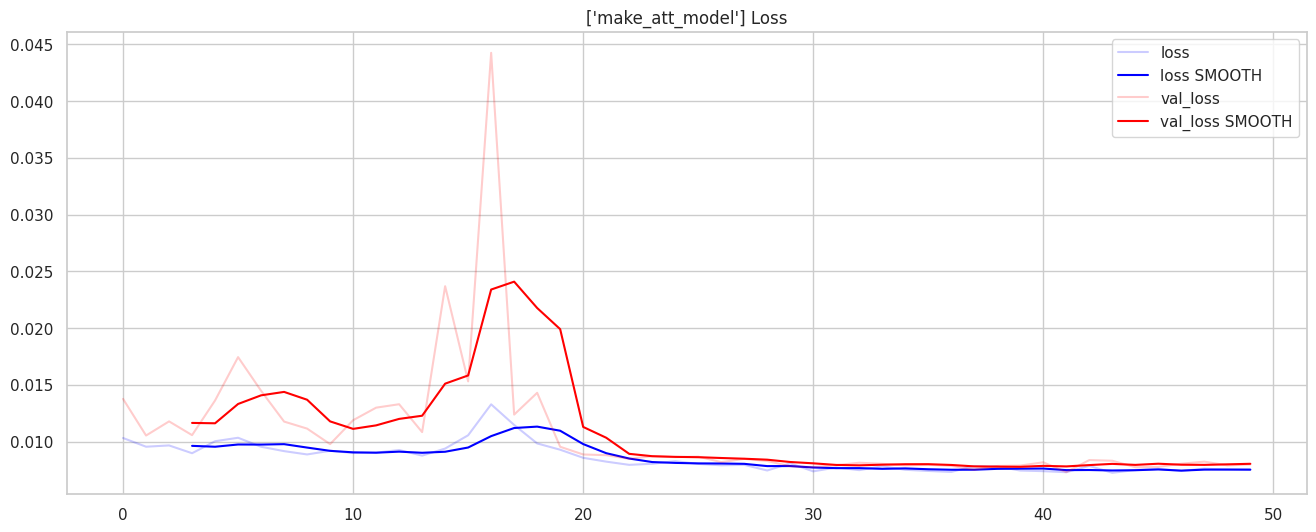

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


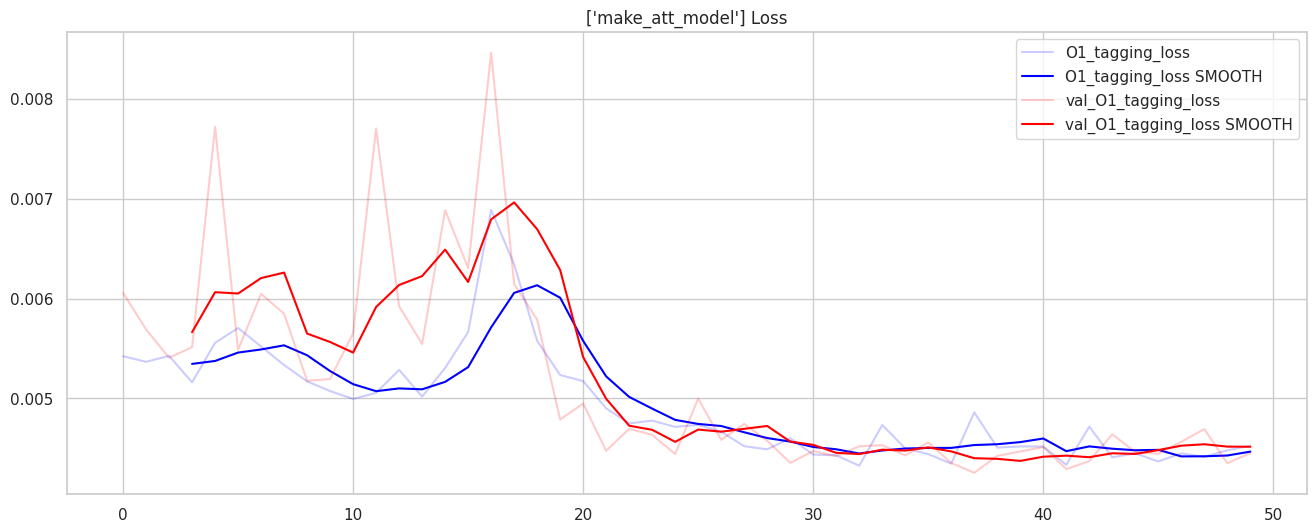

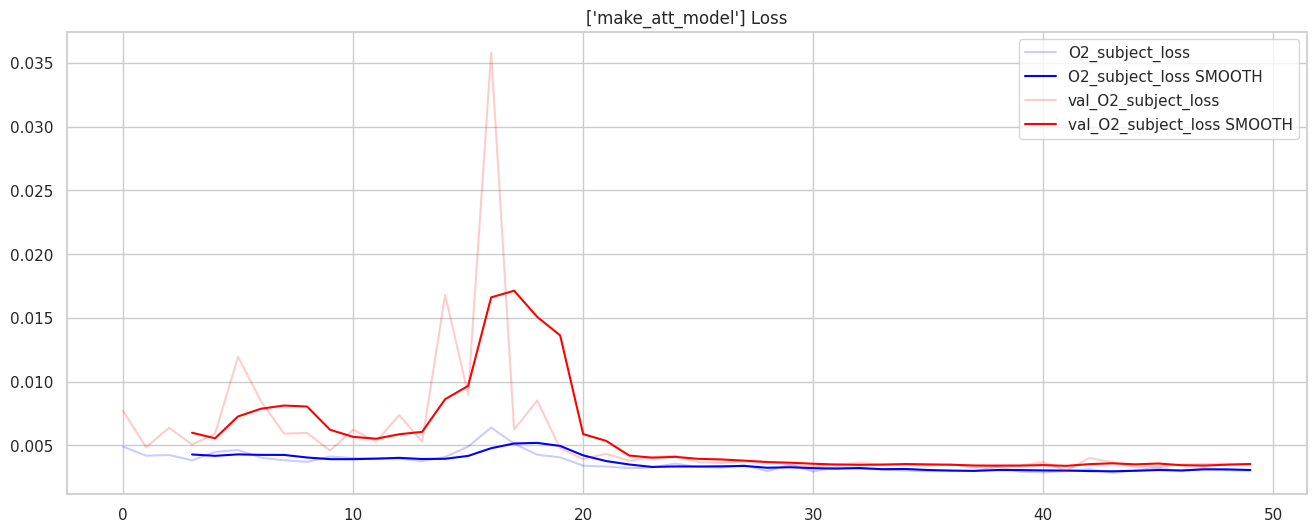

In [53]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [54]:
# umtm.stats
# semantic_map_keys_contract


5ded4e284ddc27bcf92dd6ce


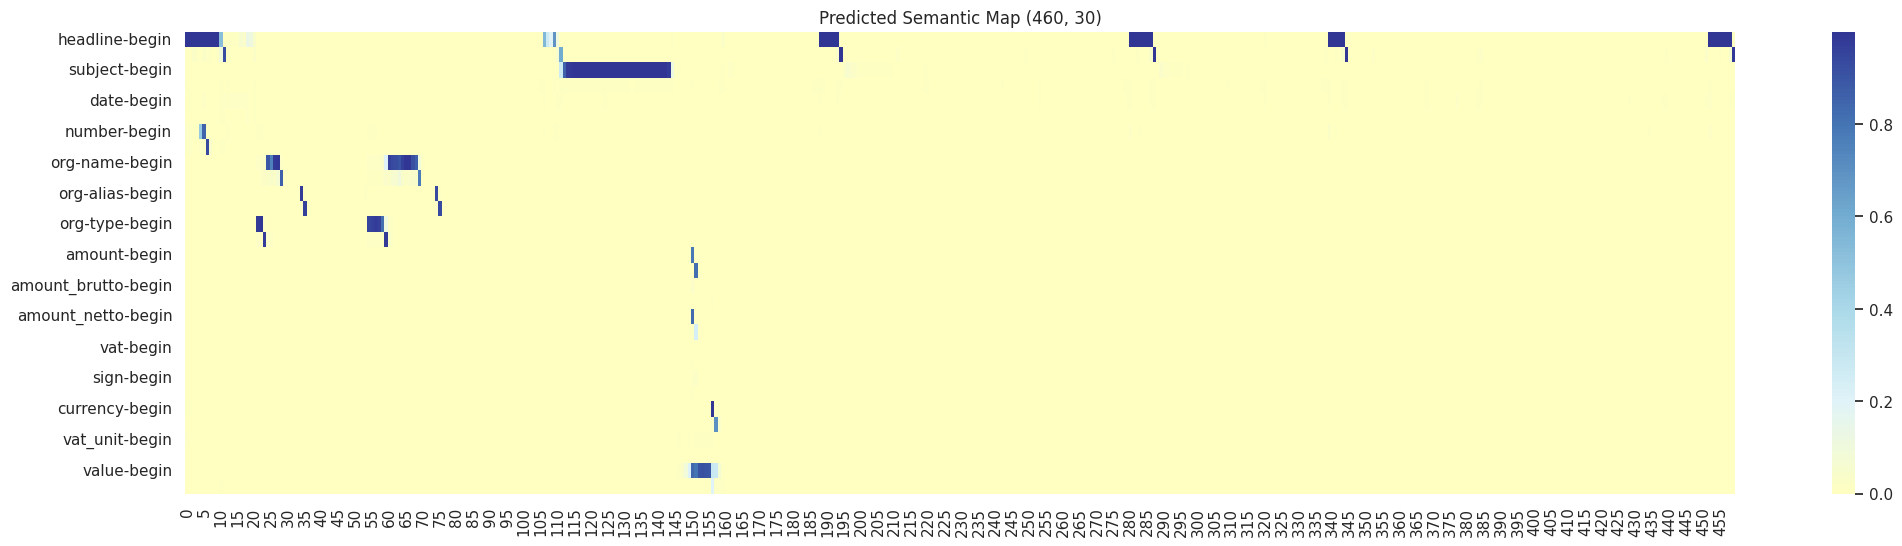

In [55]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [56]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [57]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'